# Figures for IIT SRC article

In [1]:
import numpy as np
import seaborn as sb
import os
import pandas as pd
from zipfile import ZipFile
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

from scipy.signal import find_peaks, butter, lfilter, windows, welch
from typing import Tuple

import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from adjustText import adjust_text
from tqdm.notebook import tqdm
import itertools


from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import silhouette_score

from vibrodiagnostics import ranking

plt.rcParams.update({'font.size': 14})

USE_ONE_AXIS = False  # or false
MAFAULDA_LABEL_METHODS = ['bearing-A', 'all-bearings', 'severity']
MAFAULDA_LABEL_METHOD = MAFAULDA_LABEL_METHODS[1]


MODEL_TYPE = 'knn'
#MODEL_TYPE = 'lda'
#MODEL_TYPE = 'bayes'
#MODEL_TYPE = 'svm' 

KNN_METRIC = 'euclidean'
#KNN_METRIC = 'cityblock'
#KNN_METRIC = 'cosine'


FEATURES_PATH = '../datasets/features/'
MAFAULDA_TEMPORAL = os.path.join(FEATURES_PATH, 'mafaulda_temporal.csv')
MAFAULDA_SPECTRAL = os.path.join(FEATURES_PATH, 'mafaulda_spectral.csv')

In [2]:
def spectral_transform(dataset: pd.DataFrame, axis: str, window: int, fs: int) -> Tuple[np.array, np.array]:
    overlap = 0.5
    step = int(window * overlap)

    v = dataset[axis].to_numpy()
    f, pxx = welch(
        v,
        fs=fs,
        window='hann',
        nperseg=window,
        noverlap=step,
        scaling='spectrum',
        average='mean',
        detrend='constant',
        return_onesided=True
    )
    return f, pxx

In [3]:
mafaulda_columns = ['ax', 'ay', 'az', 'bx', 'by', 'bz']
mafaulda_all_columns = ['tachometer', 'ax', 'ay', 'az', 'bx', 'by', 'bz', 'mic']
mafaulda_fs_hz = 50000


def rpm_calc(tachometer: pd.Series) -> float:
    tacho = tachometer.to_frame()
    f, s = spectral_transform(tacho, 'tachometer', 2**17, mafaulda_fs_hz)
    peaks, _ = find_peaks(s, height=0.7, distance=1000)
    f_rotation = f[peaks][0]
    return 60 * f_rotation

def mafaulda_lowpass_filter(
        data: pd.Series,
        cutoff: int = mafaulda_fs_hz // 5,
        fs: int = mafaulda_fs_hz,
        order: int = 5) -> pd.Series:
    
    b, a = butter(order, cutoff, fs=fs, btype='lowpass')
    y = lfilter(b, a, data.to_numpy())
    return pd.Series(data=y, index=data.index)

def mafaulda_csv_import(dataset: ZipFile, filename: str) -> pd.DataFrame:
    columns = mafaulda_all_columns
    ts = pd.read_csv(dataset.open(filename), names=columns)
    T = 1 / mafaulda_fs_hz
    ts = (
        ts
        .assign(t = lambda x: x.index * T)
        .reset_index()
        .assign(t = lambda x: x.index * T)
        .set_index('t')
        .assign(rpm = lambda x: rpm_calc(x.tachometer))
    )
    # Detrending
    ts[columns] = ts[columns].apply(lambda x: x - x.mean())
    # Low pass filter
    ts[columns] = ts[columns].apply(mafaulda_lowpass_filter)
    return ts.assign(key=filename)

In [4]:
fluidpump_columns = ['x', 'y', 'z']
fluidpump_all_columns = ['t', 'x', 'y', 'z']
fluidpump_fs_hz = 26866

def fluidpump_csv_import(dataset: ZipFile, filename: str) -> pd.DataFrame:
    ts = pd.read_csv(
        dataset.open(filename),
        delimiter='\t',
        index_col=False,
        header=0,
        names=fluidpump_all_columns
    ) 
    g = 9.80665
    columns = fluidpump_columns
    ts[columns] = ts[columns].apply(lambda x: g * (x / 1000))

    T = 1 / fluidpump_fs_hz
    ts = ts.assign(t = lambda x: x.index * T)
    ts.set_index('t', inplace=True)
    # time = 10
    # time_diff = 5
    # ts = ts.loc[time:time + time_diff]
    # Detrending
    ts[columns] = ts[columns].apply(lambda x: x - x.mean())
    return ts

#### Signal analysis
- 1ks plot (6x subplots) Mafaulda welch from each fault (1s, 2**14 window, hann window)  - largest severity - 2500 rpm
- 1ks plot (6x subplots) Custom dataset - each place in one day spectrum (5s segment)

In [5]:
# Mafaulda - worst severity at 2500 rpm
def plot_bearing_frequencies(freqs, pxx, bearings, ax, name, deltaF):
    position = {
        'M1-1': 'MTR001',
        'M2-1': 'MTR001',
        'M1-2': 'MTR002',
        'M2-2': 'MTR002',
        'P1-3': 'PMP003',
        'P2-3': 'PMP003',
        'P1-4': 'PMP004',
        'P2-4': 'PMP004',
    }
    bearing = bearings[
        bearings['placement'] == position.get(name, name)
    ]
    columns = ['RPM', 'BPFO', 'BPFI', 'BSF', 'FTF']
    colors = ['red', 'purple', 'orange', 'black', 'green']
    markers = ['s', 'o', 'D', 'P', 'x']
    n_harmonics = 20

    for col, color, mark in zip(columns, colors, markers):
        f_fundamental = bearing[col].values[0]
        f_harmonics = [i * f_fundamental for i in range(1, n_harmonics+1)]
        amplitudes = [
            pxx[int(f/deltaF)] for f in f_harmonics 
            if int(f/deltaF) < len(pxx)
        ]
        f_harmonics = f_harmonics[:len(amplitudes)]
        ax.plot(
            f_harmonics,
            amplitudes,
            color=color,
            marker=mark,
            markerfacecolor='None',
            markeredgecolor=color,
            linestyle='None',
            label=col,
            markeredgewidth=2
        )

    return ax.get_legend_handles_labels()

def plot_psd(
        ts, axname, fs, name, ax, window=2**15, 
        xlim=None, ylim=None, dB=False, bearings=None, 
        freqs=None, pxx=None):

    if freqs is None or pxx is None:
        freqs, pxx = spectral_transform(ts, axname, window, fs)

    if dB is True:
        pxx = 20 * np.log10(pxx / 0.000001)
        ax.set_ylabel('Amplitude [dB]')
    else:
        ax.set_ylabel('Amplitude [m/s\u00B2]')
        

    ax.plot(freqs, pxx, color='darkblue')
    ax.fill_between(freqs, pxx, color='lightblue', alpha=0.3)

    legend = None
    if bearings is not None:
        legend = plot_bearing_frequencies(freqs, pxx, bearings, ax, name, fs / window)

    ax.grid(True)
    #ax.set_xlabel('Frequency [Hz]')

    if xlim is not None:
        ax.set_xlim(0, xlim)
    if ylim is not None:
        ax.set_ylim(0, ylim)
    ax.set_title(name)

    return legend

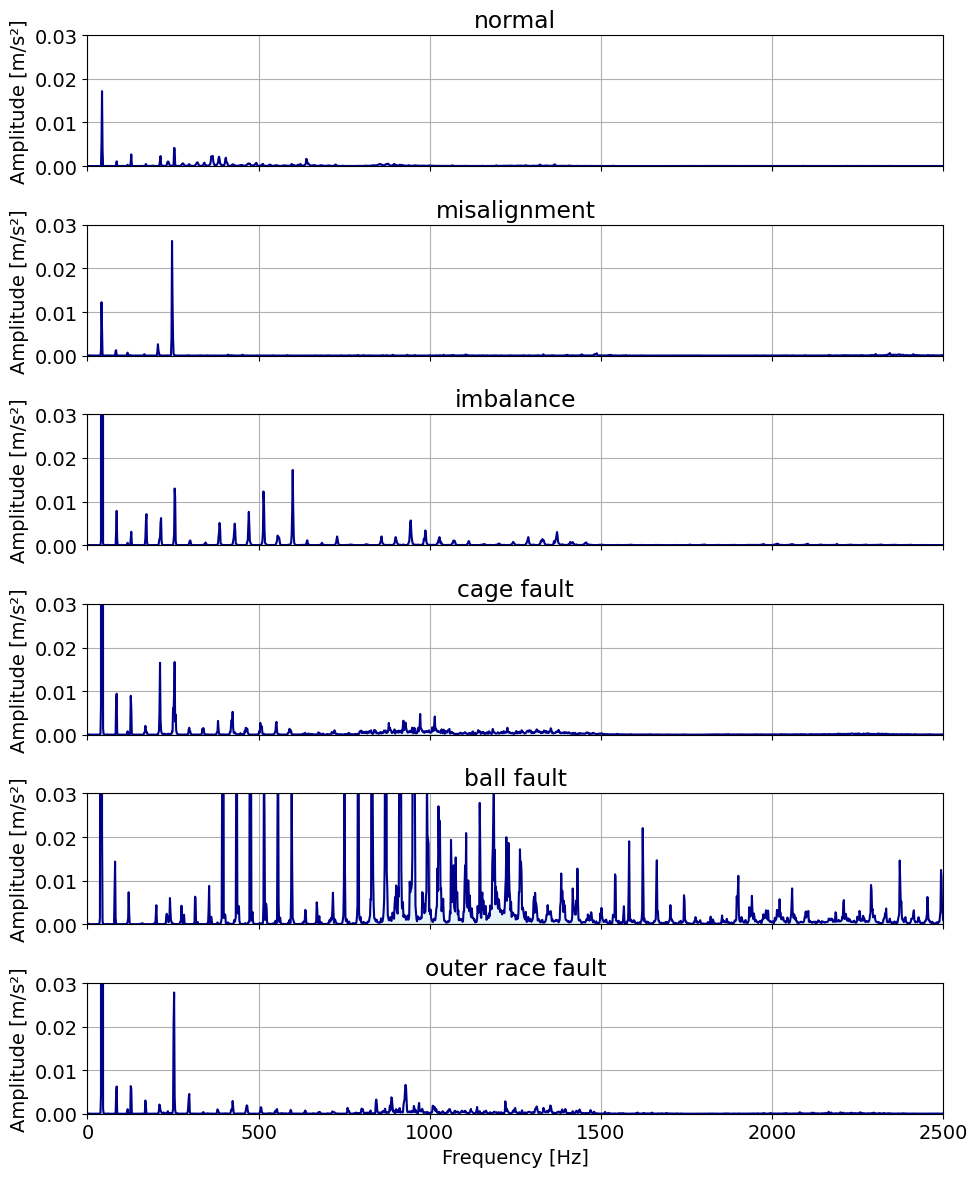

In [6]:
axname = 'ay'
dataset = ZipFile('../datasets/MAFAULDA.zip')
filenames = {
    'normal/43.6224.csv': 'normal',
    'horizontal-misalignment/2.0mm/42.5984.csv': 'misalignment',
    'imbalance/35g/43.6224.csv': 'imbalance',
    'underhang/cage_fault/35g/43.4176.csv': 'cage fault',
    'underhang/ball_fault/35g/41.1648.csv': 'ball fault',
    'underhang/outer_race/35g/43.4176.csv': 'outer race fault'
}
fig, ax = plt.subplots(len(filenames), 1, figsize=(10, 12), sharex=True)
for i, name in enumerate(filenames.items(), start=0):
    filename, title = name
    ts = mafaulda_csv_import(dataset, filename)
    plot_psd(ts, axname, mafaulda_fs_hz, title, ax[i], xlim=2500, ylim=0.03)
ax[-1].set_xlabel('Frequency [Hz]')

fig.tight_layout()
plt.show()

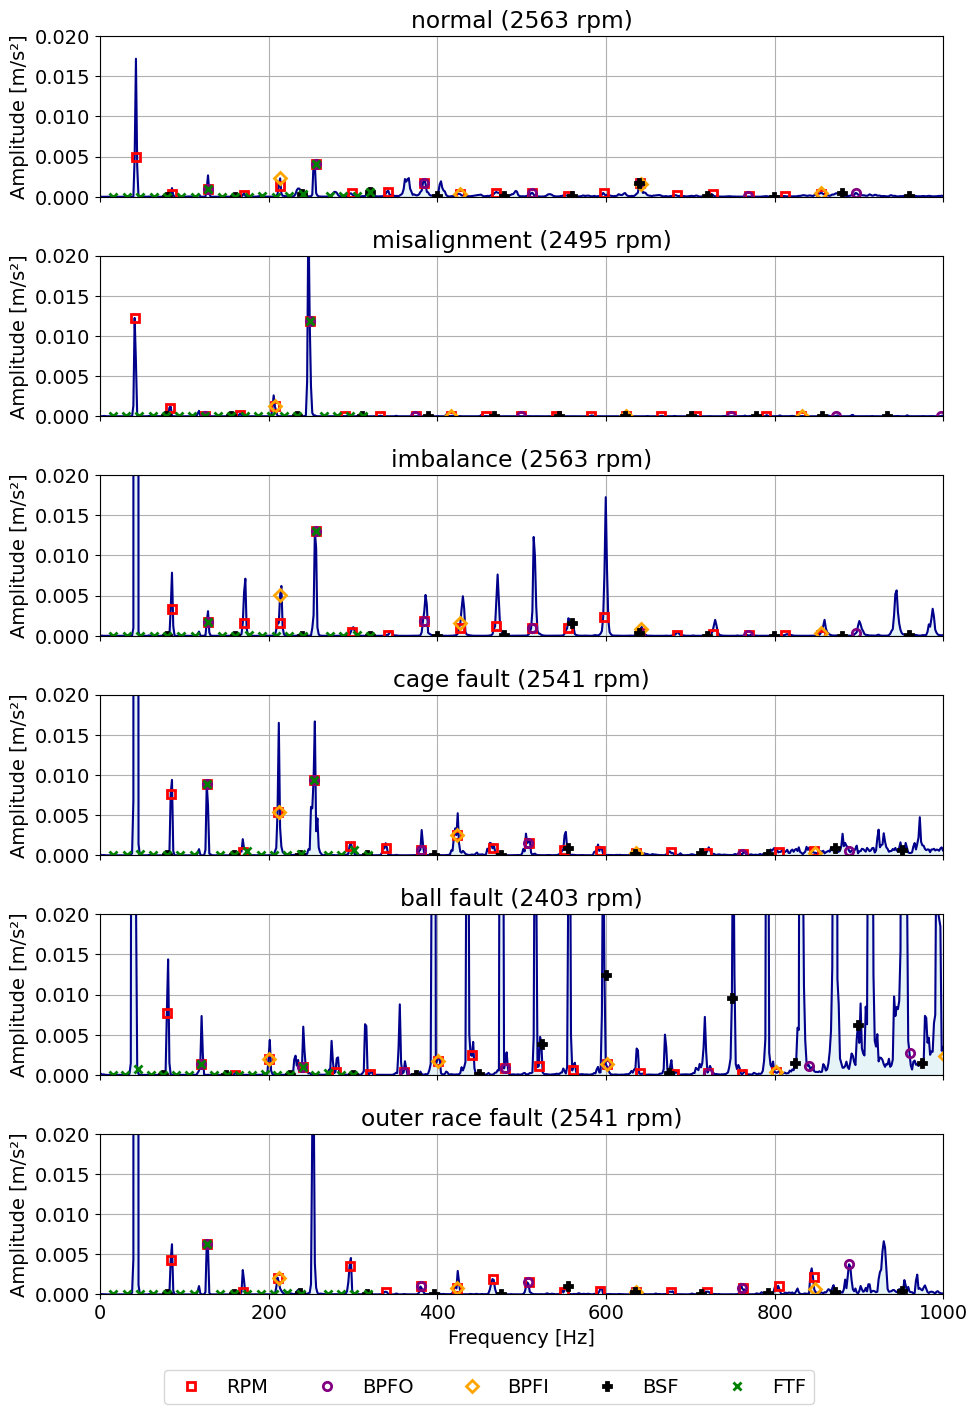

In [7]:
# Show Mafaulda faults
def maufaulda_bearing_frequencies(rpm):
    bearings = {
        'balls': 8,
        'ball_diameter': 0.7145,
        'pitch_diameter': 2.8519,
        'bpfo_factor': 2.9980,
        'bpfi_factor': 5.0020,
        'bsf_factor': 1.8710,
        'ftf_factor': 0.3750
    }

    machine = {}
    machine['RPM'] = rpm / 60
    machine['BPFO'] = bearings['bpfo_factor'] * machine['RPM'] 
    machine['BPFI'] = bearings['bpfi_factor'] * machine['RPM']
    machine['BSF'] = bearings['bsf_factor'] * machine['RPM']
    machine['FTF'] = bearings['ftf_factor'] * machine['RPM']

    return machine


# Detail on bearing frequencies
fig, ax = plt.subplots(len(filenames), 1, figsize=(10, 15), sharex=True)
for i, name in enumerate(filenames.items(), start=0):
    filename, title = name
    ts = mafaulda_csv_import(dataset, filename)
    rpm = ts['rpm'].mean()
    machine = maufaulda_bearing_frequencies(rpm)
    machine['placement'] = title
    machine = pd.DataFrame.from_records([machine])

    handles, labels = plot_psd(
        ts, axname, mafaulda_fs_hz, title, ax[i],
        xlim=1000, window=2**15, bearings=machine, dB=False
    )
    ax[i].set_title(f'{title} ({rpm:.0f} rpm)')
    ax[i].set_ylim(0, 0.02)
ax[-1].set_xlabel('Frequency [Hz]')

lines = 5
fig.legend(handles, labels, loc='lower center', ncol=lines, numpoints=1)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

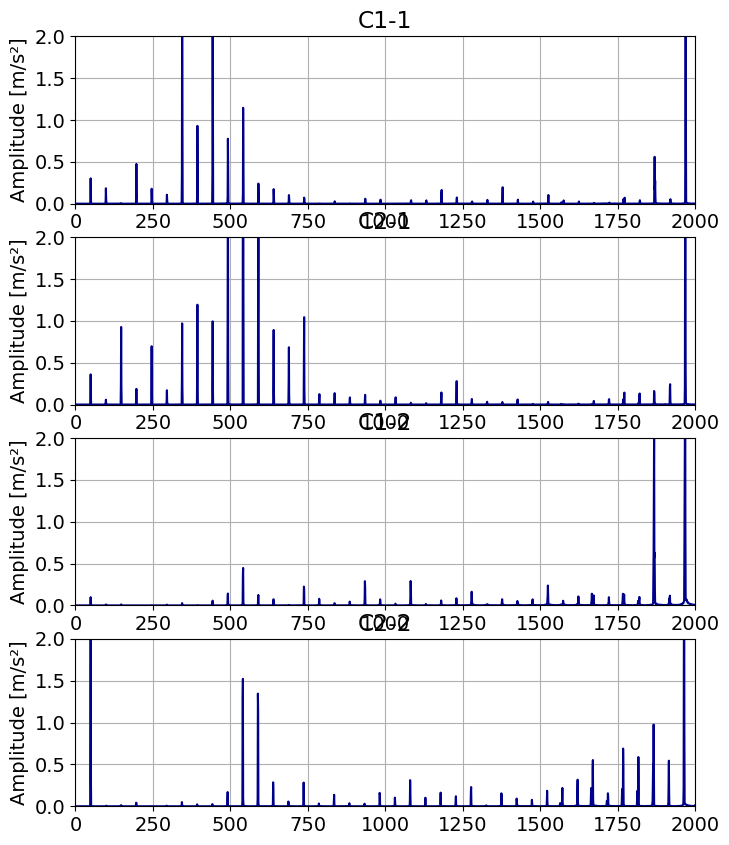

In [8]:
axname = 'z'
dataset = ZipFile('../datasets/FluidPump.zip')
filenames = {
    'compressor/2024-02-20/K3/001/1.tsv': 'C1-1',
    'compressor/2024-02-20/K5/001/1.tsv': 'C2-1',
    'compressor/2024-02-20/K3/002/1.tsv': 'C1-2',
    'compressor/2024-02-20/K5/002/1.tsv': 'C2-2'
}

fig, ax = plt.subplots(len(filenames), 1, figsize=(8, 10))
for i, name in enumerate(filenames.items(), start=0):
    filename, title = name
    ts = fluidpump_csv_import(dataset, filename)
    plot_psd(ts, axname, fluidpump_fs_hz, title, ax[i], xlim=2000, ylim=2)

#fig.tight_layout()
plt.show()

In [9]:
# Bearing frequencies
BEARINGS_FILE = os.path.join(FEATURES_PATH, 'bearings.csv')
BEARINGS_PROCESSED_FILE = os.path.join(FEATURES_PATH, 'bearings_processed.csv')

# http://webtools3.skf.com/engcalc/CalcBearingFrequencies.do
# https://www.skfbearingselect.com/#/type-arrangement/single-bearing
bearings = pd.read_csv(BEARINGS_FILE)
bearings['RPM'] = bearings['rpm'] / 60
# Outer race
bearings['BPFO'] = (
    (bearings['balls'] / 2) *
    (bearings['rpm'] / 60) *
    (1 - (bearings['ball_diameter'] / bearings['pitch_diameter']) * np.cos(np.radians(bearings['angle'])))
)
# Inner race
bearings['BPFI'] = (
    (bearings['balls'] / 2) *
    (bearings['rpm'] / 60) *
    (1 + (bearings['ball_diameter'] / bearings['pitch_diameter']) * np.cos(np.radians(bearings['angle'])))
)
# Ball
bearings['BSF'] = (
    (bearings['pitch_diameter'] / (2 * bearings['ball_diameter'])) *
    (bearings['rpm'] / 60) *
    (1 + ((bearings['ball_diameter'] / bearings['pitch_diameter']) * np.cos(np.radians(bearings['angle'])))**2)
)
# Cage
bearings['FTF'] = (
    0.5 * (bearings['rpm'] / 60) *
    (1 - (bearings['ball_diameter'] / bearings['pitch_diameter']) * np.cos(np.radians(bearings['angle'])))
)
bearings.to_csv(BEARINGS_PROCESSED_FILE)
bearings

placement  bearing  balls   rpm  ball_diameter  pitch_diameter  angle  \
0    MTR001  6319-C3      8  1493          33.12           147.5      0   
1    MTR002  6324-C3      8  1493          41.28           190.0      0   
2    PMP003  6317-2Z      8  1493          30.00           132.5      0   
3    PMP004  6317-2Z      8  1493          30.00           132.5      0   

   outer_diameter  inner_diameter  width        RPM       BPFO        BPFI  \
0             200              95     45  24.883333  77.183882  121.882784   
1             260             120     55  24.883333  77.908407  121.158260   
2             180              85     41  24.883333  76.997484  122.069182   
3             180              85     41  24.883333  76.997484  122.069182   

         BSF       FTF  
0  58.202674  9.647985  
1  59.968539  9.738551  
2  57.767676  9.624686  
3  57.767676  9.624686

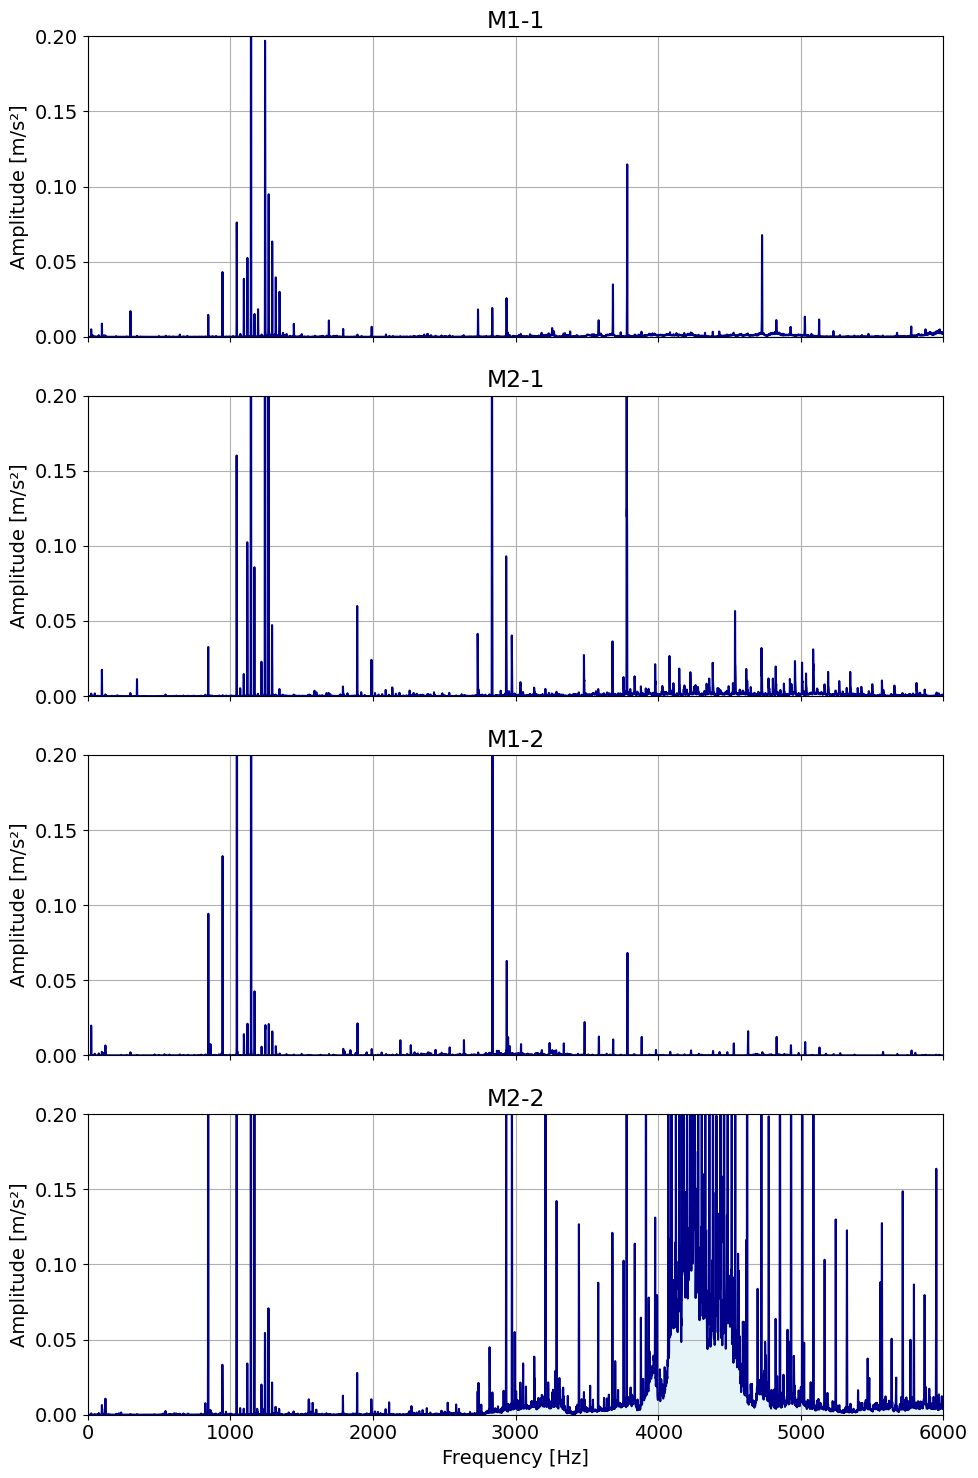

In [10]:
axname = 'z'
dataset = ZipFile('../datasets/FluidPump.zip')
i = 1
date = '2024-03-26'
filenames = {
    f'pump/{date}/KSB1/MTR001/{i}.tsv': 'M1-1',
    f'pump/{date}/KSB7/MTR001/{i}.tsv': 'M2-1',
    f'pump/{date}/KSB1/MTR002/{i}.tsv': 'M1-2',
    f'pump/{date}/KSB7/MTR002/{i}.tsv': 'M2-2'
}

fig, ax = plt.subplots(len(filenames), 1, figsize=(10, 15), sharex=True)
for i, name in enumerate(filenames.items(), start=0):
    filename, title = name
    ts = fluidpump_csv_import(dataset, filename)
    plot_psd(ts, axname, fluidpump_fs_hz, title, ax[i], xlim=6000, ylim=0.2)
ax[-1].set_xlabel('Frequency [Hz]')
fig.tight_layout()
plt.show()

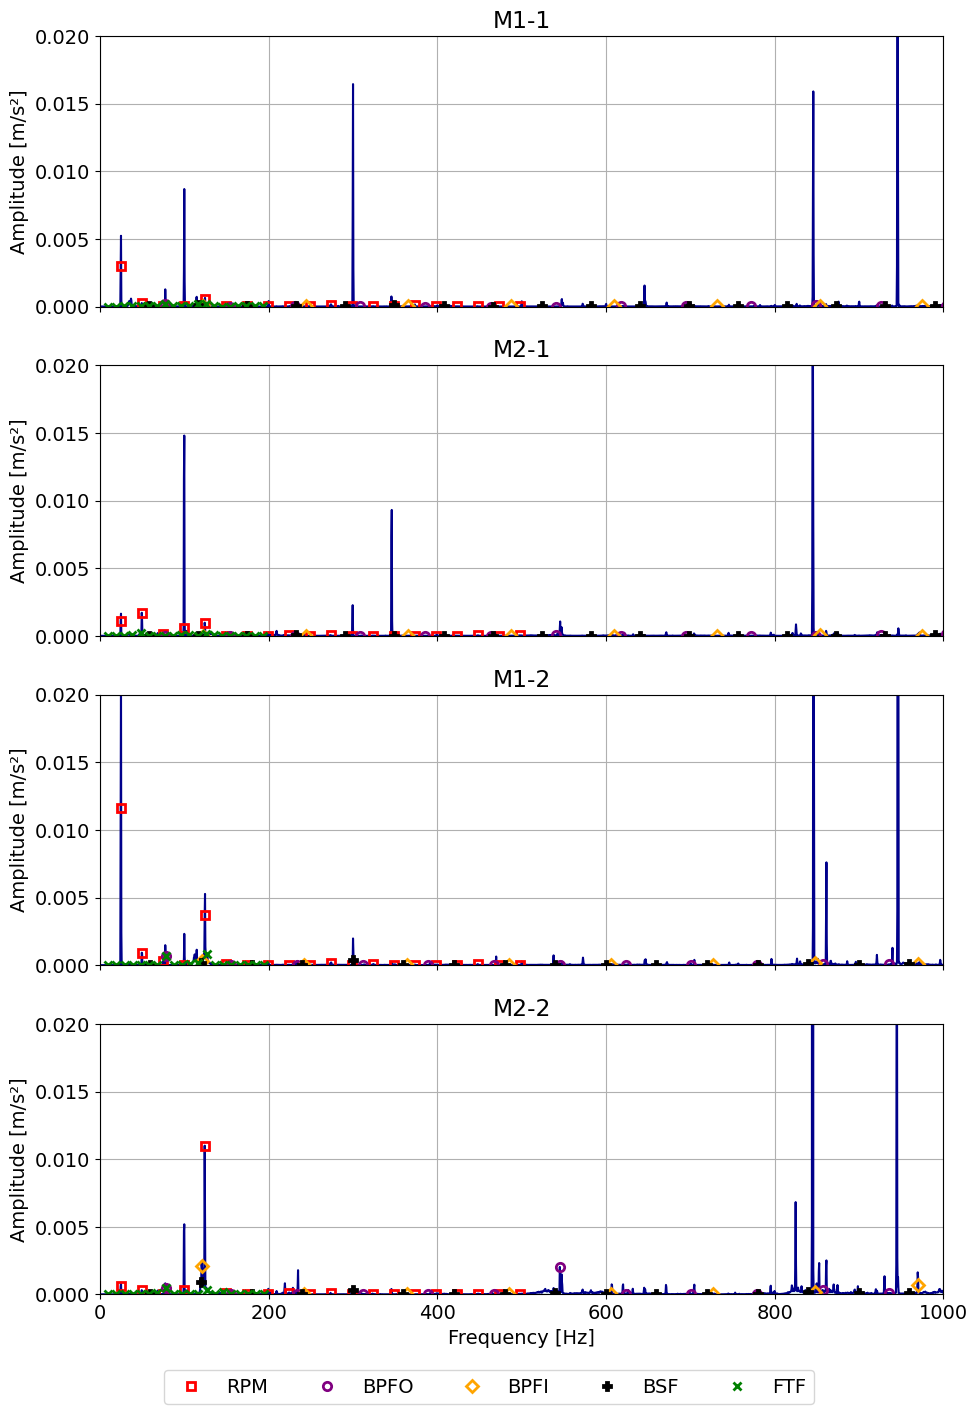

In [11]:
# Detail on bearing frequencies
fig, ax = plt.subplots(len(filenames), 1, figsize=(10, 15), sharex=True)
for i, name in enumerate(filenames.items(), start=0):
    filename, title = name
    ts = fluidpump_csv_import(dataset, filename)
    handles, labels = plot_psd(ts, axname, fluidpump_fs_hz, title, ax[i], xlim=1000, dB=False, window=2**16, bearings=bearings)
    ax[i].set_ylim(0, 0.02)

ax[-1].set_xlabel('Frequency [Hz]')

lines = 5
fig.legend(handles, labels, loc='lower center', ncol=lines, numpoints=1)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

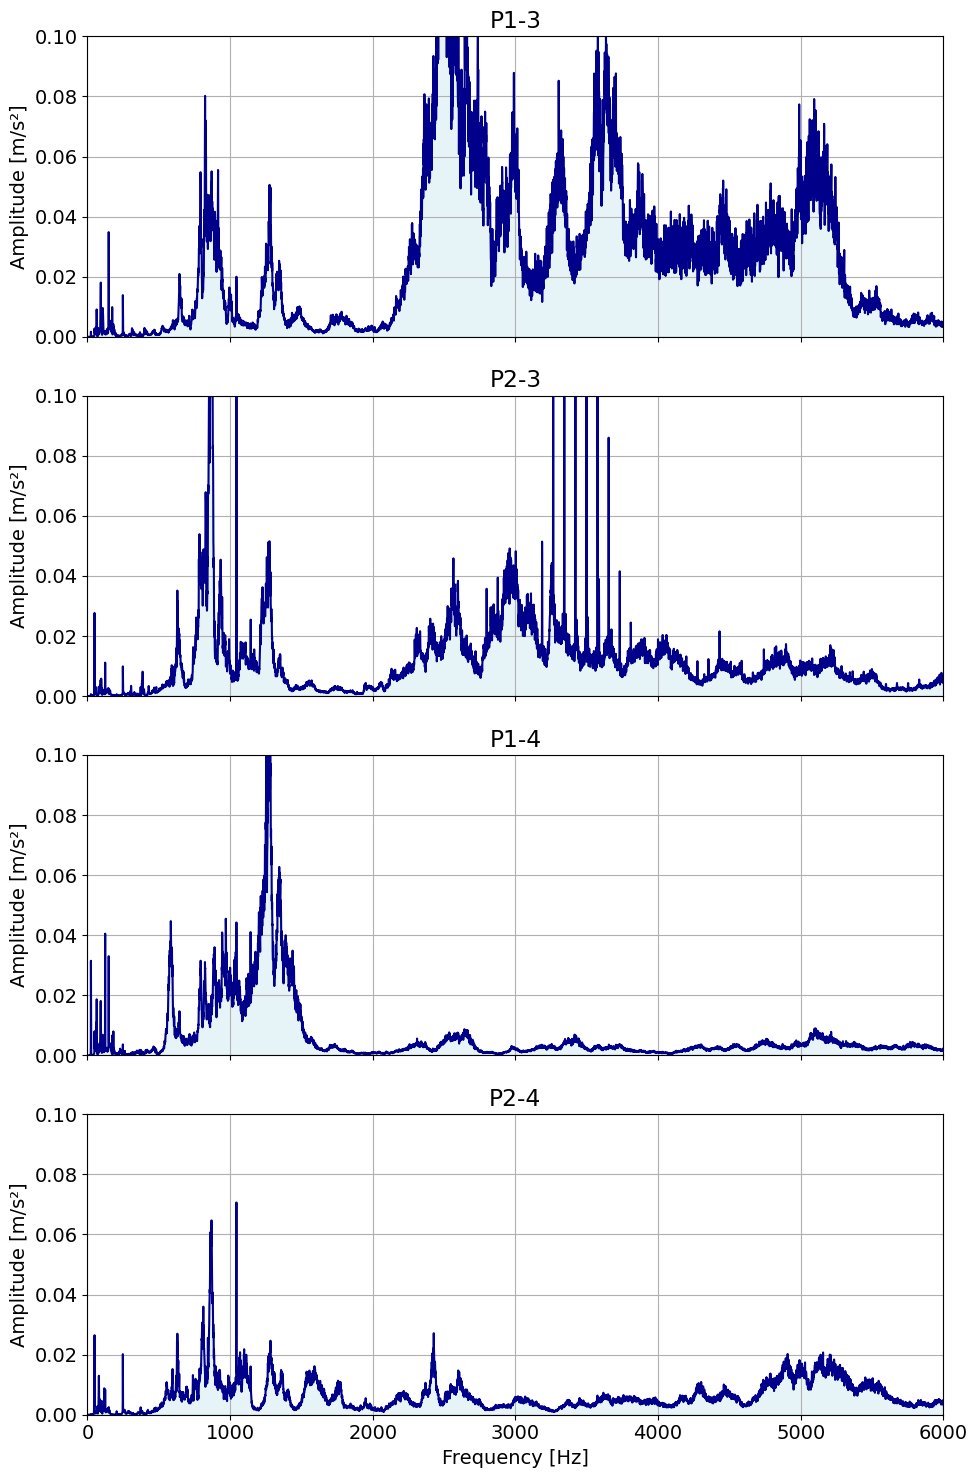

In [12]:
axname = 'z'
dataset = ZipFile('../datasets/FluidPump.zip')
i = 1
date = '2024-02-27'
filenames = {
    f'pump/{date}/KSB1/PMP003/{i}.tsv': 'P1-3',
    f'pump/{date}/KSB7/PMP003/{i}.tsv': 'P2-3',
    f'pump/{date}/KSB1/PMP004/{i}.tsv': 'P1-4',
    f'pump/{date}/KSB7/PMP004/{i}.tsv': 'P2-4'
}

# Overall
fig, ax = plt.subplots(len(filenames), 1, figsize=(10, 15),  sharex=True)
for i, name in enumerate(filenames.items(), start=0):
    filename, title = name
    ts = fluidpump_csv_import(dataset, filename)
    plot_psd(ts, axname, fluidpump_fs_hz, title, ax[i], xlim=6000, ylim=0.1)

ax[-1].set_xlabel('Frequency [Hz]')
fig.tight_layout()
plt.show()

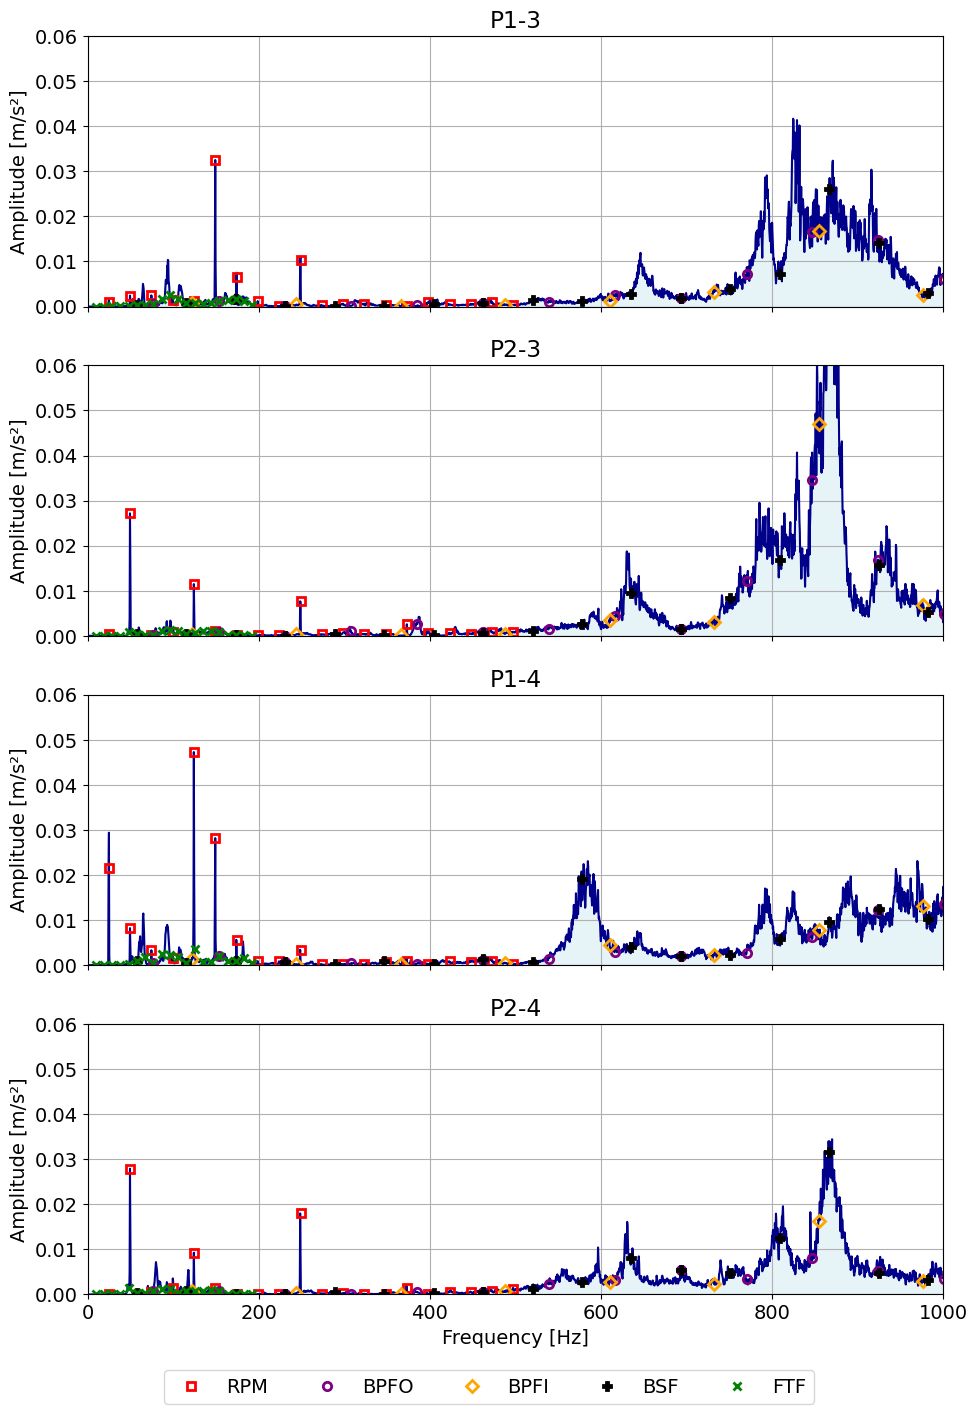

In [13]:
# Detail on bearing frequencies
fig, ax = plt.subplots(len(filenames), 1, figsize=(10, 15), sharex=True)
for i, name in enumerate(filenames.items(), start=0):
    filename, title = name
    ts = fluidpump_csv_import(dataset, filename)
    handles, labels = plot_psd(ts, axname, fluidpump_fs_hz, title, ax[i], xlim=1000, dB=False, window=2**16, bearings=bearings)
    ax[i].set_ylim(0, 0.06)

ax[-1].set_xlabel('Frequency [Hz]')

lines = 5
fig.legend(handles, labels, loc='lower center', ncol=lines, numpoints=1)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

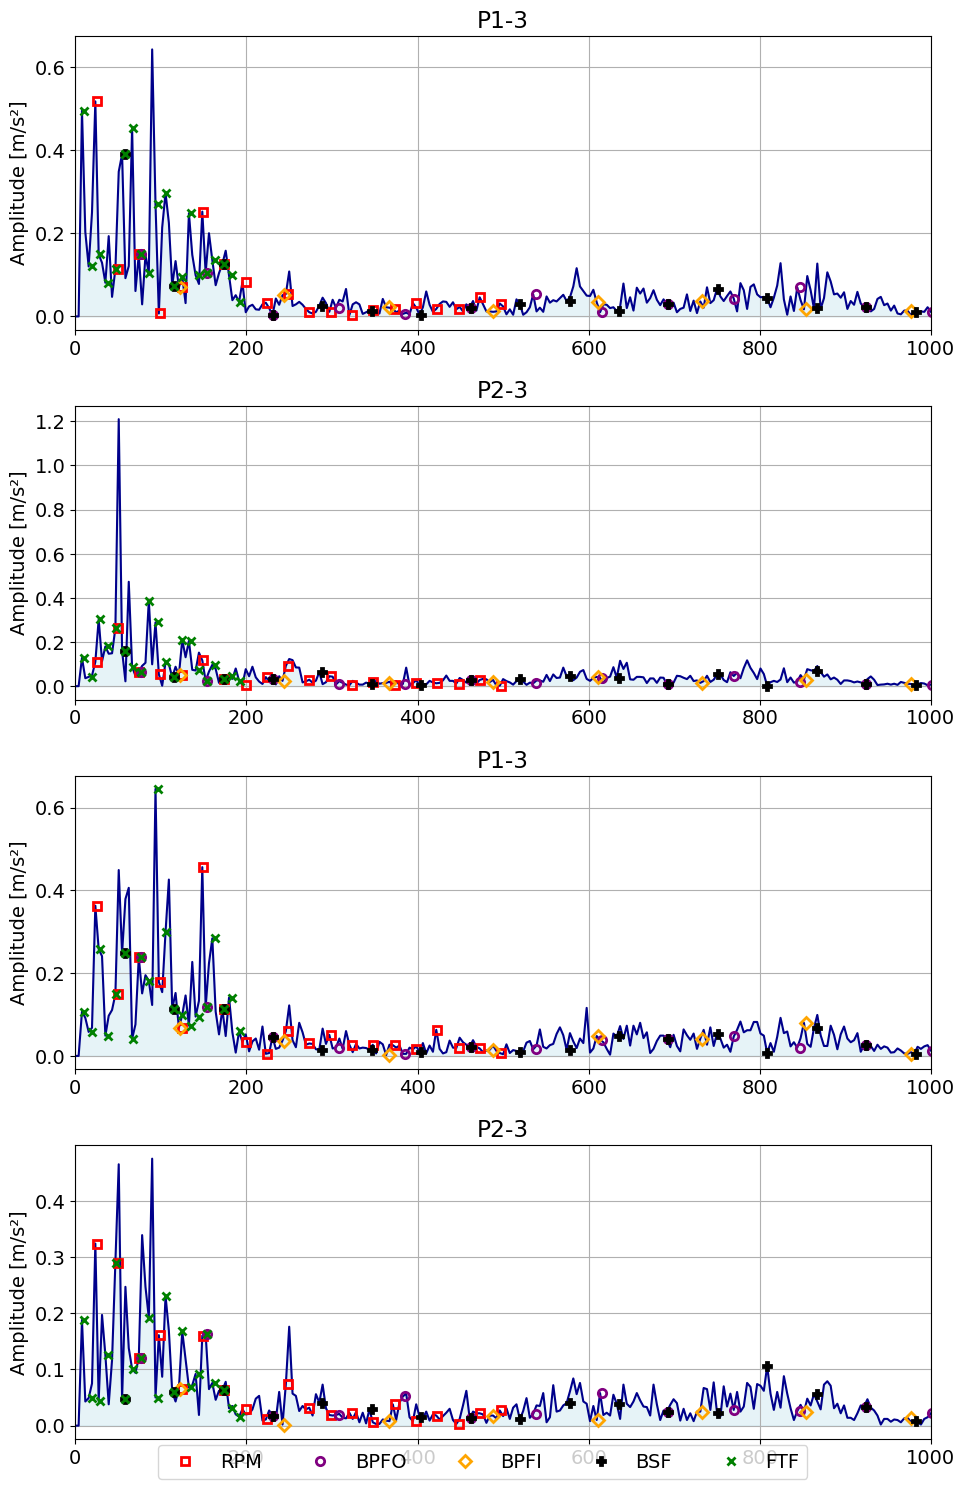

In [14]:
axname = 'z'
base_path = '../datasets/ksb-cloud/pumps-compare/'
i = 1
filenames = {
    'ksb-1-27-2-6-27.csv': 'P1-3',
    'ksb-7-28-2-11-43.csv': 'P2-3',
    'ksb-1-fft-26-3-6-33.csv': 'P1-3',
    'ksb-7-fft-13-3-5-33.csv': 'P2-3' 
}
fs_ksb = 2000

fig, ax = plt.subplots(len(filenames), 1, figsize=(10, 15))
for i, name in enumerate(filenames.items(), start=0):
    filename, title = name

    ts = pd.read_csv(
        os.path.join(base_path, filename),
        delimiter=';',
        decimal=',',
        index_col=False
    )
    ts.rename(columns={
        'Frequency [Hertz]': 'f', 
        'AmplitudeX [mm/s]': 'x',
        'AmplitudeY [mm/s]': 'y',
        'AmplitudeZ [mm/s]': 'z'
    }, inplace=True)
    ts = ts.set_index('f')
    
    handles, labels = plot_psd(
        None, axname, fs_ksb, title, ax[i], 
        dB=False, window=512, xlim=1000,
        bearings=bearings,
        freqs=ts.index.to_numpy(), pxx=ts['z'].to_numpy())

lines = 5
fig.legend(handles, labels, loc='lower center', ncol=lines)
fig.tight_layout()
plt.show()

#### Feature analysis:
Mafaulda (3) a Custom (4) 
- 1 ks table (how many faults have how many recordings)
- 1 ks plot (2 lines TD, FD) - number of PC vs. explained variance
- 1 ks plot (2x subplots TD, FD) - loading plot (PC2)
- 1 ks (4 subplots) custom: all machines, pumps, compressors, motors

##### 1. Explained varinace by PCA components and loading plots

In [15]:
def load_whole_dataset(dataset: dict, domain: str):
    axis = dataset['axis']
    label_cols = dataset['labels']
    filename = dataset[domain]

    features = pd.read_csv(filename)

    columns = features.columns.str.startswith(axis)
    X = features[features.columns[columns]]
    if label_cols is not None:
        Y = features[label_cols]
    else:
        Y = pd.DataFrame()

    names = X.columns.str.extract(r'([a-z]+)_([a-z\_\-]+)')[1].unique()
    feature_names = [f'{domain}_{col.strip("_")}' for col in names if not pd.isnull(col)]

    result = pd.DataFrame()
    for name in feature_names:              
        name = re.search(r'[a-z]+_([\w\_]+)', name).group(1)
        
        if USE_ONE_AXIS:
            dim = dataset['one-axis']
            result[name] = X[f'{dim}_{name}']
        else:
            vector_dims = [f'{dim}_{name}' for dim in axis]
            result[name] = X[vector_dims].apply(np.linalg.norm, axis=1)
    X = result
    return X, Y


def explained_variance(X):
    x_scaled = pd.DataFrame()
    x_scaled[X.columns] = MinMaxScaler().fit_transform(X)
    pca= PCA(n_components=10)
    X_pca = pca.fit_transform(x_scaled)
    return pca.explained_variance_ratio_


def get_principal_components(X):
    x_scaled = pd.DataFrame()
    x_scaled[X.columns] = MinMaxScaler().fit_transform(X)
    pca= PCA(n_components=2)
    X_pca = pca.fit_transform(x_scaled)
    return pca.components_


def plot_cumulative_explained_variance(td_variance, fd_variance):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(
        np.arange(1, len(td_variance) + 1),
        100 * np.cumsum(td_variance), 
        marker='s', label='Temporal features'
    )
    ax.plot(
        np.arange(1, len(fd_variance) + 1), 
        100 * np.cumsum(fd_variance),
        marker='s', label='Spectral features'
    )
    ax.set_xlabel('Number of principal components')
    ax.set_ylabel('Explained variance [%]')
    ax.grid()
    ax.legend()
    plt.show()


def loading_plot(loadings, feature_names, bottom, top):
    xs = loadings[0]
    ys = loadings[1]

    texts = []
    # Plot the loadings on a scatterplot
    for i, varnames in enumerate(feature_names):
        plt.arrow(
            0, 0,   # coordinates of arrow base
            xs[i],  # length of the arrow along x
            ys[i],  # length of the arrow along y
            color='r', 
            head_width=0.01
        )
        texts.append(plt.text(xs[i], ys[i], varnames))

    # Define the axis
    adjust_text(texts, only_move={'points':'y', 'texts':'y'})
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.xlim(bottom, top)
    plt.ylim(bottom, top)
    plt.grid()
    plt.show()

MaFaulDa

In [16]:
FEATURES_PATH = '../datasets/features'
mafaulda = {
    'temporal': MAFAULDA_TEMPORAL,
    'spectral': MAFAULDA_SPECTRAL,
    'axis': ('ax', 'ay', 'az'),
    'labels': ['fault', 'severity', 'rpm'],
    'one-axis': 'ay'
}

mafaulda['X_td'], mafaulda['Y'] = load_whole_dataset(mafaulda, 'temporal')
mafaulda['X_fd'], mafaulda['Y'] = load_whole_dataset(mafaulda, 'spectral')

In [17]:
# Class count
# 1) Label independently
faults = {
    'normal': 'normal',
    'imbalance': 'imbalance',
    'horizontal-misalignment': 'misalignment',
    'vertical-misalignment': 'misalignment',
    'underhang-outer_race': 'outer race fault',
    'underhang-cage_fault': 'cage fault',
    'underhang-ball_fault': 'ball fault',
    'overhang-outer_race': 'outer race fault',
    'overhang-cage_fault': 'cage fault',
    'overhang-ball_fault': 'ball fault'
}

bearing_faults = {
    'A': {
        'normal': 'normal',
        'imbalance': 'imbalance',
        'horizontal-misalignment': 'misalignment',
        'vertical-misalignment': 'misalignment',
        'underhang-outer_race': 'outer race fault',
        'underhang-cage_fault': 'cage fault',
        'underhang-ball_fault': 'ball fault'
    },
    'B': {
        'normal': 'normal',
        'imbalance': 'imbalance',
        'horizontal-misalignment': 'misalignment',
        'vertical-misalignment': 'misalignment',
        'overhang-outer_race': 'outer race fault',
        'overhang-cage_fault': 'cage fault',
        'overhang-ball_fault': 'ball fault',
    }
}

if MAFAULDA_LABEL_METHOD == 'bearing-A':
    mafaulda['Y']['target'] = mafaulda['Y'].apply(lambda row: bearing_faults['A'].get(row['fault']), axis=1)

elif MAFAULDA_LABEL_METHOD == 'all-bearings':
    mafaulda['Y']['target'] = mafaulda['Y'].apply(lambda row: faults.get(row['fault']), axis=1)

elif MAFAULDA_LABEL_METHOD == 'severity':
    table = mafaulda['Y'].copy()
    table['target'] = mafaulda['Y']['fault'].replace(faults)
    table['target'] = table['target'].astype('category')
    table['severity_no'] = table['severity'].str.extract(r'(\d+\.?\d*)').astype(float)

    for name, group in table.groupby(by=['target'], observed=True):
        group = group.sort_values(by='severity_no')
            
        severities = group['severity_no'].astype('category').cat.codes.values.reshape(-1, 1)
        scale_severities = MinMaxScaler().fit_transform(severities)

        sev_names = list(group['severity'].astype('category').cat.categories)
        sev = list(group['severity'].astype('category').cat.codes.astype('category').cat.categories)
        scale = [float(f'{p:.2f}') for p in pd.Series(scale_severities[:, 0]).astype('category').cat.categories]
        print(f'Fault: {name[0]}, Files: {len(group)}, Severity names: {sev_names}, Severity: {sev}, Severity Levels: {scale}')
        
        table.loc[group.index, 'severity_class'] = severities
        table.loc[group.index, 'severity_level'] = scale_severities

    table.loc[table['severity_level'] < 0.5, 'target'] = 'normal'
    mafaulda['Y'] = table


mafaulda['Y']['target'] = mafaulda['Y']['target'].astype('category')

In [18]:
# Count classes
counts = mafaulda['Y']['target'].value_counts().to_frame()
counts['freq'] = (counts['count'] / counts['count'].sum()) * 100
counts

count       freq
target                            
misalignment        498  25.525372
cage fault          376  19.272168
outer race fault    372  19.067145
imbalance           333  17.068170
ball fault          323  16.555613
normal               49   2.511533

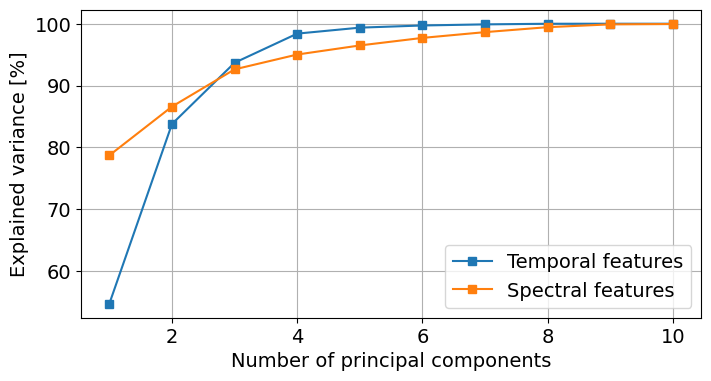

In [19]:
# Explained variance
td_variance = explained_variance(mafaulda['X_td'])
fd_variance = explained_variance(mafaulda['X_fd'])
plot_cumulative_explained_variance(td_variance, fd_variance)

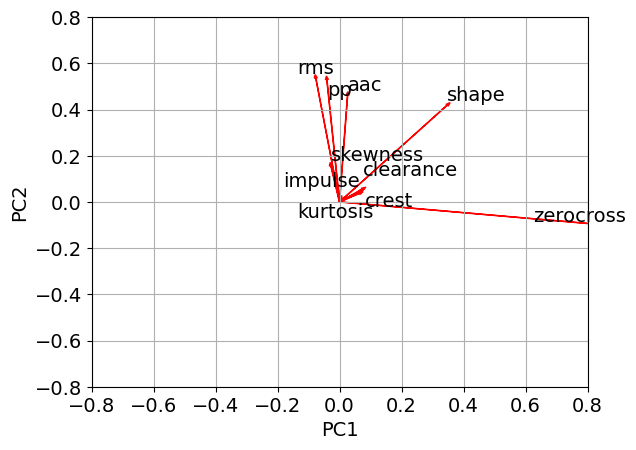

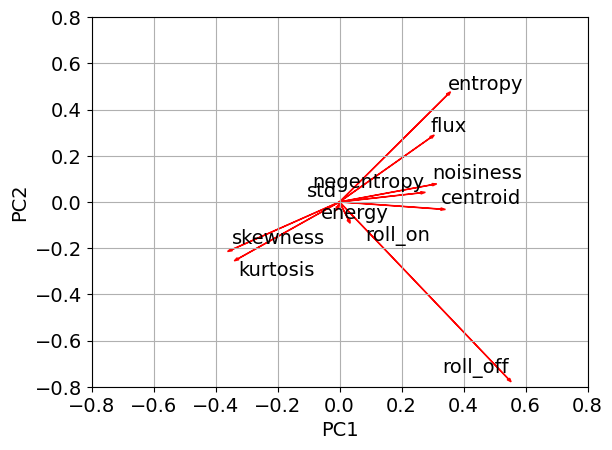

In [20]:
# Loading plots
td_pc = get_principal_components(mafaulda['X_td'])
fd_pc = get_principal_components(mafaulda['X_fd'])
loading_plot(td_pc, mafaulda['X_td'].columns, -0.8, 0.8)
loading_plot(fd_pc, mafaulda['X_fd'].columns, -0.8, 0.8)

Fluid pumps

In [21]:
# pump dataset (all devices, each type - pump, motor, compressor)
FEATURES_PATH = '../datasets/features'
pump = {
    'temporal': os.path.join(FEATURES_PATH, 'fluidpump_temporal.csv'),
    'spectral': os.path.join(FEATURES_PATH, 'fluidpump_spectral.csv'),
    'axis': ('x', 'y', 'z'),
    'labels': ['date', 'device', 'position'],
    'one-axis': 'z'
}

pump['X_td'], pump['Y'] = load_whole_dataset(pump, 'temporal')
pump['X_fd'], pump['Y'] = load_whole_dataset(pump, 'spectral')

In [22]:
# Class count
machines = {
    'KSB1': {
        'MTR001': 'M1',
        'MTR002': 'M1',
        'PMP003': 'P1',
        'PMP004': 'P1'
    },
    'KSB7': {
        'MTR001': 'M2',
        'MTR002': 'M2',
        'PMP003': 'P2',
        'PMP004': 'P2'
    },
    'K3': {
        '001': 'C1',
        '002': 'C1'
    },
    'K5': {
        '001': 'C2',
        '002': 'C2'
    }
}

pump['Y']['target'] = pump['Y'].apply(lambda row: machines.get(row['device'], {}).get(row['position']), axis=1)
pump['Y']['target'] = pump['Y']['target'].astype('category')

counts = pump['Y']['target'].value_counts().to_frame()
counts['freq'] = (counts['count'] / counts['count'].sum()) * 100
counts

count       freq
target                  
C1        216  21.428571
C2        216  21.428571
M1        144  14.285714
M2        144  14.285714
P1        144  14.285714
P2        144  14.285714

In [23]:
# Motor and pump only

# Label by device
labels_machines = {
    'KSB1': {
        'MTR001': 'M1',
        'MTR002': 'M1',
        'PMP003': 'P1',
        'PMP004': 'P1'
    },
    'KSB7': {
        'MTR001': 'M2',
        'MTR002': 'M2',
        'PMP003': 'P2',
        'PMP004': 'P2'
    }
}
pump['Y']['label_machine'] = pump['Y'].apply(
    lambda row: labels_machines.get(row['device'], {}).get(row['position']), axis=1
)

# Label by postion
label_positions = {
    'KSB1': {
        'MTR001': 'M1-1',
        'MTR002': 'M1-2',
        'PMP003': 'P1-3',
        'PMP004': 'P1-4'
    },
    'KSB7': {
        'MTR001': 'M2-1',
        'MTR002': 'M2-2',
        'PMP003': 'P2-3',
        'PMP004': 'P2-4'
    }
}
pump['Y']['label_position'] = pump['Y'].apply(
    lambda row: label_positions.get(row['device'], {}).get(row['position']), axis=1
)

# Label only P1-3, P2-3
label_binary = {
    'KSB1': {
        'PMP003': 'P1-3'
    },
    'KSB7': {
        'PMP003': 'P2-3'
    }
}
pump['Y']['label_binary'] = pump['Y'].apply(
    lambda row: label_binary.get(row['device'], {}).get(row['position']), axis=1
)

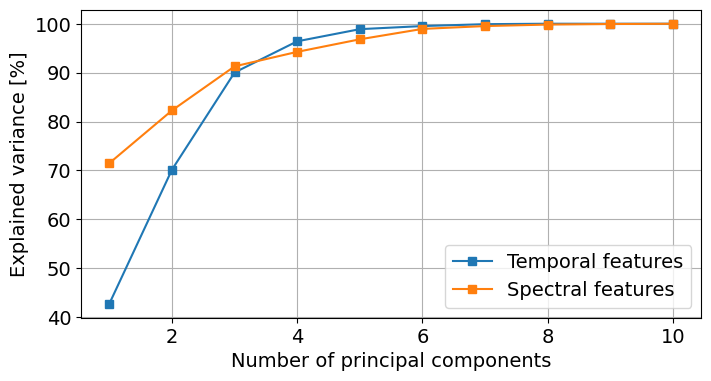

In [24]:
td_variance = explained_variance(pump['X_td'])
fd_variance = explained_variance(pump['X_fd'])
plot_cumulative_explained_variance(td_variance, fd_variance)

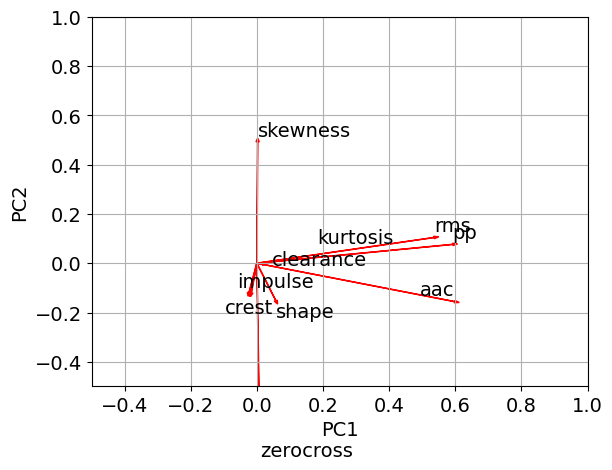

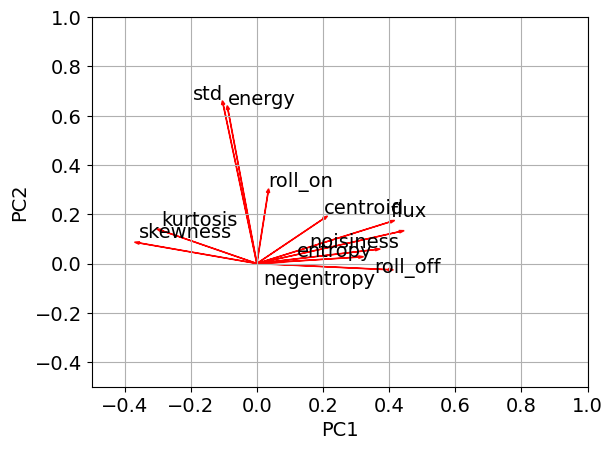

In [25]:
# Loading plots
td_pc = get_principal_components(pump['X_td'])
fd_pc = get_principal_components(pump['X_fd'])
loading_plot(td_pc, pump['X_td'].columns, -0.5, 1)
loading_plot(fd_pc, pump['X_fd'].columns, -0.5, 1)

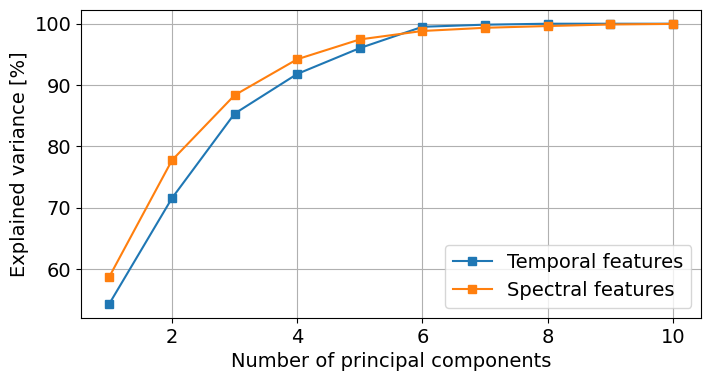

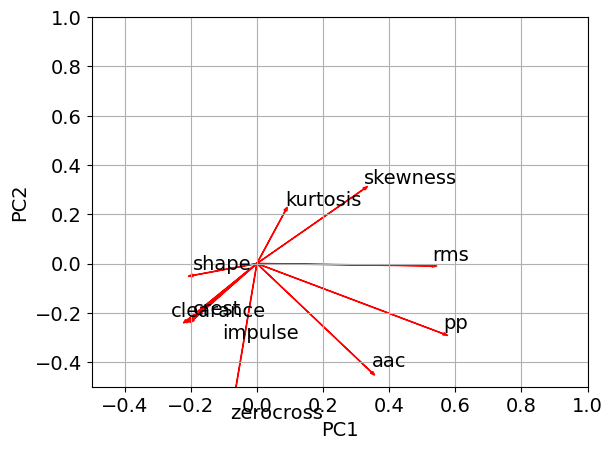

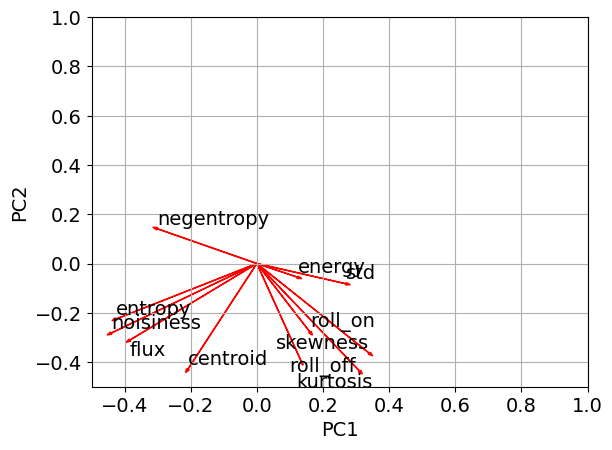

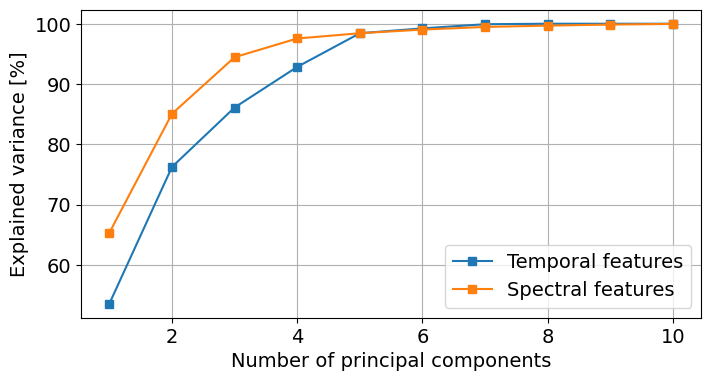

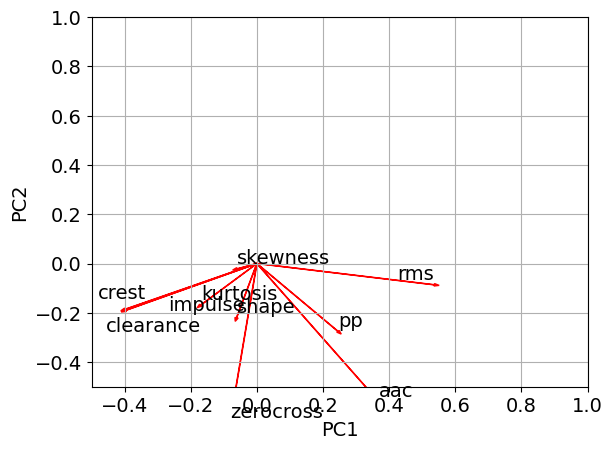

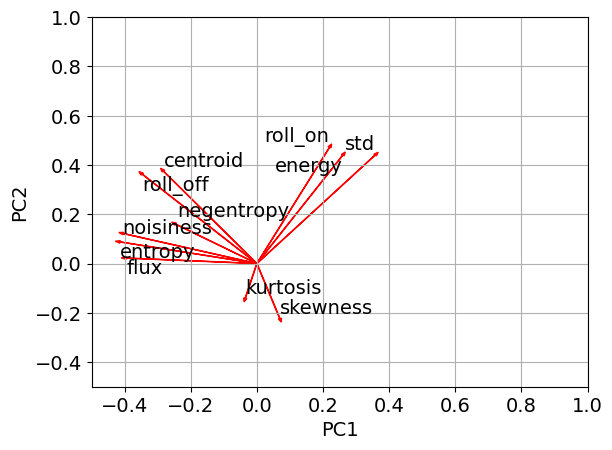

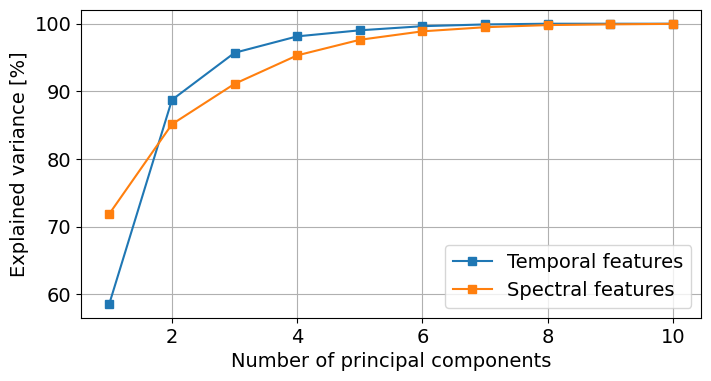

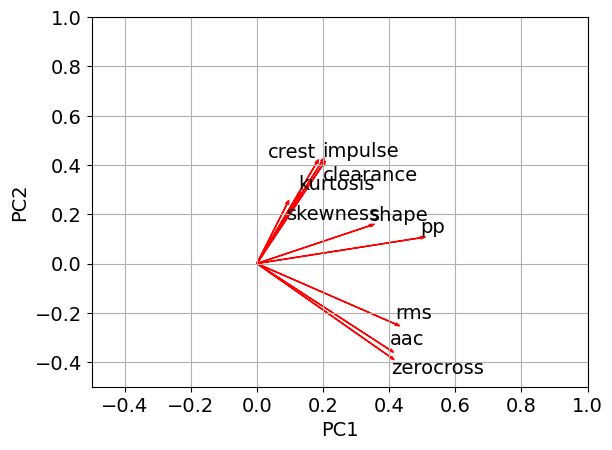

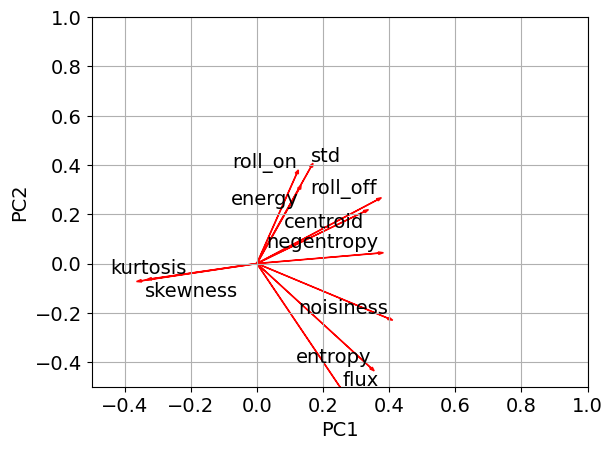

In [26]:
# Split by machine
Y = pump['Y']
compressor = Y[Y['device'].isin(['K3', 'K5'])].index
waterpump = Y[
    Y['device'].isin(['KSB1', 'KSB7']) & 
    Y['position'].isin(['PMP003', 'PMP004'])
].index
motor = Y[
    Y['device'].isin(['KSB1', 'KSB7']) & 
    Y['position'].isin(['MTR001', 'MTR002'])
].index

td_variance = explained_variance(pump['X_td'].loc[compressor])
fd_variance = explained_variance(pump['X_fd'].loc[compressor])
plot_cumulative_explained_variance(td_variance, fd_variance)

td_pc = get_principal_components(pump['X_td'].loc[compressor])
fd_pc = get_principal_components(pump['X_fd'].loc[compressor])
loading_plot(td_pc, pump['X_td'].columns, -0.5, 1)
loading_plot(fd_pc, pump['X_fd'].columns, -0.5, 1)

# -----
td_variance = explained_variance(pump['X_td'].loc[waterpump])
fd_variance = explained_variance(pump['X_fd'].loc[waterpump])
plot_cumulative_explained_variance(td_variance, fd_variance)

td_pc = get_principal_components(pump['X_td'].loc[waterpump])
fd_pc = get_principal_components(pump['X_fd'].loc[waterpump])
loading_plot(td_pc, pump['X_td'].columns, -0.5, 1)
loading_plot(fd_pc, pump['X_fd'].columns, -0.5, 1)

# -----
td_variance = explained_variance(pump['X_td'].loc[motor])
fd_variance = explained_variance(pump['X_fd'].loc[motor])
plot_cumulative_explained_variance(td_variance, fd_variance)

td_pc = get_principal_components(pump['X_td'].loc[motor])
fd_pc = get_principal_components(pump['X_fd'].loc[motor])
loading_plot(td_pc, pump['X_td'].columns, -0.5, 1)
loading_plot(fd_pc, pump['X_fd'].columns, -0.5, 1)


##### Scatter plots of labels after PCA
- 1 ks (5 subplots) scatter: mafaulda, all machines, pumps, compressors, motors

In [27]:
def model_boundaries(X, Y, n=5, model_name='knn'):
    # Class balancing
    oversample = RandomOverSampler(sampling_strategy='not majority', random_state=10)
    X, Y = oversample.fit_resample(X, Y.to_numpy())
    X.reset_index(drop=True, inplace=True)
    Y = pd.Series(Y)

    kf = KFold(n_splits=5, shuffle=True, random_state=10)

    for train_idx, test_idx in kf.split(X, Y):
        # Train / Test split in KFold
        x_train, x_test, y_train, y_test = (
            X.loc[train_idx].copy(), X.loc[test_idx].copy(),
            Y.loc[train_idx].copy(), Y.loc[test_idx].copy()
        )
        break

    if model_name == 'knn':
        model = KNeighborsClassifier(n_neighbors=n, metric=KNN_METRIC)#, algorithm='kd_tree')
    elif model_name == 'lda':
        model = LinearDiscriminantAnalysis()
    elif model_name == 'bayes':
        model = GaussianNB()
    elif model_name == 'svm':
        model = LinearSVC()

    model.fit(x_train, y_train)

    return model
    

def project_classes(X, Y, size=(10, 8), boundary=False, pc=None):
    Y = Y.dropna()
    X = X[X.index.isin(Y.index)].copy()
    Y = Y[Y.index.isin(X.index)].astype('category')

    scaler = MinMaxScaler()
    X[X.columns] = scaler.fit_transform(X)


    print(silhouette_score(X, Y))

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    X_pca = pd.DataFrame(X_pca)

    categories = Y.cat.categories
    colors = sb.color_palette('hls', len(categories))
    cmap = ListedColormap(colors.as_hex())

    fig, ax = plt.subplots(1, 1, figsize=size)

    i, j = (0, 1) if pc is None else pc

    # KNN model
    if boundary:
        h = .02
        model = model_boundaries(X_pca, Y.cat.codes, model_name=MODEL_TYPE)
        x_min = X_pca[i].min() - X_pca[i].std()
        x_max = X_pca[i].max() + X_pca[i].std()
        y_min = X_pca[j].min() - X_pca[j].std()
        y_max = X_pca[j].max() + X_pca[j].std()
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.pcolormesh(xx, yy, Z, cmap=cmap, alpha=0.5)


    ax.scatter(X_pca[0], X_pca[1], c=Y.cat.codes, cmap=cmap, edgecolors='black')

    legend_entries = []
    for c, n in dict(zip(Y.cat.codes, Y)).items():
        if n != 'nan':
            legend_entries.append(
                mpatches.Patch(color=colors[c], label=n)
            )

    ax.legend(handles=legend_entries)

    var = 100 * pca.explained_variance_ratio_
    ax.set_xlabel(f'PC1 ({var[0]:.2f} %)')
    ax.set_ylabel(f'PC2 ({var[1]:.2f} %)')
    ax.grid(True)
    plt.show()


def project_classes_3d(X, Y, size=(15, 4)):
    Y = Y.dropna()
    X = X[X.index.isin(Y.index)].copy()
    Y = Y[Y.index.isin(X.index)].astype('category')

    scaler = MinMaxScaler()
    X[X.columns] = scaler.fit_transform(X)

    print(silhouette_score(X, Y))

    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)
    X_pca = pd.DataFrame(X_pca)

    categories = Y.cat.categories
    colors = sb.color_palette('hls', len(categories))
    fig, ax = plt.subplots(1, 3, figsize=size)

    for pos, dim in enumerate([(0, 1), (0, 2), (1, 2)]):
        i, j = dim
        for label, color in zip(categories, colors):
            rows = list(Y[Y == label].index)
            x = X_pca[X_pca.index.isin(rows)][i]
            y = X_pca[X_pca.index.isin(rows)][j]
            ax[pos].scatter(x, y, s=2, color=color, label=label)

        var = 100 * pca.explained_variance_ratio_
        ax[pos].set_xlabel(f'PC{i+1} ({var[i]:.2f} %)')
        ax[pos].set_ylabel(f'PC{j+1} ({var[j]:.2f} %)')
        ax[pos].grid(True)
        ax[pos].legend()

    fig.tight_layout()
    plt.show()

-0.04028526841966526


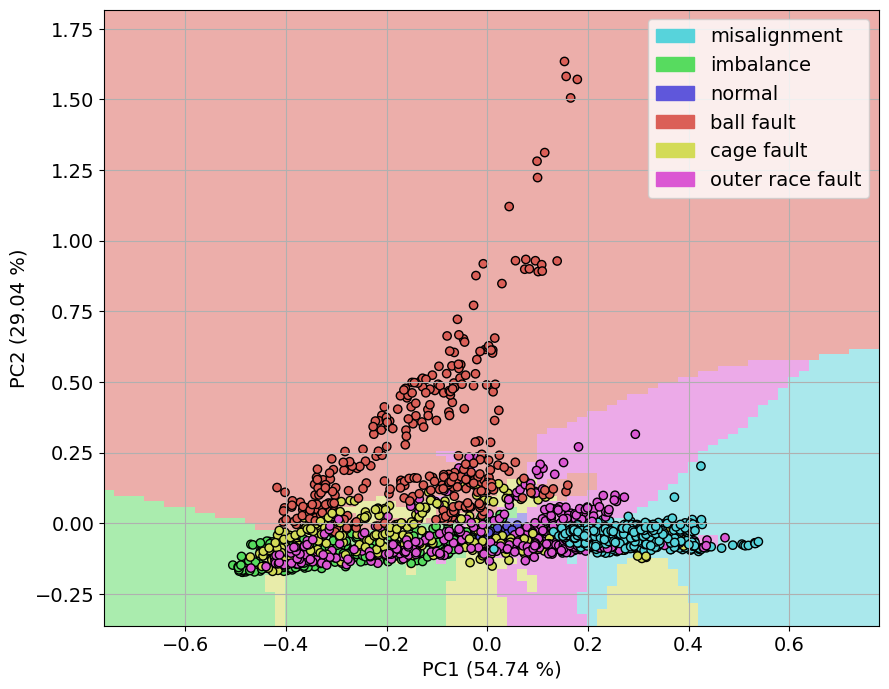

-0.04028526841966526


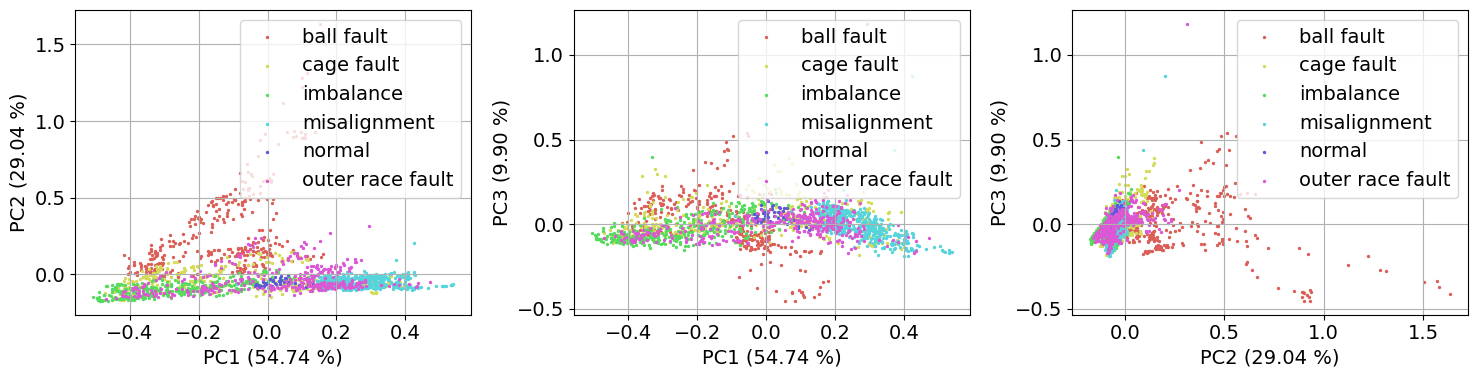

In [28]:
# Mafaulda temporal
project_classes(mafaulda['X_td'], mafaulda['Y']['target'], boundary=True)
project_classes_3d(mafaulda['X_td'], mafaulda['Y']['target'])

0.03727214120243223


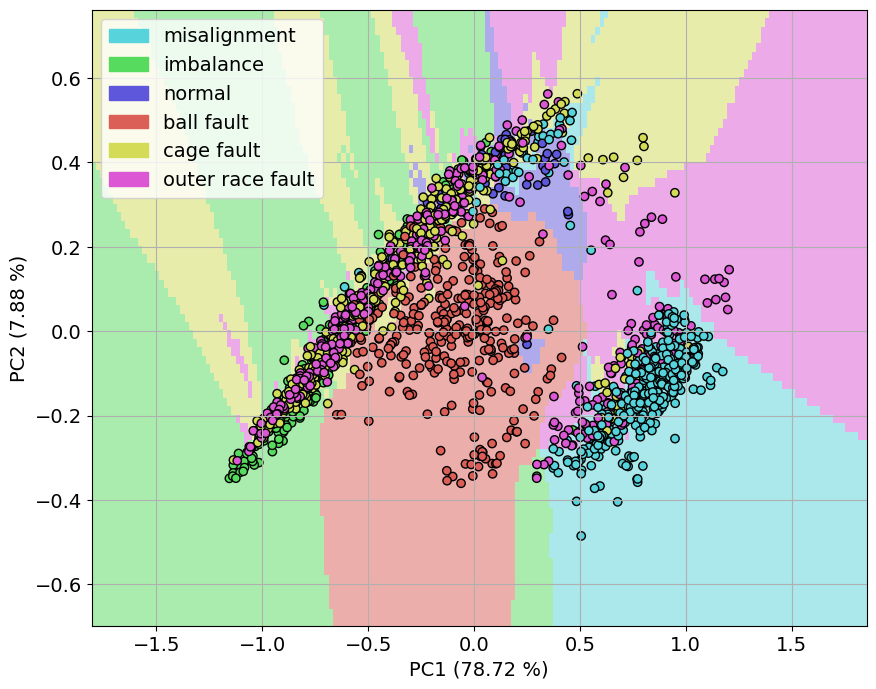

0.03727214120243223


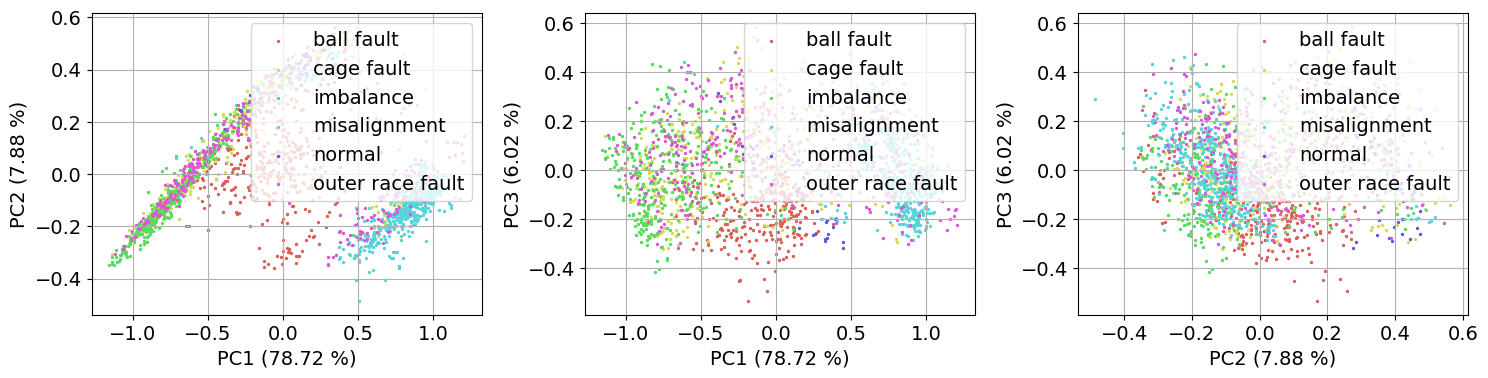

In [29]:
# Mafaulda spectral
project_classes(mafaulda['X_fd'], mafaulda['Y']['target'], boundary=True)
project_classes_3d(mafaulda['X_fd'], mafaulda['Y']['target'])

0.2033628984228101


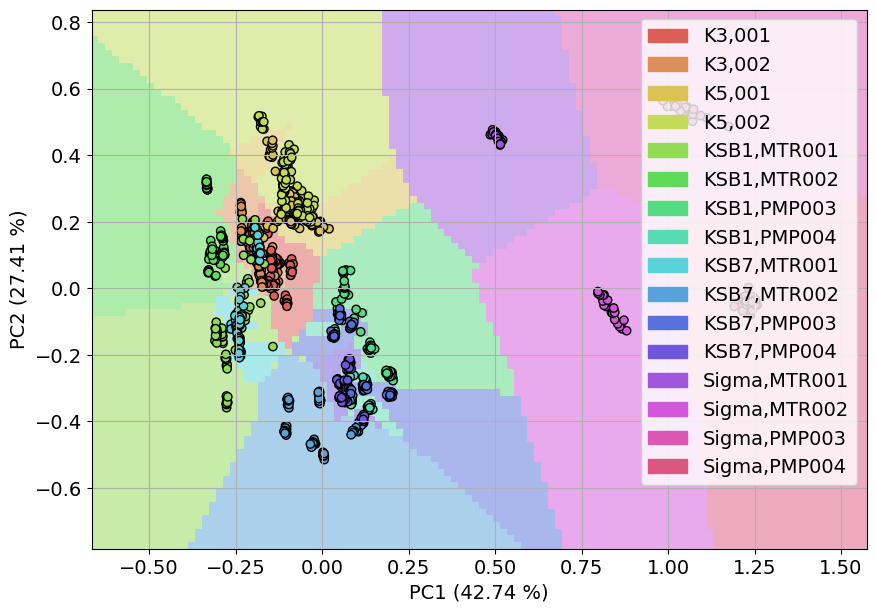

0.22027140762184036


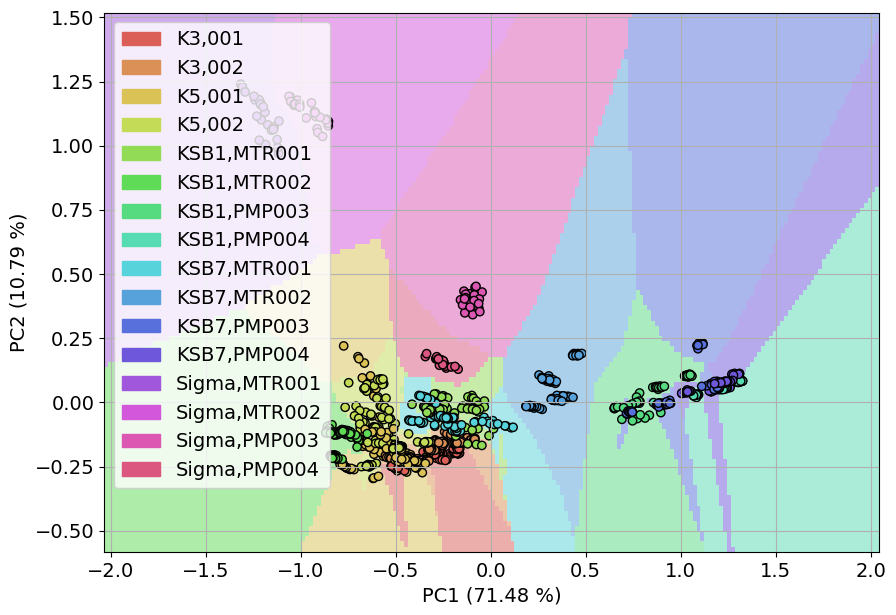

In [30]:
all_places = (pump['Y']['device'] + ',' + pump['Y']['position']).astype('category')
project_classes(pump['X_td'], all_places, size=(10, 7), boundary=True)
project_classes(pump['X_fd'], all_places, size=(10, 7), boundary=True)

0.21605922544495


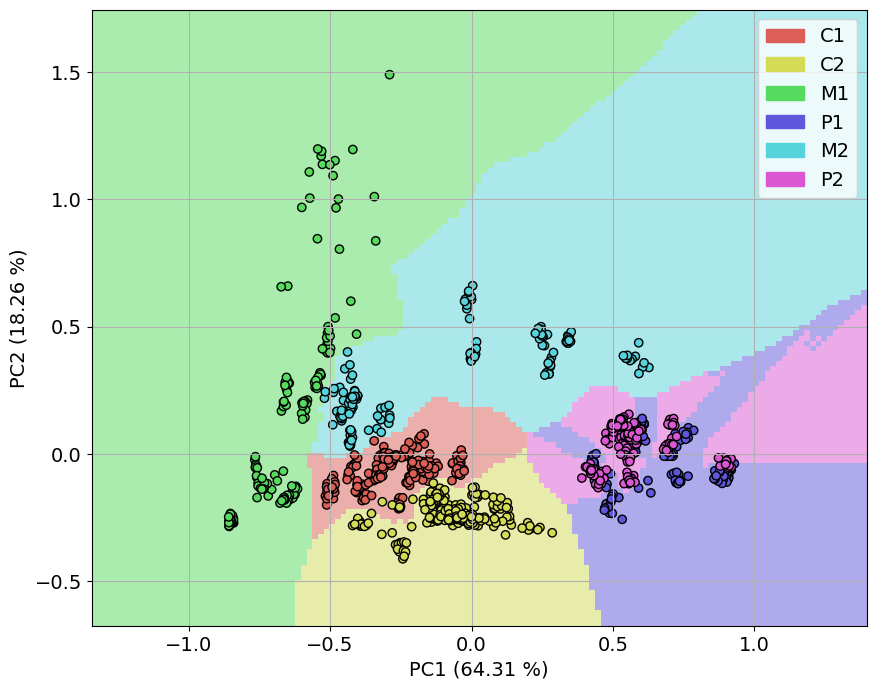

0.21605922544495


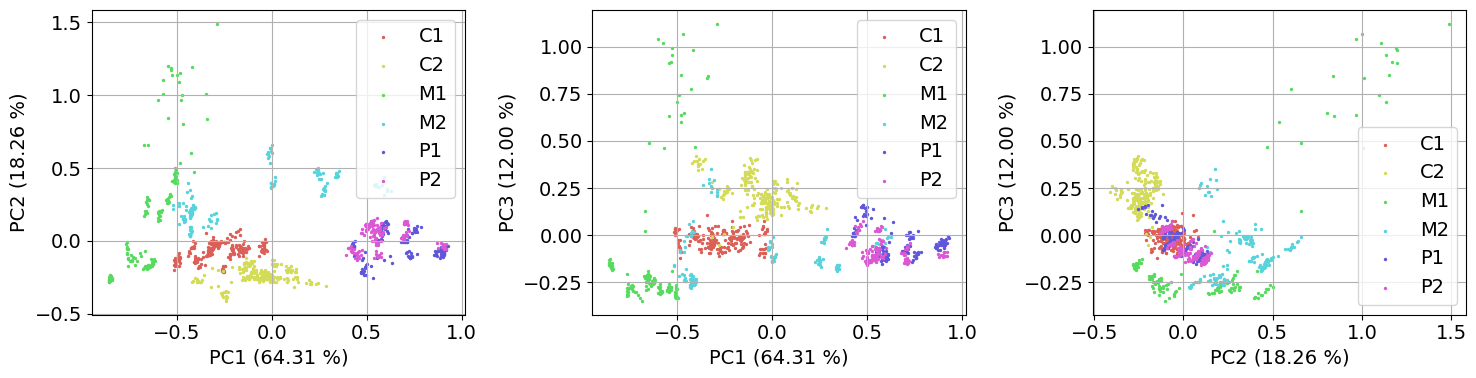

In [31]:
# Fluid pump temporal
project_classes(pump['X_td'], pump['Y']['target'], boundary=True)
project_classes_3d(pump['X_td'], pump['Y']['target'])

0.12893841674415948


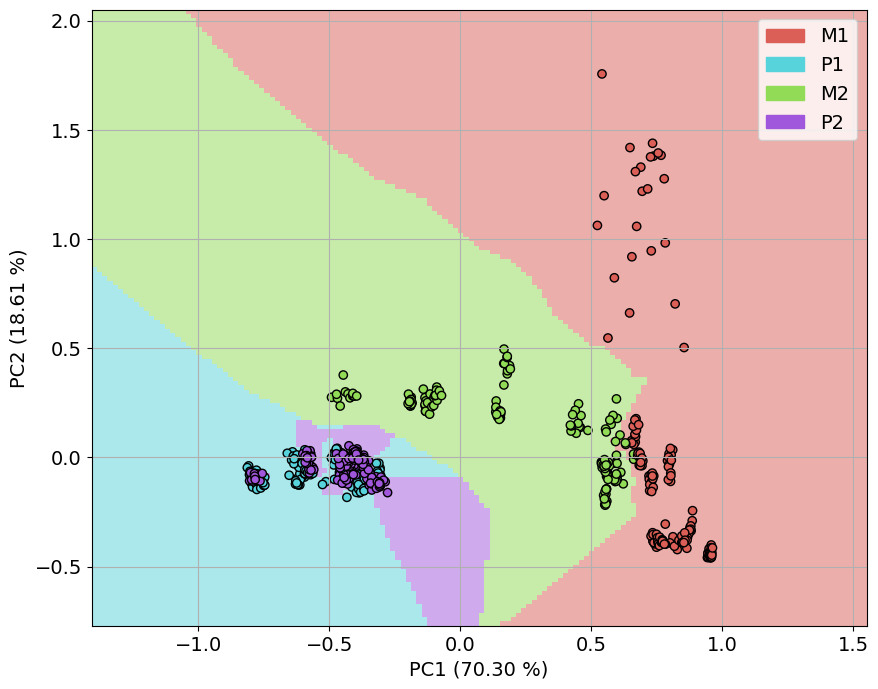

In [32]:
project_classes(pump['X_td'], pump['Y']['label_machine'], boundary=True)

0.2015622523622326


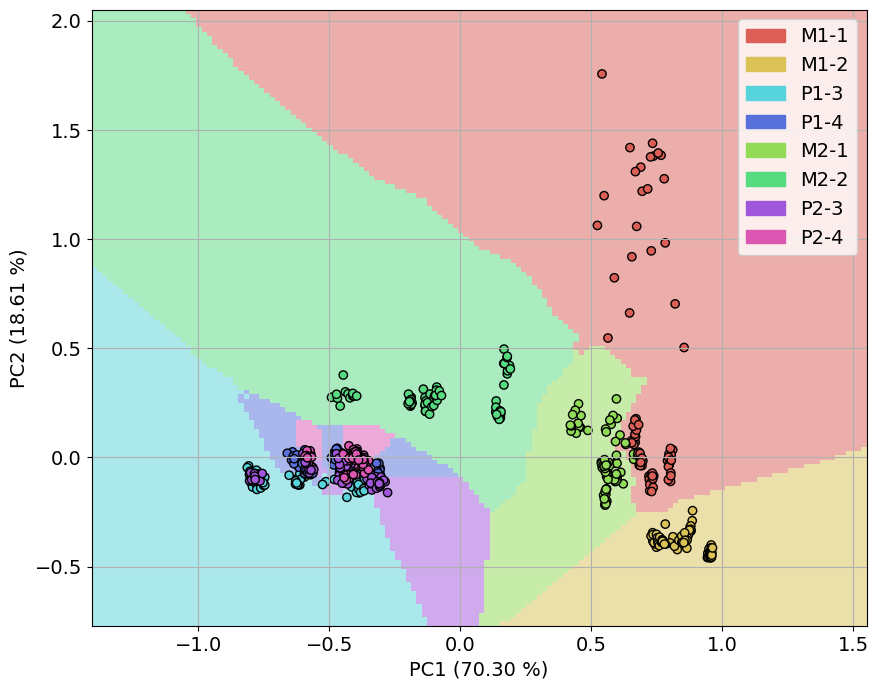

In [33]:
project_classes(pump['X_td'], pump['Y']['label_position'], boundary=True)

0.1906644121383394


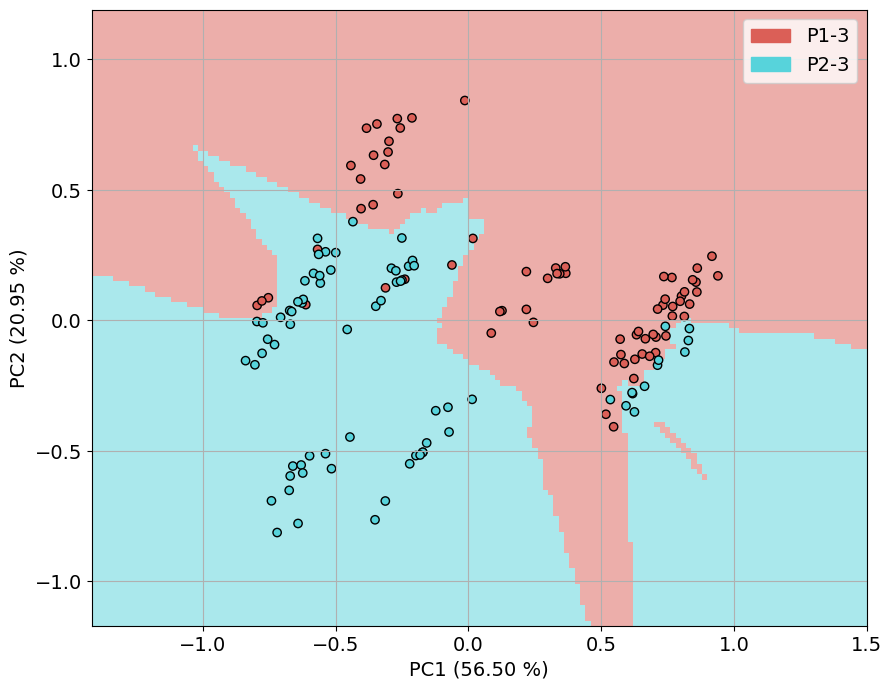

In [34]:
project_classes(pump['X_td'], pump['Y']['label_binary'], boundary=True)

0.182762492549281


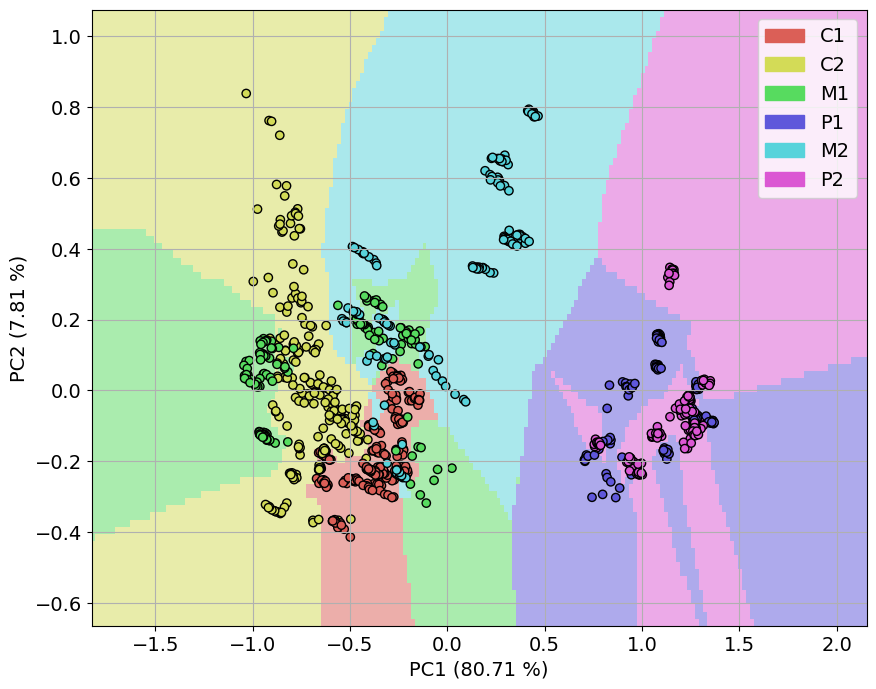

0.182762492549281


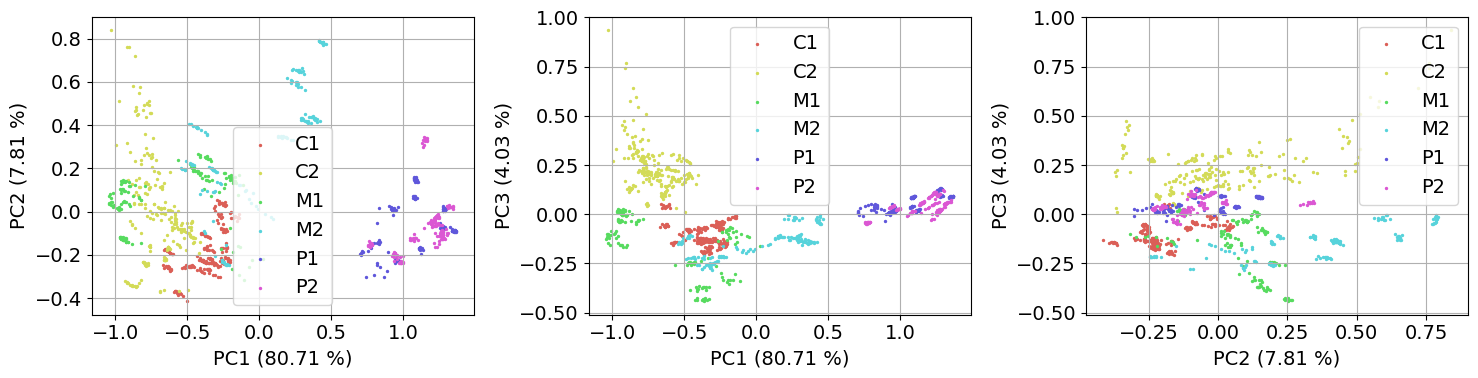

In [35]:
# Fluid pump spectral
project_classes(pump['X_fd'], pump['Y']['target'], boundary=True)
project_classes_3d(pump['X_fd'], pump['Y']['target'])

0.15354708005073503


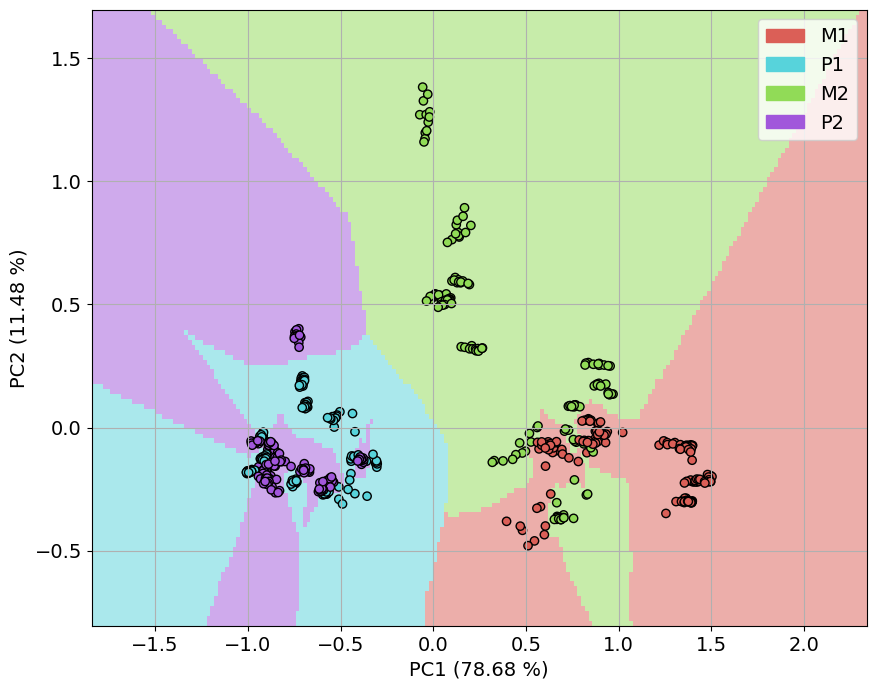

In [36]:
project_classes(pump['X_fd'], pump['Y']['label_machine'], boundary=True)

0.21057671770638844


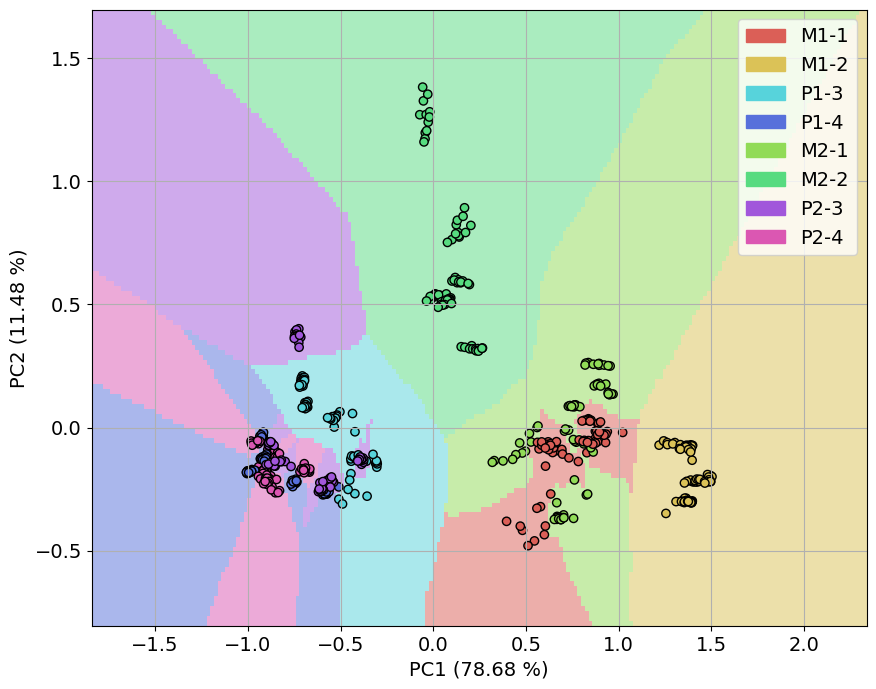

In [37]:
project_classes(pump['X_fd'], pump['Y']['label_position'], boundary=True)

0.18218405485253084


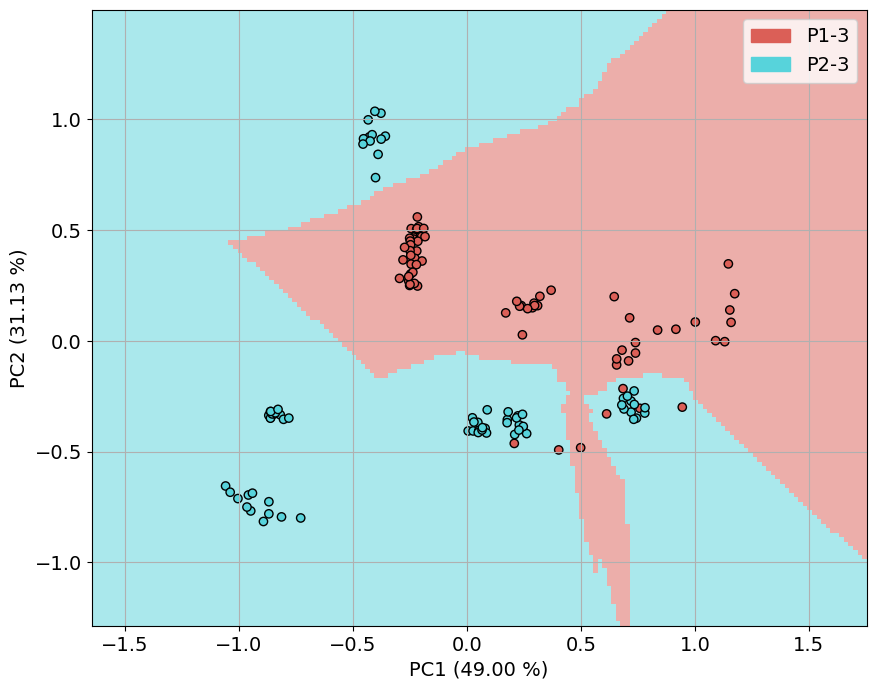

In [38]:
project_classes(pump['X_fd'], pump['Y']['label_binary'], boundary=True)

In [39]:

def visualize_machines(features: pd.DataFrame, labels: pd.DataFrame, machines: tuple):
    m = features.copy()
    columns = m.columns
    m['target'] = labels.astype('str')
    m = m[m['target'].isin(machines)].reset_index(drop=True)
    m['target'] = m['target'].astype('category')

    X = m[columns].copy()
    Y = m['target']
    project_classes(X, Y, boundary=True)
    project_classes_3d(X, Y)


0.40684470733248285


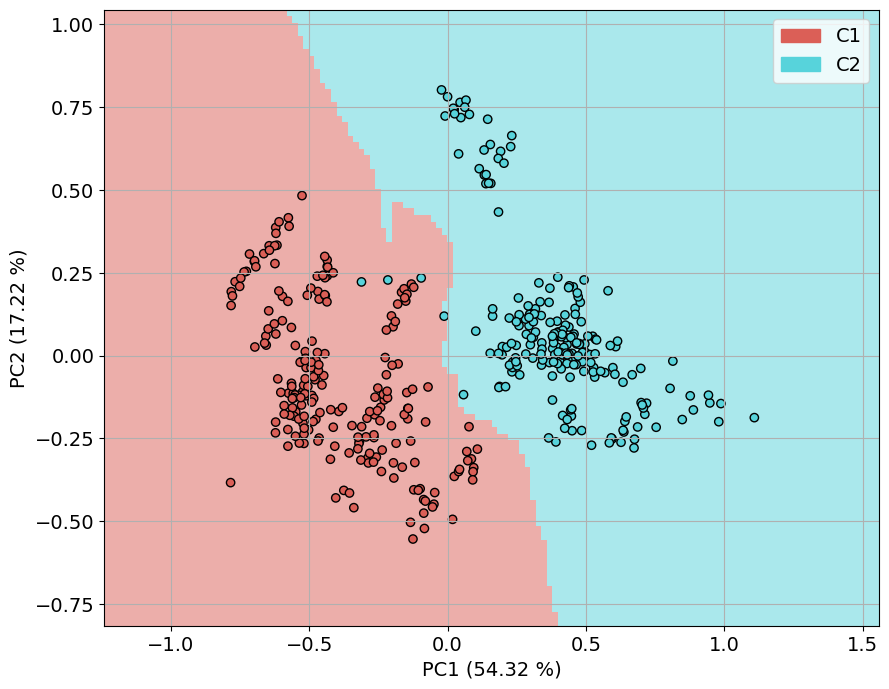

0.40684470733248285


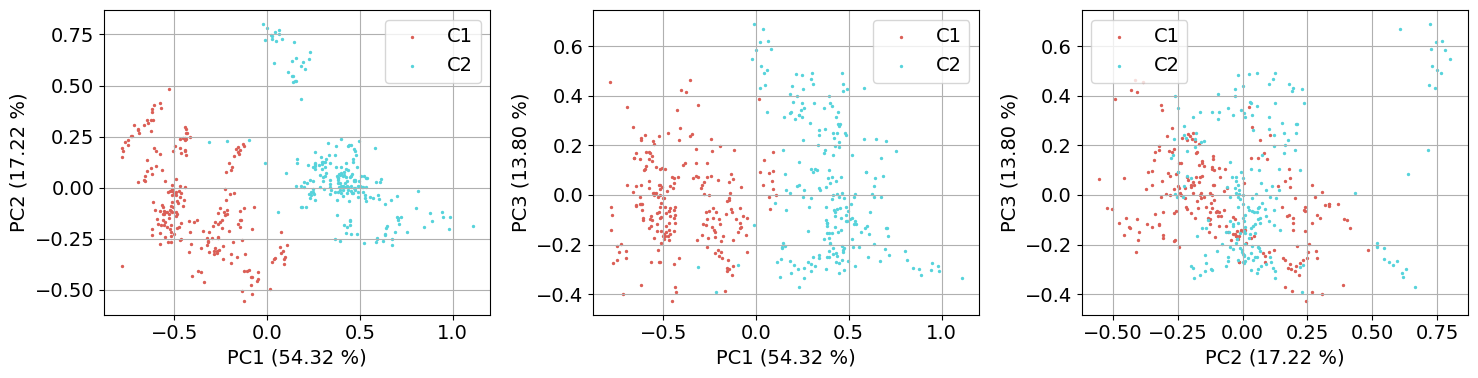

0.3721944431144749


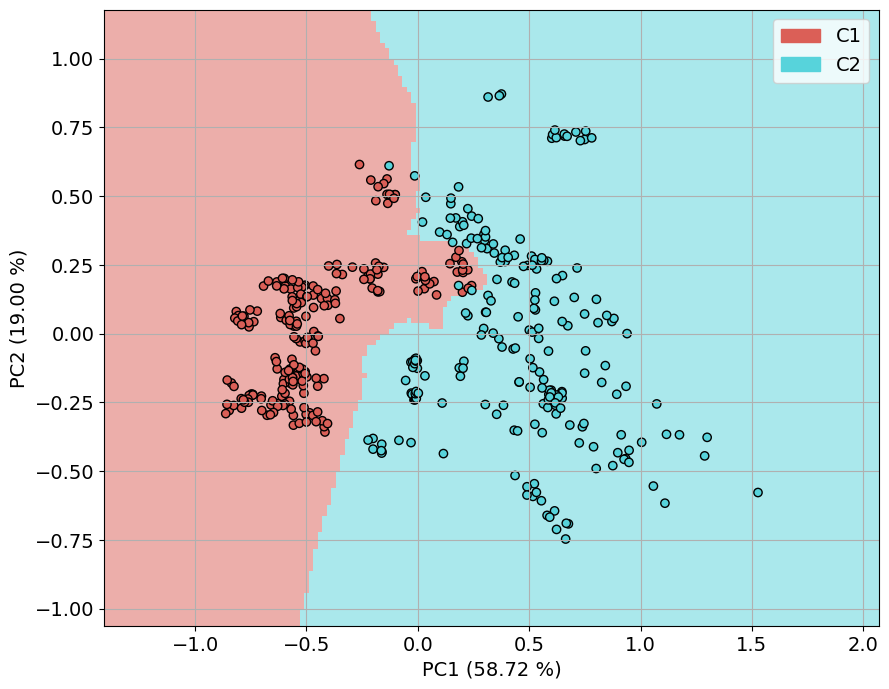

0.3721944431144749


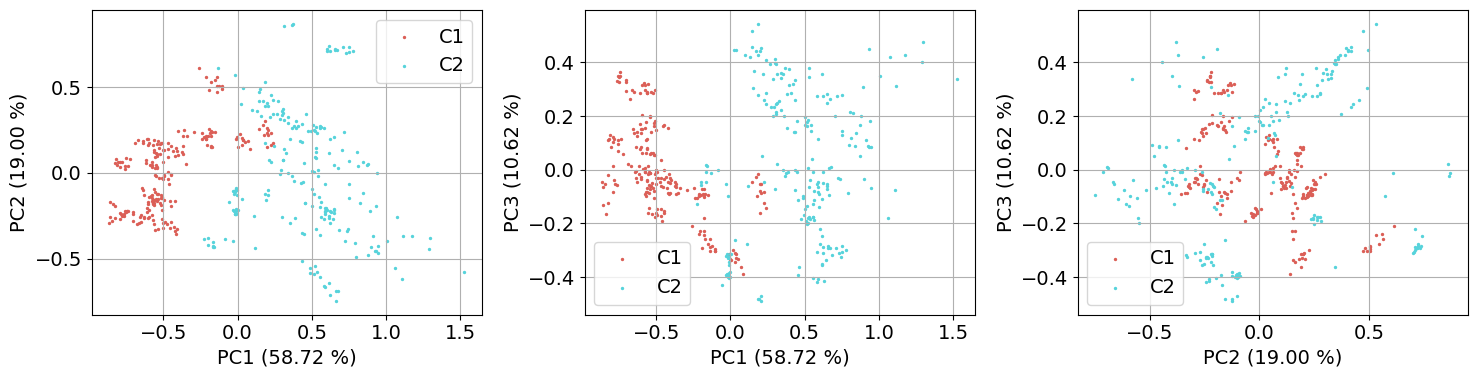

In [40]:
compressors = ('C1', 'C2')
visualize_machines(pump['X_td'], pump['Y']['target'], compressors)
visualize_machines(pump['X_fd'], pump['Y']['target'], compressors)

0.07525868680133481


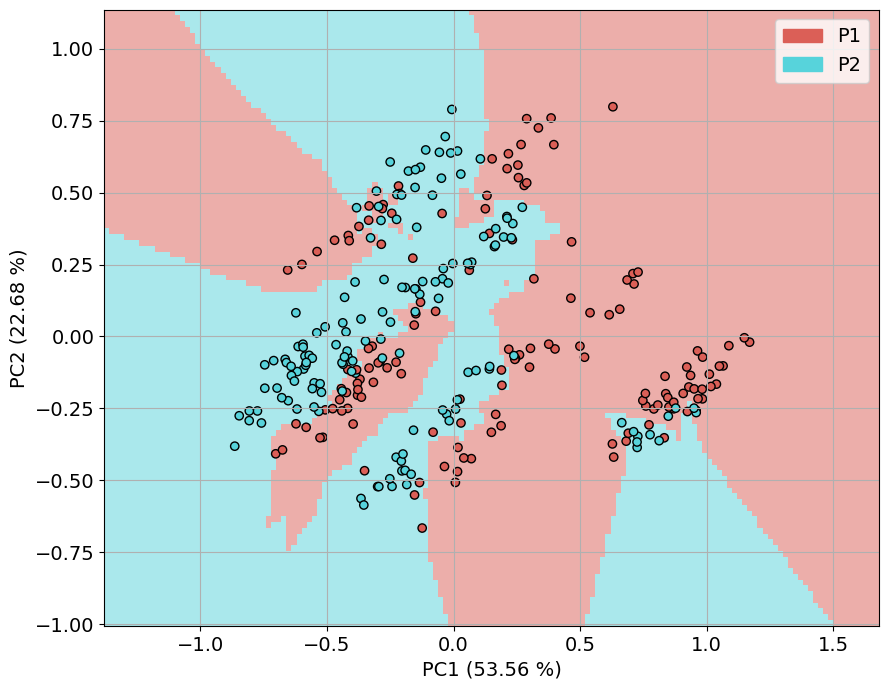

0.07525868680133481


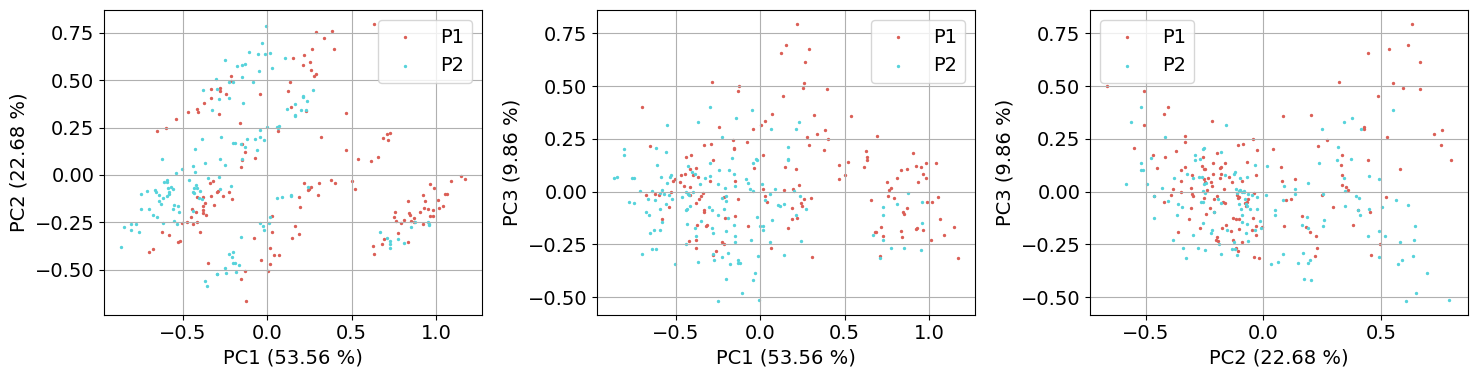

0.07506271022875227


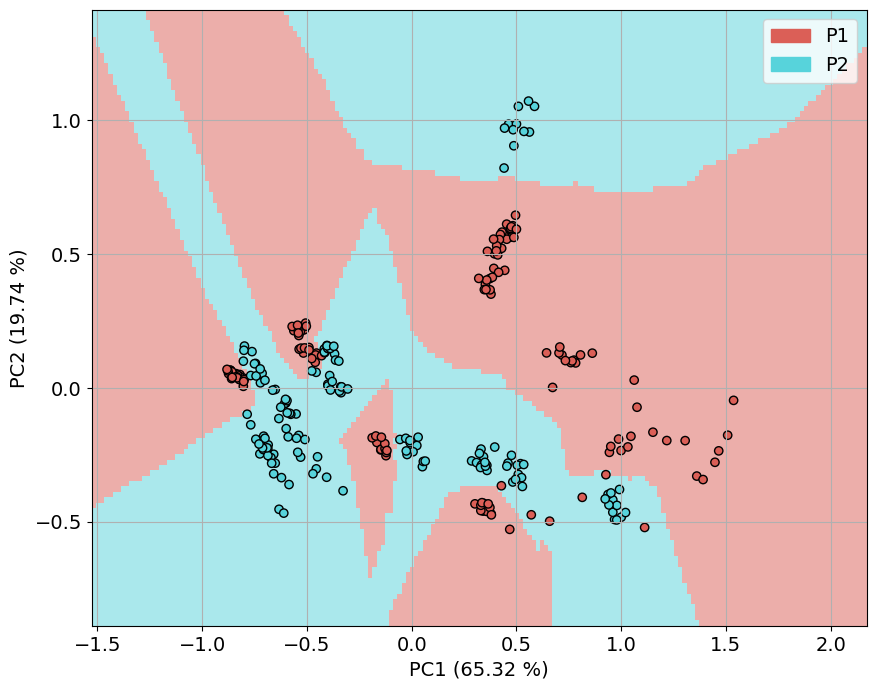

0.07506271022875227


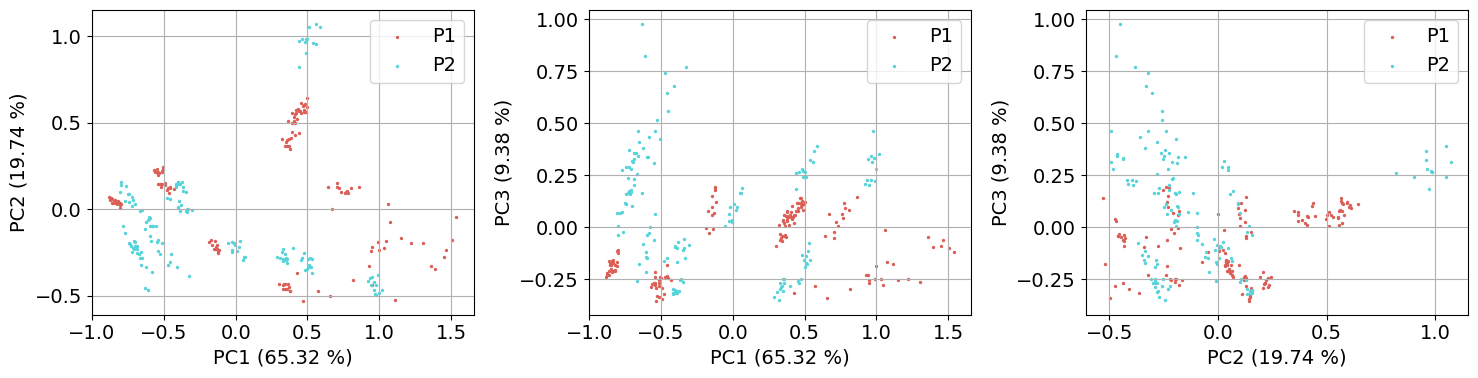

In [41]:
waterpumps = ('P1', 'P2')
visualize_machines(pump['X_td'], pump['Y']['target'], waterpumps)
visualize_machines(pump['X_fd'], pump['Y']['target'], waterpumps)

0.27177964605076377


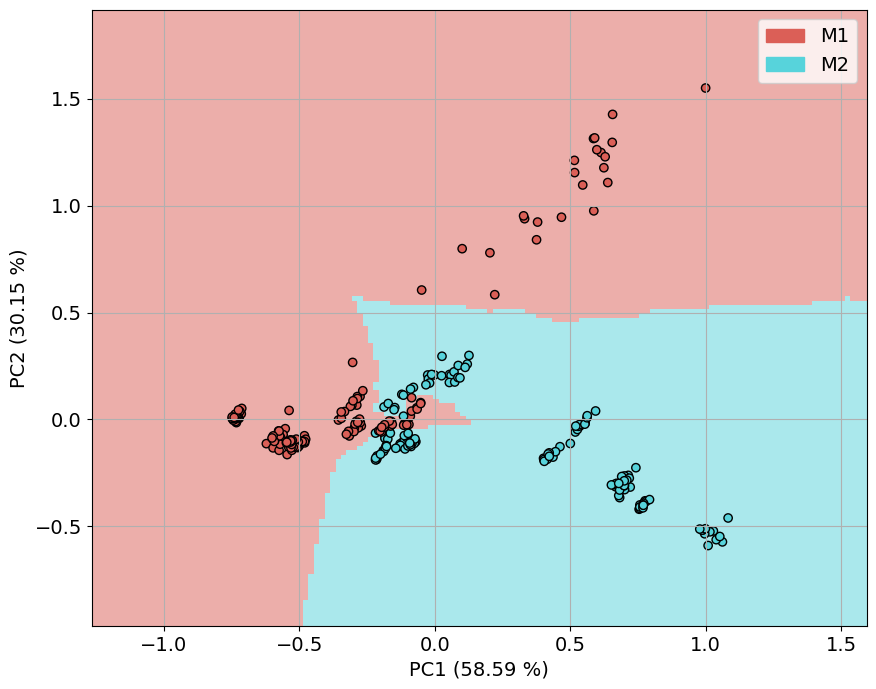

0.27177964605076377


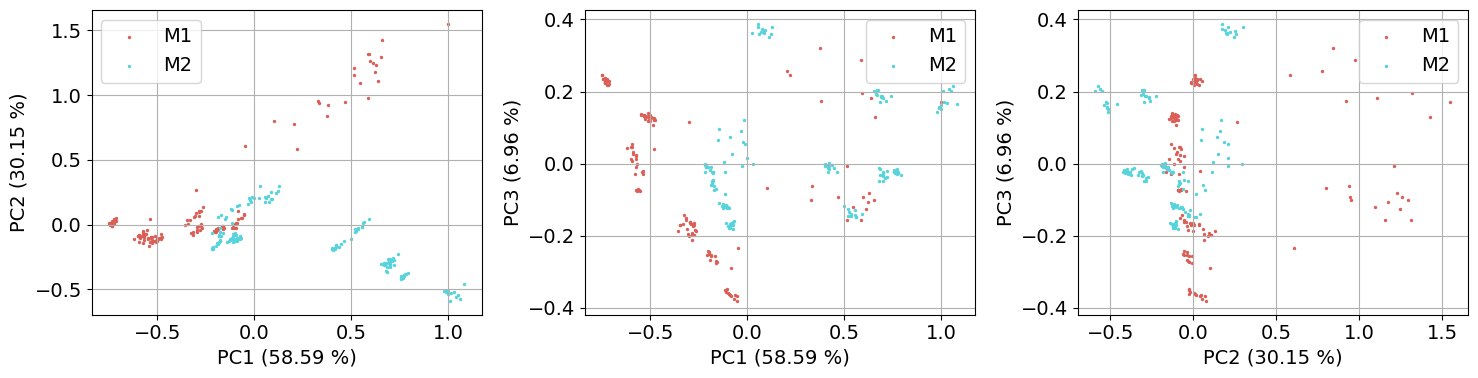

0.2611781207259944


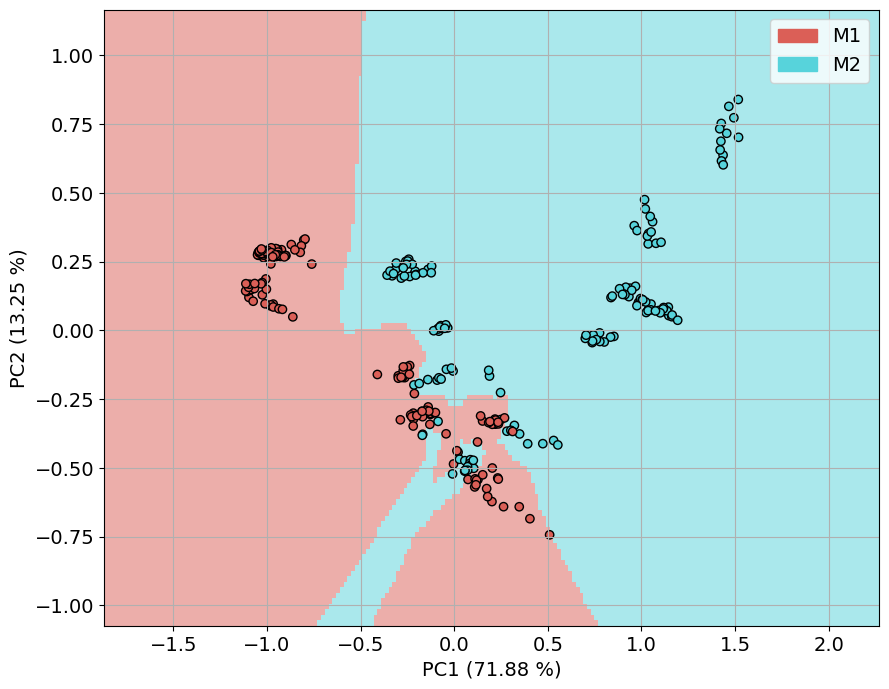

0.2611781207259944


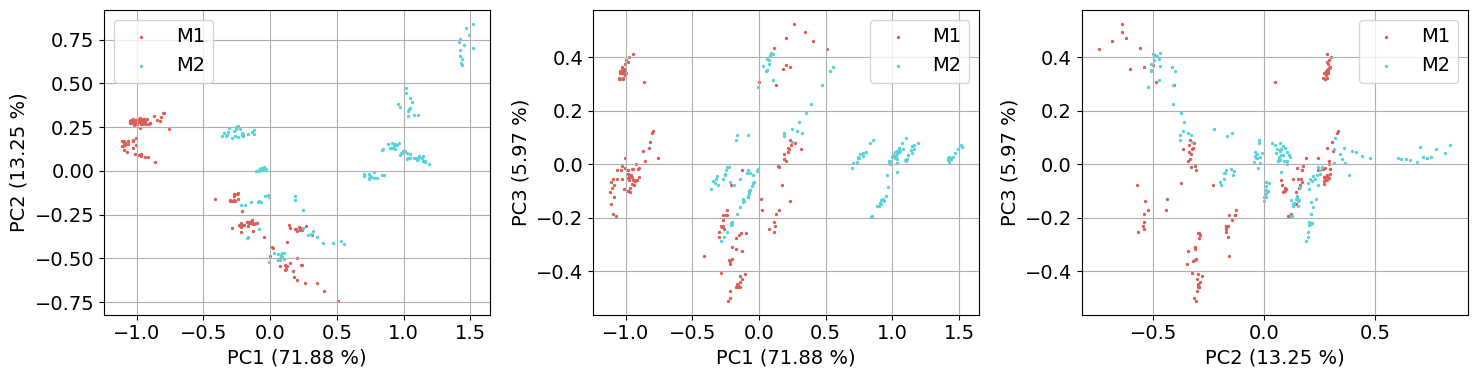

In [42]:
motors = ('M1', 'M2')
visualize_machines(pump['X_td'], pump['Y']['target'], motors)
visualize_machines(pump['X_fd'], pump['Y']['target'], motors)

#### Change in compressors features over time
- Each domain (2x)
    - Scatter plot PCA - position - colors are dates

In [43]:
def visualize_compressors_by_date(X, Y):
    for placement, rows in Y[Y['device'].isin(('K3', 'K5'))].groupby(by=['device', 'position']):
        idx = list(rows.index)
        rows['date'] = rows['date'].astype('category')
        print(placement)
        project_classes(X, rows['date'], boundary=True)

('K3', '001')
0.19567241826059636


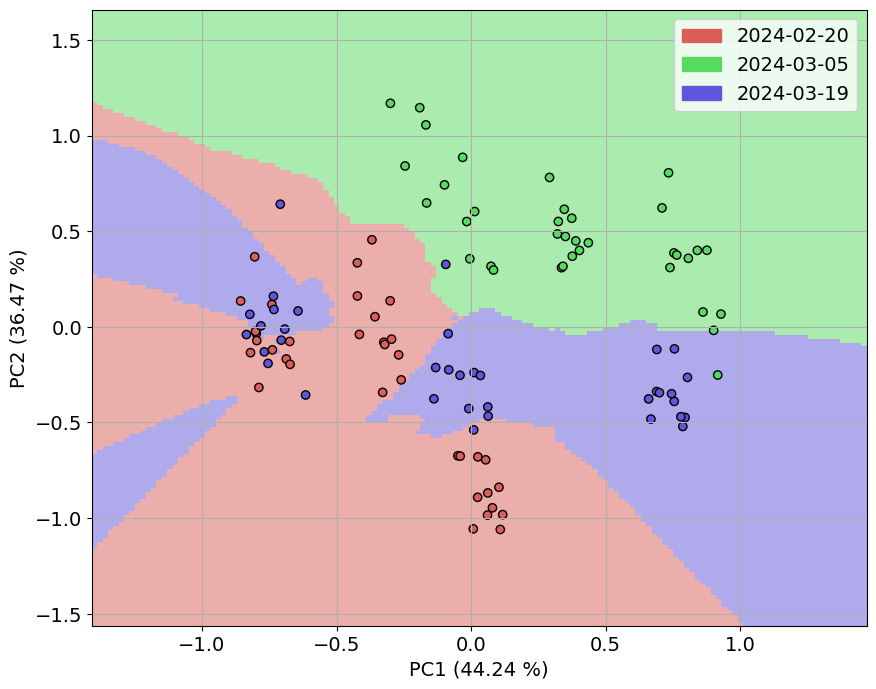

('K3', '002')
0.17654418713118805


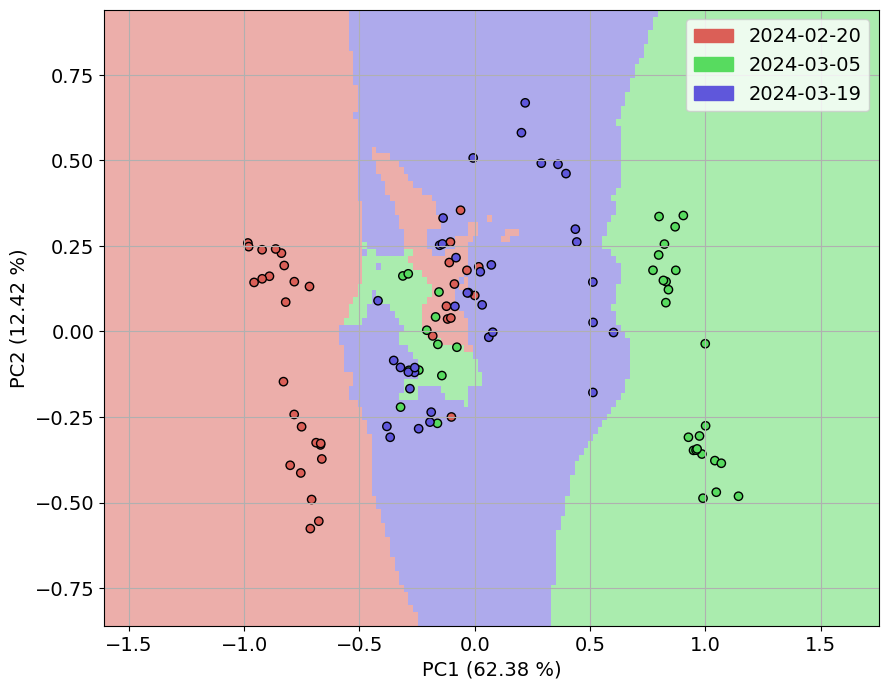

('K5', '001')
0.07016247831680278


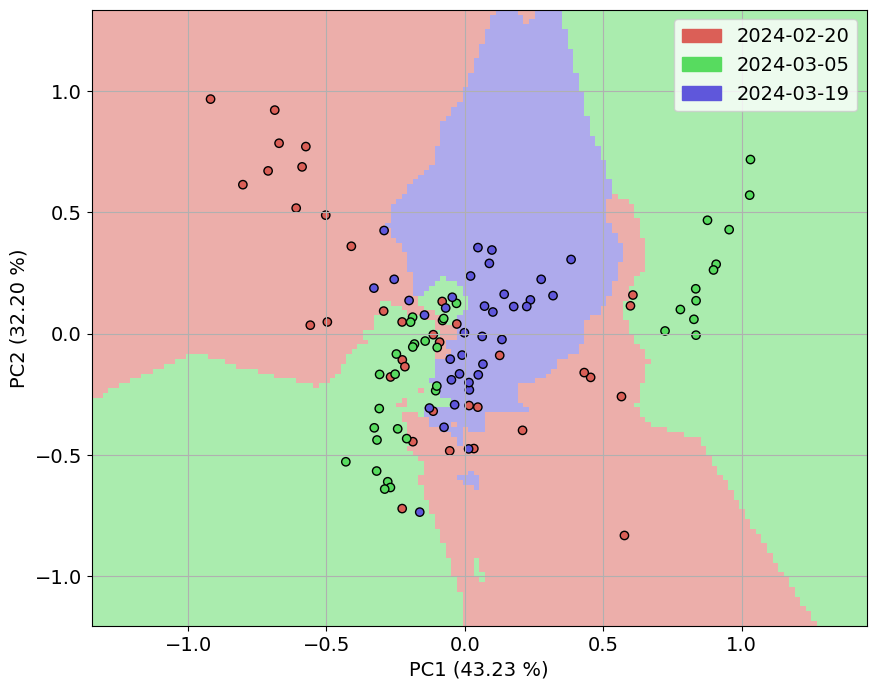

('K5', '002')
0.14390266813752153


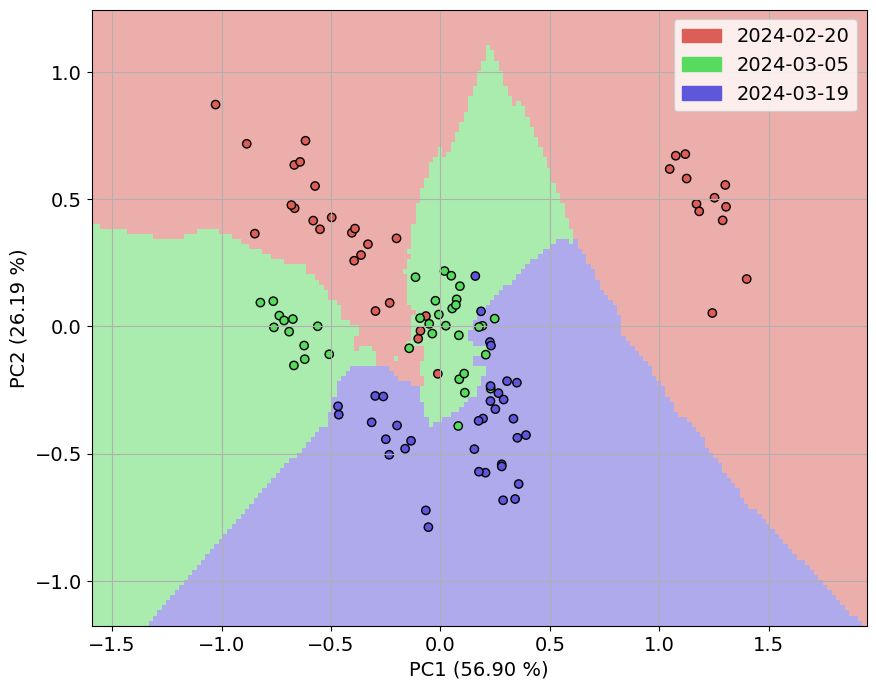

In [44]:
visualize_compressors_by_date(pump['X_td'], pump['Y'])

('K3', '001')
0.10346787722305503


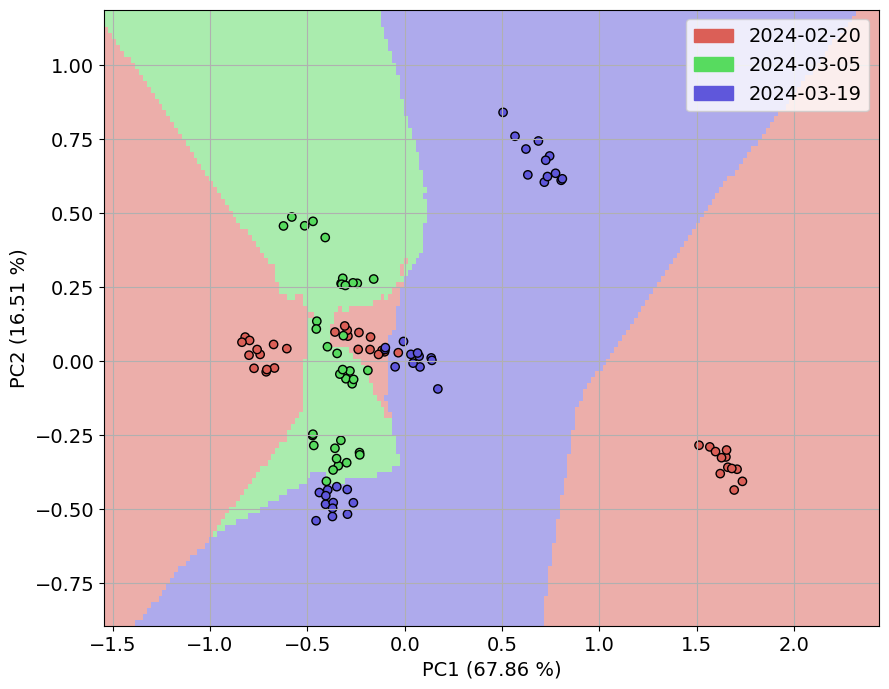

('K3', '002')
0.27204236051514763


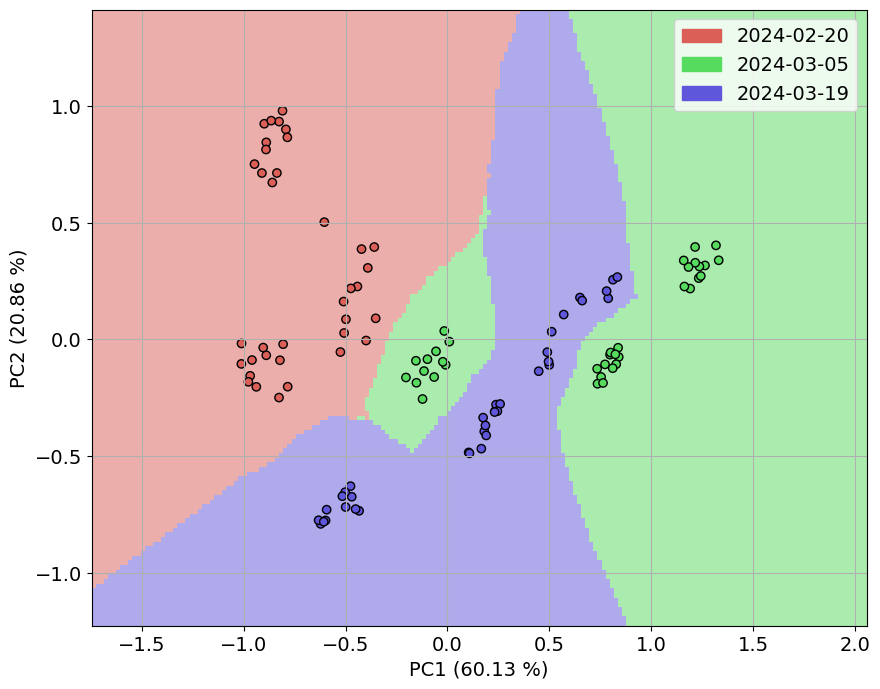

('K5', '001')
0.11130754197394681


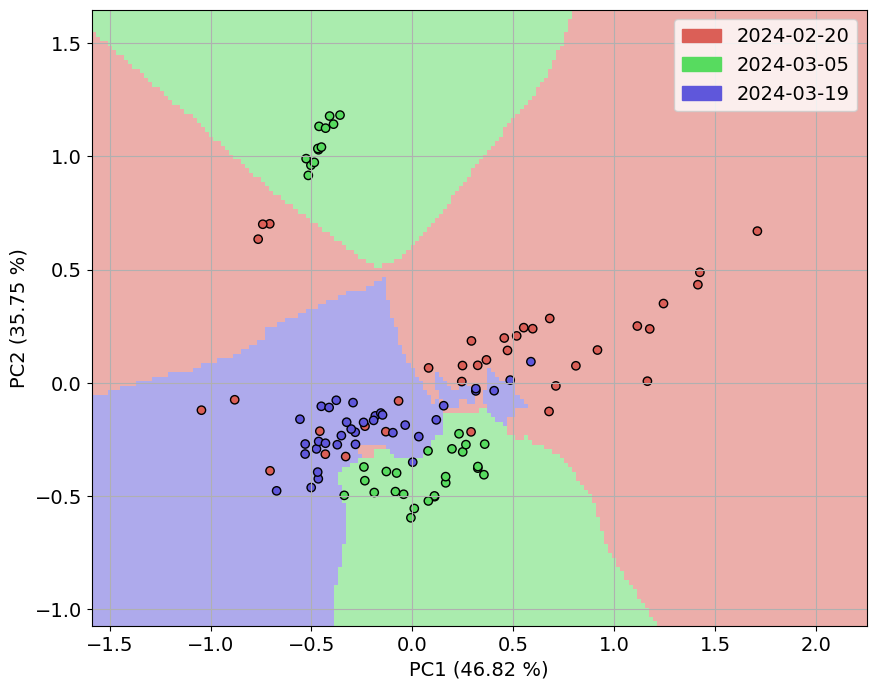

('K5', '002')
0.27497322248923595


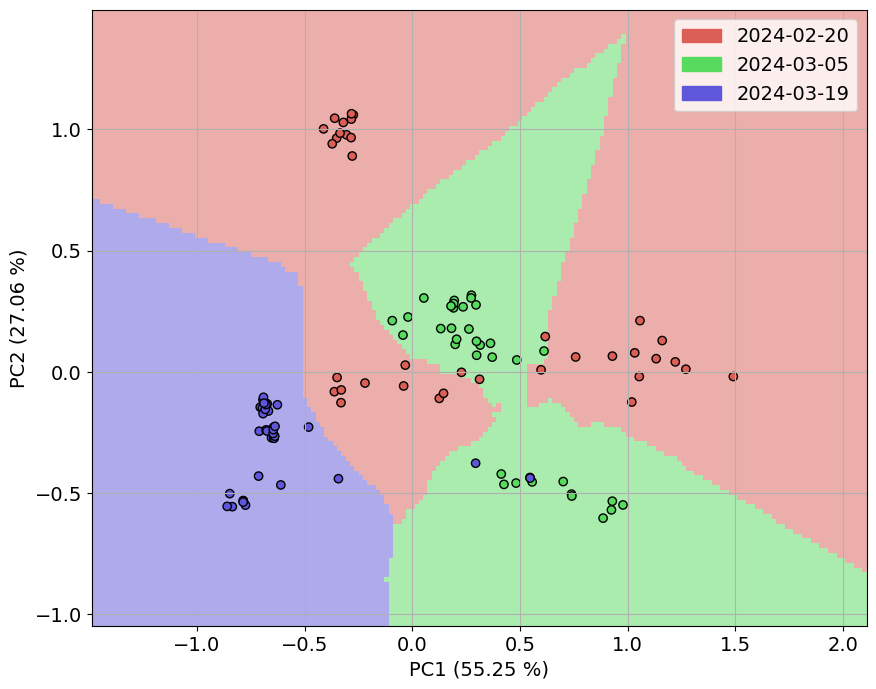

In [45]:
visualize_compressors_by_date(pump['X_fd'], pump['Y'])

#### Classification accuracy 
- choices of k. and feat. count, 5-fold cross validation

- All features 
    - for mafaulda and custom (which classes - all or just one machine)
    - 1 ks All features (2x subplots TD, FD)
	    - Each lineplot (k = 3,5,7)

In [46]:
def kfold_accuracy(X, Y, k_neighbors, kfolds, model_name):
    # Remove missing data
    Y = Y.dropna()
    X = X[X.index.isin(Y.index)]
    Y = Y[Y.index.isin(X.index)].astype('category')

    # Class balancing
    oversample = RandomOverSampler(sampling_strategy='not majority', random_state=10)
    X, Y = oversample.fit_resample(X, Y.to_numpy())
    X.reset_index(drop=True, inplace=True)
    Y = pd.Series(Y)

    kf = KFold(n_splits=kfolds, shuffle=True, random_state=10)
    round_train_acc = []
    round_test_acc = []

    for train_idx, test_idx in kf.split(X, Y):
        # Train / Test split in KFold
        x_train, x_test, y_train, y_test = (
            X.loc[train_idx].copy(), X.loc[test_idx].copy(),
            Y.loc[train_idx].copy(), Y.loc[test_idx].copy()
        )
        # Scale
        scaler = MinMaxScaler()
        x_train[x_train.columns] = scaler.fit_transform(x_train)
        x_test[x_test.columns] = scaler.transform(x_test)
    
        # Train k-NN model on all features
        if model_name == 'knn':
            model = KNeighborsClassifier(n_neighbors=k_neighbors, metric=KNN_METRIC)#, algorithm='kd_tree')
        elif model_name == 'lda':
            model = LinearDiscriminantAnalysis()
        elif model_name == 'bayes':
            model = GaussianNB()
        elif model_name == 'svm':
            model = LinearSVC()

        model.fit(x_train, y_train)
        y_predict_train = model.predict(x_train)
        y_predict_test = model.predict(x_test)

        round_train_acc.append(metrics.accuracy_score(y_train, y_predict_train))
        round_test_acc.append(metrics.accuracy_score(y_test, y_predict_test))
    
    return {
        'train': np.array(round_train_acc).mean(),
        'test': np.array(round_test_acc).mean()
    }


def all_features(X, Y, model, k_neighbors=tuple(range(1, 40, 4)), kfold_param=5) -> dict:
    # Remove missing data
    Y = Y.dropna()
    X = X[X.index.isin(Y.index)]
    Y = Y[Y.index.isin(X.index)].astype('category')

    # Class balancing
    oversample = RandomOverSampler(sampling_strategy='not majority', random_state=10)
    X, Y = oversample.fit_resample(X, Y.to_numpy())
    X.reset_index(drop=True, inplace=True)
    Y = pd.Series(Y)

    train_accuracy = []
    test_accuracy = []

    for k in k_neighbors:
        accuracy = kfold_accuracy(X, Y, k, kfold_param, model)
        train_accuracy.append(accuracy['train'])
        test_accuracy.append(accuracy['test'])

    return {
        'k': k_neighbors,
        'train': train_accuracy,
        'test': test_accuracy
    }

def plot_all_knn(td_results, fd_results, kfold=5):
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    ax.plot(td_results['k'], td_results['train'], marker='x', color='darkblue', label='train - temporal')
    ax.plot(td_results['k'], td_results['test'], marker='x', color='blue', label='test - temporal')

    ax.plot(fd_results['k'], fd_results['train'], marker='x', color='darkgreen', label='train - spectral')
    ax.plot(fd_results['k'], fd_results['test'], marker='x', color='green', label='test - spectral')

    ax.set_ylabel(f'Accuracy')
    ax.set_xlabel('K-neighbors')
    ax.set_xticks(td_results['k'])
    ax.grid(True)
    ax.legend()
    plt.show()

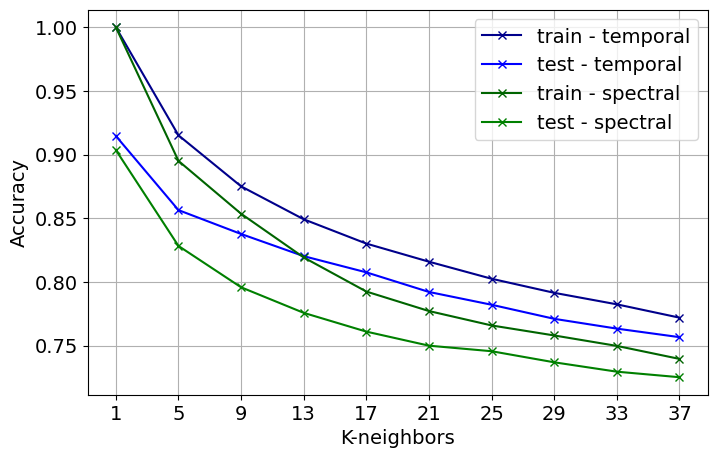

In [47]:
td_results = all_features(mafaulda['X_td'], mafaulda['Y']['target'], MODEL_TYPE)
fd_results = all_features(mafaulda['X_fd'], mafaulda['Y']['target'], MODEL_TYPE)
plot_all_knn(td_results, fd_results)

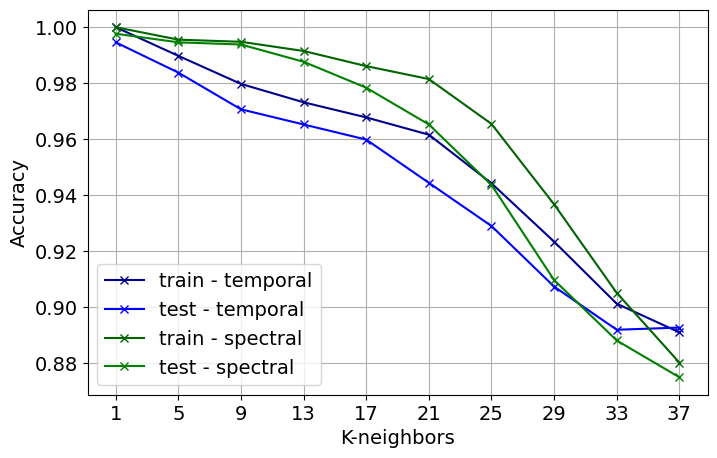

In [48]:
td_results = all_features(pump['X_td'], pump['Y']['target'], MODEL_TYPE)
fd_results = all_features(pump['X_fd'], pump['Y']['target'], MODEL_TYPE)
plot_all_knn(td_results, fd_results)

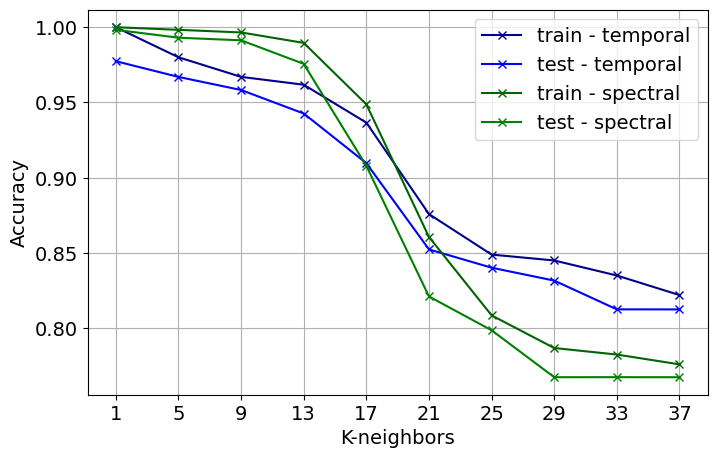

In [49]:
td_results = all_features(pump['X_td'], pump['Y']['label_machine'], MODEL_TYPE)
fd_results = all_features(pump['X_fd'], pump['Y']['label_machine'], MODEL_TYPE)
plot_all_knn(td_results, fd_results)

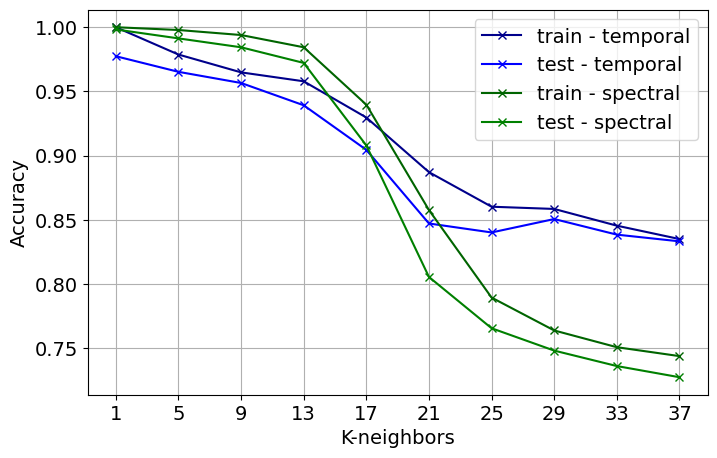

In [50]:
td_results = all_features(pump['X_td'], pump['Y']['label_position'], MODEL_TYPE)
fd_results = all_features(pump['X_fd'], pump['Y']['label_position'], MODEL_TYPE)
plot_all_knn(td_results, fd_results)

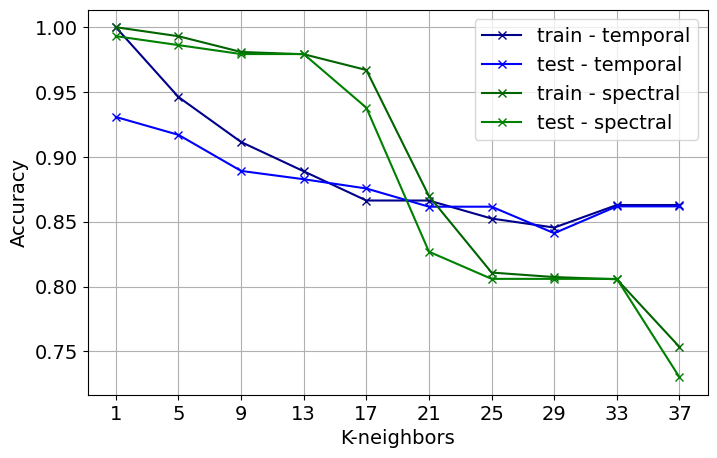

In [51]:
td_results = all_features(pump['X_td'], pump['Y']['label_binary'], MODEL_TYPE)
fd_results = all_features(pump['X_fd'], pump['Y']['label_binary'], MODEL_TYPE)
plot_all_knn(td_results, fd_results)

- All models (Exhausive) 
    - draw rank, corr, f-stat, mi as horizontal line
    - 3 ks plots (2, 3, 4 features)
	    - Each plot 2 boxplot subplots (TD, FD) - k-neigh. vs. accuracy of all models

In [52]:
def feature_combinations(
        X: pd.DataFrame,
        Y: pd.DataFrame,
        k_neighbors: int,
        num_of_features: int,
        kfolds: int,
        domain: str,
        model: str) -> list:
    
    results = []
    for features in tqdm(itertools.combinations(X.columns, r=num_of_features)):
        r = kfold_accuracy(X[list(features)], Y, k_neighbors, kfolds, model)
        r.update({'features': list(features), 'f': num_of_features, 'k': k_neighbors, 'domain': domain})
        results.append(r)
    return results


def enumerate_models(
        X_temporal: pd.DataFrame,
        X_spectral: pd.DataFrame,
        Y: pd.DataFrame,
        k_neighbors: Tuple[int] = (3, 5, 11, 15),
        num_of_features: Tuple[int] = (2, 3, 4, 5), 
        kfolds=5,
        model='knn') -> pd.DataFrame:

    models = []
    domains = {'temporal': X_temporal, 'spectral': X_spectral}

    for fnum in num_of_features:
        for domain, X in domains.items():
            for k in k_neighbors:
                result = feature_combinations(X, Y, k, fnum, kfolds, domain, model)
                models.extend(result)
                
    return pd.DataFrame.from_records(models)

In [53]:
# 6156 models (120/165, 210/330, 252/462), 25 minutes (longer because of oversampling)
mafaulda_models_summary = enumerate_models(mafaulda['X_td'], mafaulda['X_fd'], mafaulda['Y']['target'], model=MODEL_TYPE)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [54]:
#mafaulda_models_summary.to_csv('mafaulda_models_summary.csv')
mafaulda_models_summary

train      test                                           features  \
0     0.866466  0.722904                                    [zerocross, pp]   
1     0.857012  0.718214                                   [zerocross, aac]   
2     0.872072  0.726924                                   [zerocross, rms]   
3     0.819613  0.631189                              [zerocross, skewness]   
4     0.809238  0.602753                              [zerocross, kurtosis]   
...        ...       ...                                                ...   
6551  0.775183  0.734277    [roll_off, flux, noisiness, energy, negentropy]   
6552  0.803213  0.766407   [roll_off, flux, noisiness, entropy, negentropy]   
6553  0.792670  0.754354      [roll_off, flux, energy, entropy, negentropy]   
6554  0.778532  0.737288  [roll_off, noisiness, energy, entropy, negentr...   
6555  0.747406  0.707165     [flux, noisiness, energy, entropy, negentropy]   

      f   k    domain  
0     2   3  temporal  
1     2   3  temporal  
2     2   3  temporal  
3     2   3  temporal  
4     2   3  temporal  
...  ..  ..       ...  
6551  5  15  spectral  
6552  5  15  spectral  
6553  5  15  spectral  
6554  5  15  spectral  
6555  5  15  spectral  

[6556 rows x 6 columns]

In [55]:
#pump_models_summary_machine = enumerate_models(pump['X_td'], pump['X_fd'], pump['Y']['label_machine'], model=MODEL_TYPE)

In [56]:
#pump_models_summary_position = enumerate_models(pump['X_td'], pump['X_fd'], pump['Y']['label_position'], model=MODEL_TYPE)

In [57]:
#pump_models_summary_binary = enumerate_models(pump['X_td'], pump['X_fd'], pump['Y']['label_binary'], model=MODEL_TYPE)

In [58]:
def boxplot_enumerate_models_accuracy(results, metric, plots_col, inplot_col):
    for fnum, features in results.groupby(by=plots_col):
        fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
        for i, group in enumerate(features.groupby(by='domain', sort=False)):
            domain_name, domain = group 
            ax[i].grid()
            
            if plots_col == 'k':
                ax[i].set_title(f'K-neighbors: {fnum}, Domain: {domain_name}')
            if plots_col == 'f':
                ax[i].set_title(f'Features: {fnum}, Domain: {domain_name}')

            boxplot_data = {}
            for k, models in domain.groupby(by=[inplot_col]):
                boxplot_data[k[0]] = models[metric].to_list()

            ax[i].boxplot(
                boxplot_data.values(),
                labels=boxplot_data.keys(),
                medianprops = {'linewidth': 2, 'color': 'black'})
            ax[i].set_ylabel('Accuracy')
            if plots_col == 'f':
                ax[i].set_xlabel('K-neighbors')
            if plots_col == 'k':
                ax[i].set_xlabel('Number of features')
    plt.show()

#### MaFaulDa

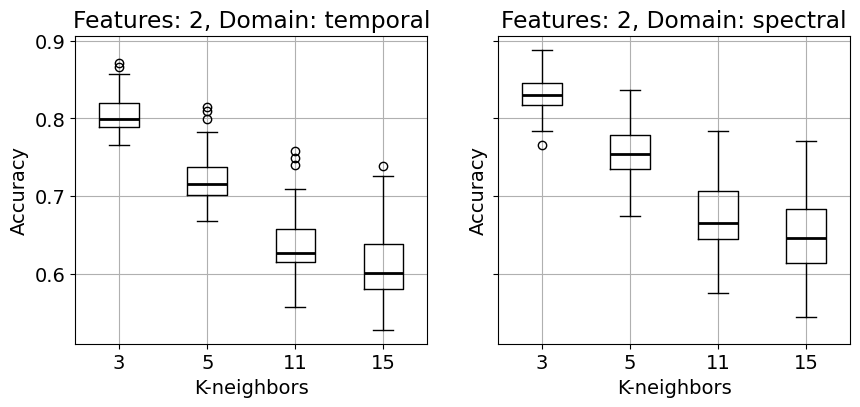

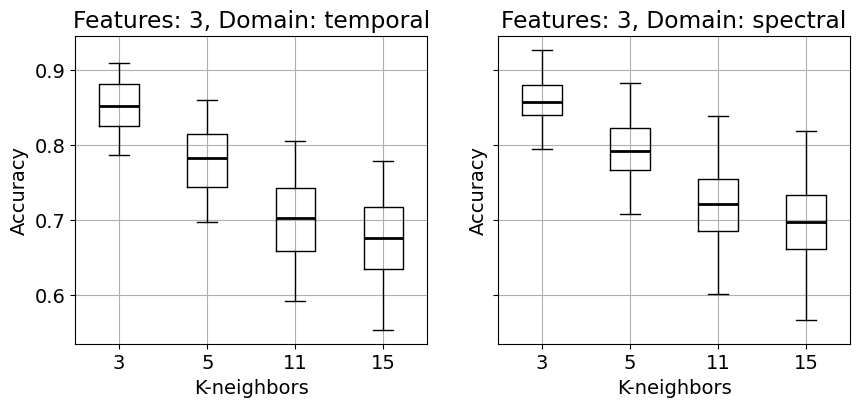

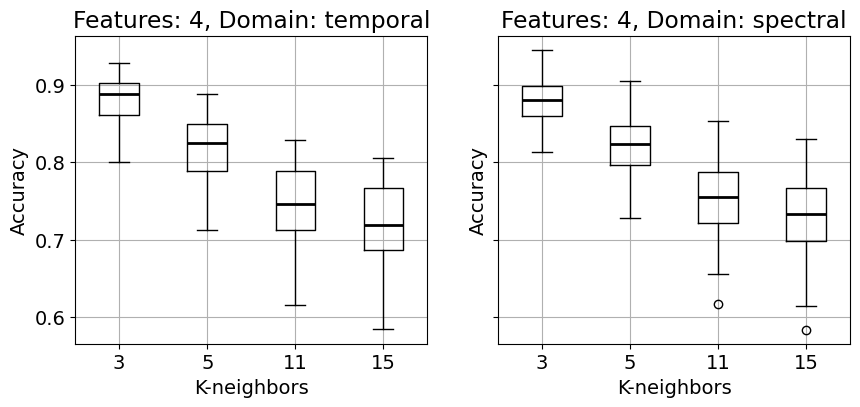

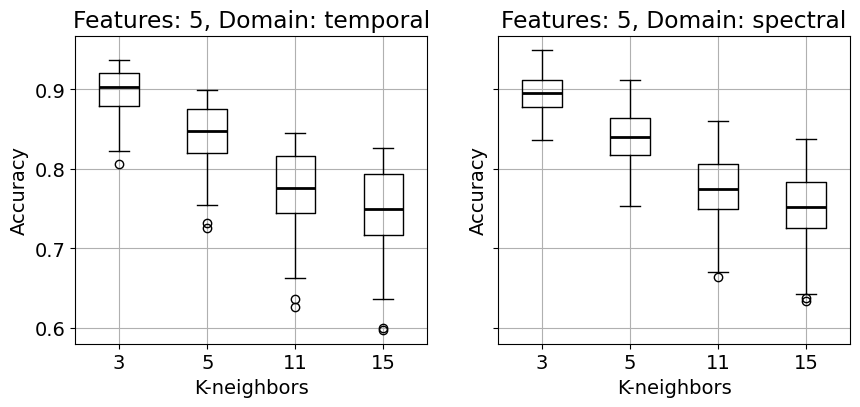

In [59]:
boxplot_enumerate_models_accuracy(mafaulda_models_summary, 'train', 'f', 'k')

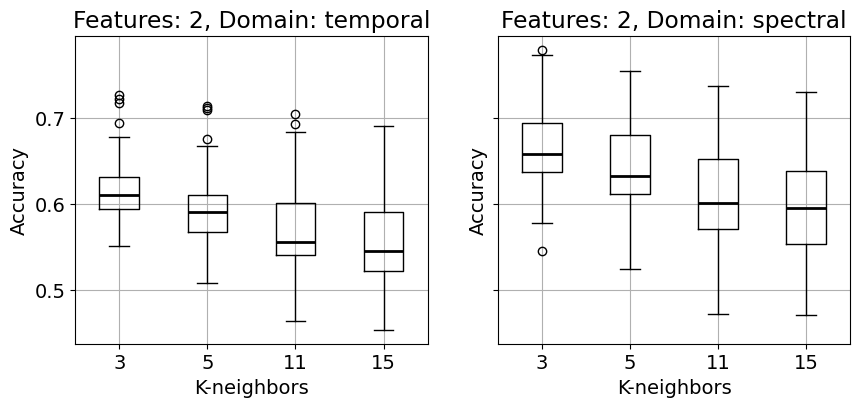

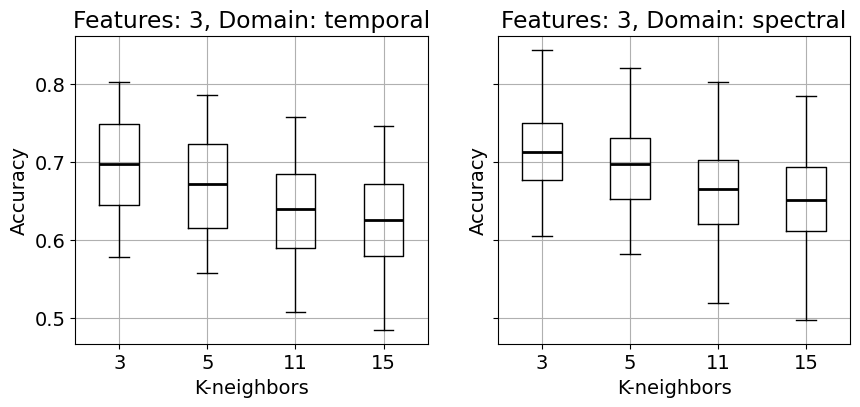

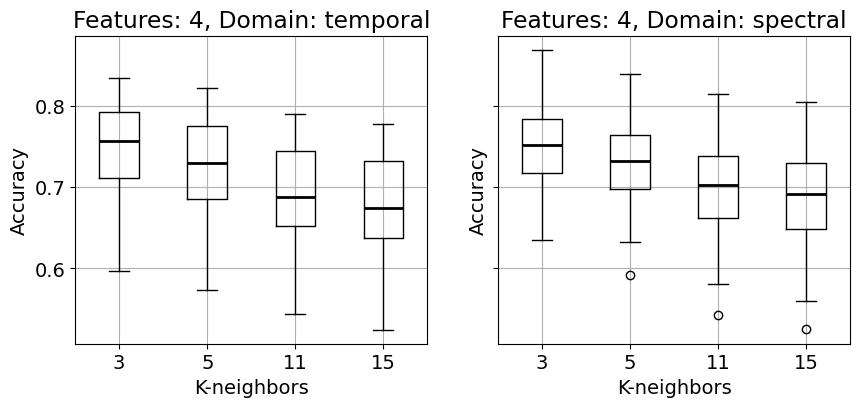

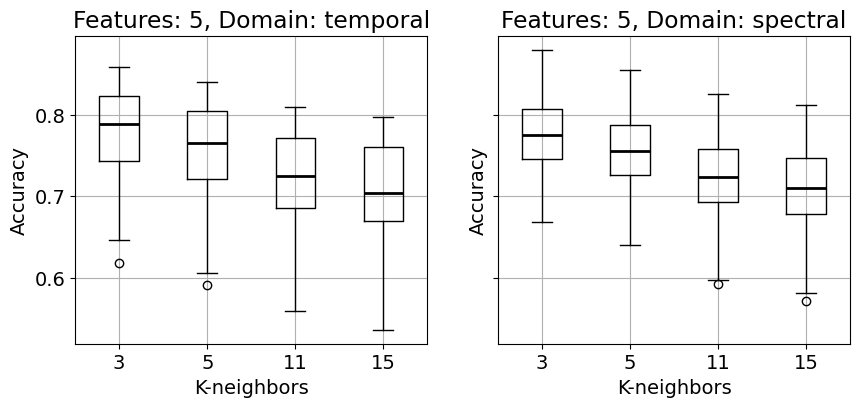

In [60]:
boxplot_enumerate_models_accuracy(mafaulda_models_summary, 'test', 'f', 'k')

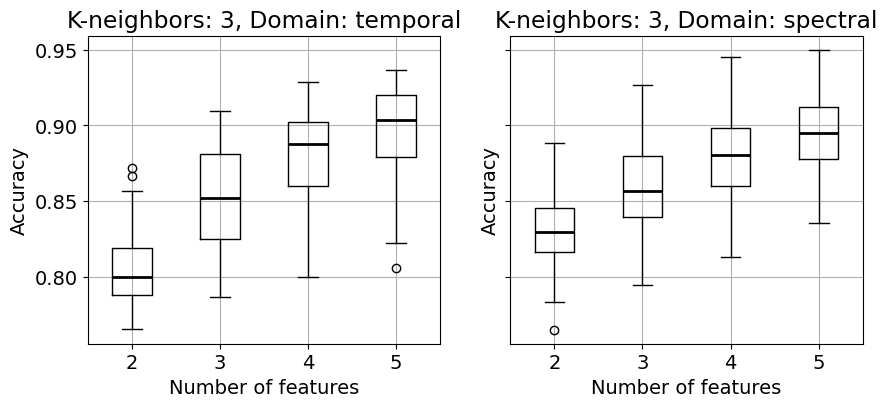

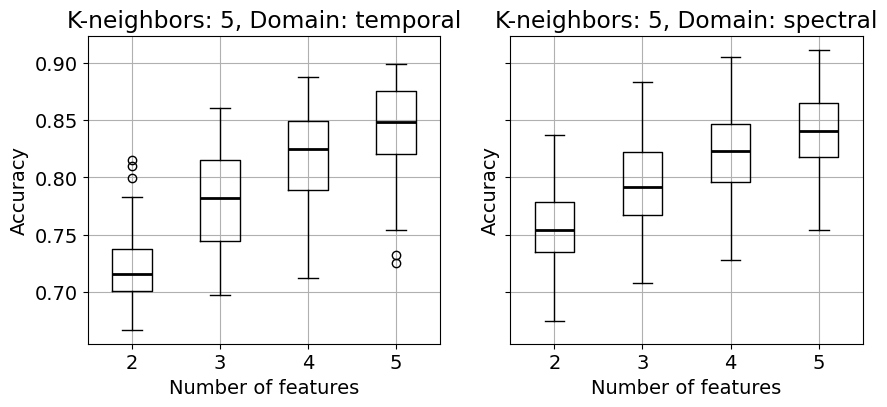

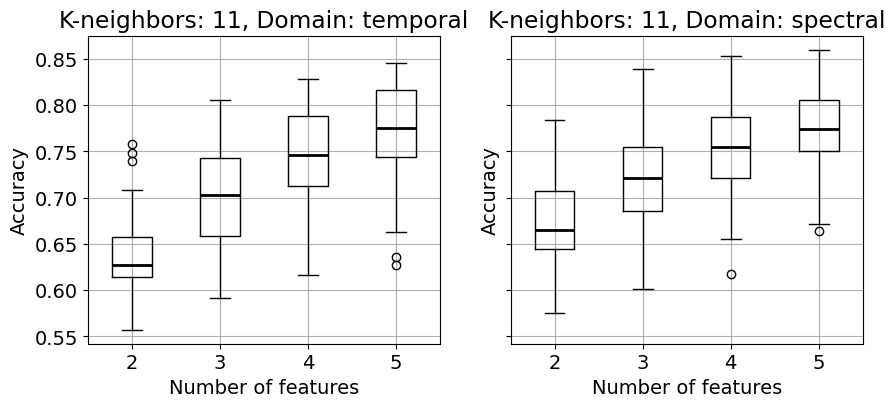

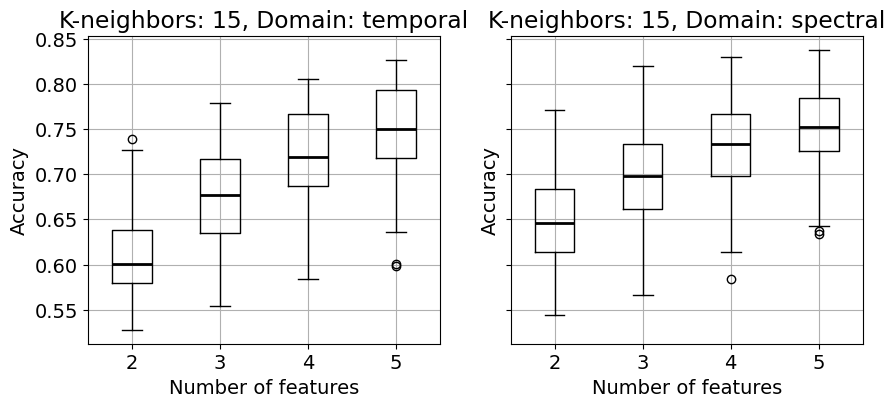

In [61]:
boxplot_enumerate_models_accuracy(mafaulda_models_summary, 'train', 'k', 'f')

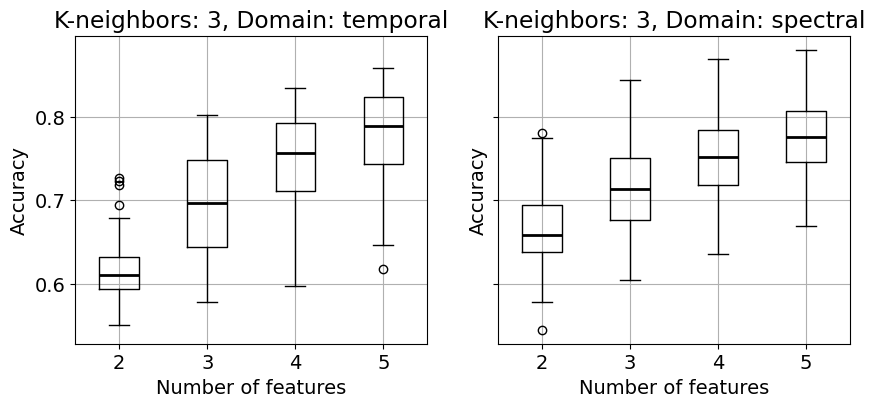

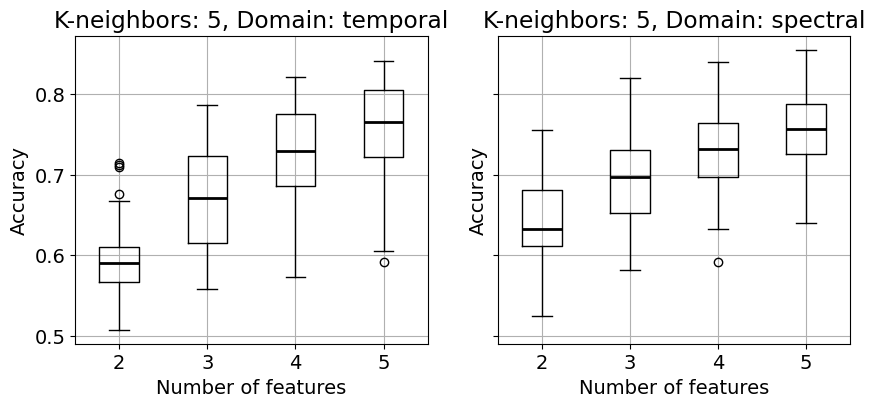

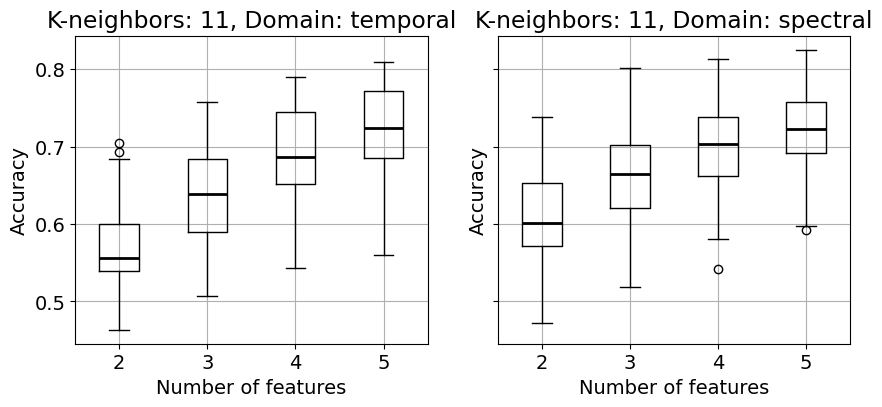

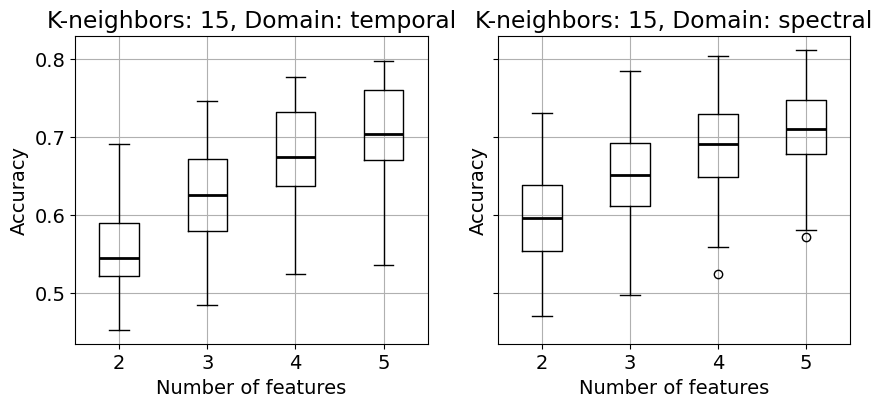

In [62]:
boxplot_enumerate_models_accuracy(mafaulda_models_summary, 'test', 'k', 'f')

#### Water pumps

Machines

In [63]:
#boxplot_enumerate_models_accuracy(pump_models_summary_machine, 'train', 'f', 'k')

In [64]:
#boxplot_enumerate_models_accuracy(pump_models_summary_machine, 'test', 'f', 'k')

In [65]:
#boxplot_enumerate_models_accuracy(pump_models_summary_machine, 'train', 'k', 'f')

In [66]:
#boxplot_enumerate_models_accuracy(pump_models_summary_machine, 'test', 'k', 'f')

Positions

In [67]:
#boxplot_enumerate_models_accuracy(pump_models_summary_position, 'train', 'f', 'k')

In [68]:
#boxplot_enumerate_models_accuracy(pump_models_summary_position, 'test', 'f', 'k')

In [69]:
#boxplot_enumerate_models_accuracy(pump_models_summary_position, 'train', 'k', 'f')

In [70]:
#boxplot_enumerate_models_accuracy(pump_models_summary_position, 'test', 'k', 'f')

Binary

In [71]:
#boxplot_enumerate_models_accuracy(pump_models_summary_binary, 'train', 'f', 'k')

In [72]:
#boxplot_enumerate_models_accuracy(pump_models_summary_binary, 'test', 'f', 'k')

In [73]:
#boxplot_enumerate_models_accuracy(pump_models_summary_binary, 'train', 'k', 'f')

In [74]:
#boxplot_enumerate_models_accuracy(pump_models_summary_binary, 'test', 'k', 'f')

- Compare accuracies of best models in each categories for given number of features and k:
    - 1 ks plot - bar chart - color rainbow - one x (td), second x (fd)
    - Scores side by side (bar chart)
    - best permuted, pca, rank product, corr, fstat, mi

In [75]:
from collections import Counter

def find_best_subset(X, Y, metric, members=3, kfolds=5):
    Y = Y.dropna().astype('category')
    X = X[X.index.isin(Y.index)].copy()
    Y = Y[Y.index.isin(X.index)].astype('category')
    X = X.reset_index(drop=True)
    Y = Y.reset_index(drop=True)

    kf = KFold(n_splits=kfolds, shuffle=True, random_state=10)
    elements = []

    for train_idx, test_idx in kf.split(X, Y):
        x_train, x_test, y_train, y_test = (
            X.loc[train_idx].copy(), X.loc[test_idx].copy(),
            Y.loc[train_idx].copy(), Y.loc[test_idx].copy()
        )
        ranks = ranking.batch_feature_ranking(x_train, y_train, metric)
        if metric != 'rank':
            synonyms = ranking.compute_correlations(x_train, corr_above=0.95)
            subset = ranking.best_subset(ranks, synonyms, n=members)
            output = subset
        else:
            output = ranks

        output = list(output.reset_index().head(3)['feature'])

    return output


def transform_to_pca(X, n):
    scaler = MinMaxScaler()
    X[X.columns] = scaler.fit_transform(X)

    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X)
    X_pca = pd.DataFrame(X_pca)
    return X_pca


def plot_models_performance_bar(
        X_temporal: pd.DataFrame,
        X_spectral: pd.DataFrame, 
        Y: pd.DataFrame,
        models_summary: pd.DataFrame,
        k_neighbors: int = 5,
        number_of_features: int = 3):

    Y = Y.dropna().astype('category')
    X_temporal = X_temporal[X_temporal.index.isin(Y.index)].copy()
    X_spectral = X_spectral[X_spectral.index.isin(Y.index)].copy()
    Y = Y[Y.index.isin(X_temporal.index)].astype('category')

    X_temporal = X_temporal.reset_index(drop=True)
    X_spectral = X_spectral.reset_index(drop=True)
    Y = Y.reset_index(drop=True)
    Y = Y.cat.codes

    fig, ax = plt.subplots(1, 2, figsize=(10, 5)) 
    columns = ['train', 'test']
    kfolds = 5
    x = np.arange(len(columns))
    domains = {'temporal': X_temporal, 'spectral': X_spectral}

    for i, d in enumerate(domains.items()):
        domain, X = d 
        width = 0.13

        y_best = all_features(X, Y, MODEL_TYPE, [k_neighbors])
        y_best = [y_best['train'][0], y_best['test'][0]]
        rect = ax[i].bar(x - 3*width, y_best, width, label='All features')
        ax[i].bar_label(rect, padding=3, fmt=lambda x: f'{x * 100:.0f}')
        print('All features', y_best)

        y_best = kfold_accuracy(transform_to_pca(X, n=number_of_features), Y, k_neighbors, kfolds, MODEL_TYPE)
        y_best = [y_best['train'], y_best['test']]
        rect = ax[i].bar(x - 2*width, y_best, width, label='PCA 3 PC')
        ax[i].bar_label(rect, padding=3, fmt=lambda x: f'{x * 100:.0f}')
        print('PCA 3 PC', y_best)

        y_best = models_summary[
            (models_summary['domain'] == domain) &
            (models_summary['k'] == k_neighbors) & 
            (models_summary['f'] == number_of_features)
        ].sort_values(by='train', ascending=False).head(1).to_dict('records')[0]
        print('Best 3 features', y_best)
        y_best = [y_best['train'], y_best['test']]
        rect = ax[i].bar(x - 1*width, y_best, width, label='Best 3 features')
        ax[i].bar_label(rect, padding=3, fmt=lambda x: f'{x * 100:.0f}')
        print('Best 3 features', y_best)
   
        features = find_best_subset(X, Y, 'rank', members=number_of_features)
        y_best = kfold_accuracy(X[list(features)], Y, k_neighbors, kfolds, MODEL_TYPE)
        y_best = [y_best['train'], y_best['test']]
        rect = ax[i].bar(x - 0*width, y_best, width, label='Rank product')
        ax[i].bar_label(rect, padding=3, fmt=lambda x: f'{x * 100:.0f}')
        print('Rank product', y_best)

        features = find_best_subset(X, Y, 'corr', members=number_of_features)
        y_best = kfold_accuracy(X[list(features)], Y, k_neighbors, kfolds, MODEL_TYPE)
        y_best = [y_best['train'], y_best['test']]
        rect = ax[i].bar(x + 1*width, y_best, width, label='Correlation')
        ax[i].bar_label(rect, padding=3, fmt=lambda x: f'{x * 100:.0f}')
        print('Correlation', y_best)

        features = find_best_subset(X, Y, 'f_stat', members=number_of_features)
        y_best = kfold_accuracy(X[list(features)], Y, k_neighbors, kfolds, MODEL_TYPE)
        y_best = [y_best['train'], y_best['test']]
        rect = ax[i].bar(x + 2*width, y_best, width, label='F statistic')
        ax[i].bar_label(rect, padding=3, fmt=lambda x: f'{x * 100:.0f}')
        print('F statistic', y_best)
        
        features = find_best_subset(X, Y, 'mi', members=number_of_features)
        y_best = kfold_accuracy(X[list(features)], Y, k_neighbors, kfolds, MODEL_TYPE)
        y_best = [y_best['train'], y_best['test']]
        rect = ax[i].bar(x + 3*width, y_best, width, label='Mutual information')
        ax[i].bar_label(rect, padding=3, fmt=lambda x: f'{x * 100:.0f}')
        print('Mutual information', y_best)

        ax[i].set_xticks(x, columns)
        ax[i].legend(loc='lower right')
        ax[i].set_ylim(0.5, None)
        ax[i].set_title(domain)
        
        ax[i].set_ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

All features [0.9151612829841334, 0.8564326649972267]
PCA 3 PC [0.8540828665375212, 0.7764418525178849]
Best 3 features {'train': 0.8603573022264455, 'test': 0.7801191016397484, 'features': ['zerocross', 'aac', 'shape'], 'f': 3, 'k': 5, 'domain': 'temporal'}
Best 3 features [0.8603573022264455, 0.7801191016397484]
Rank product [0.839022834933651, 0.7610600382066408]
Correlation [0.839022834933651, 0.7610600382066408]
F statistic [0.839022834933651, 0.7610600382066408]
Mutual information [0.839022834933651, 0.7610600382066408]
All features [0.89508036587692, 0.8283138098519351]
PCA 3 PC [0.820867688980119, 0.7433090760379377]
Best 3 features {'train': 0.8830330615680488, 'test': 0.8196260006834619, 'features': ['centroid', 'roll_off', 'entropy'], 'f': 3, 'k': 5, 'domain': 'spectral'}
Best 3 features [0.8830330615680488, 0.8196260006834619]
Rank product [0.8263053745828588, 0.7389556478042386]
Correlation [0.8263053745828588, 0.7389556478042386]
F statistic [0.8242972513732634, 0.7439751

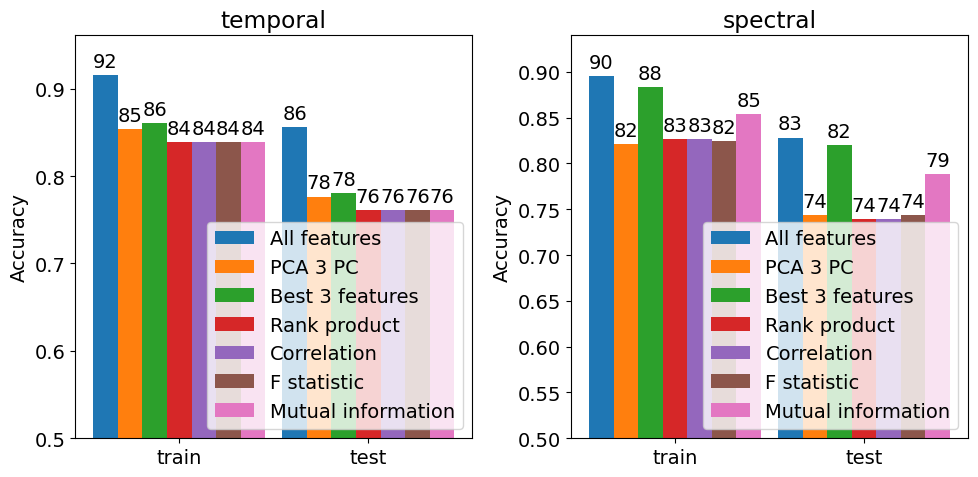

In [76]:
plot_models_performance_bar(mafaulda['X_td'], mafaulda['X_fd'], mafaulda['Y']['target'], mafaulda_models_summary)

In [77]:
#plot_models_performance_bar(pump['X_td'], pump['X_fd'], pump['Y']['label_machine'], pump_models_summary_machine)

In [78]:
#plot_models_performance_bar(pump['X_td'], pump['X_fd'], pump['Y']['label_position'], pump_models_summary_position)

In [79]:
#plot_models_performance_bar(pump['X_td'], pump['X_fd'], pump['Y']['label_binary'], pump_models_summary_binary)

In [80]:
# plot_models_performance_bar(pump['X_td'], pump['X_fd'], pump['Y']['target'], pump_models_summary)
# Scatter plot of best features with rank product
def scatter_features_3d(X, Y, features: list, size=(15, 5), boundary=False):
    Y = Y.dropna()
    X = X[X.index.isin(Y.index)].copy()
    Y = Y[Y.index.isin(X.index)].astype('category')

    scaler = MinMaxScaler()
    X[X.columns] = scaler.fit_transform(X)

    categories = Y.cat.categories
    colors = sb.color_palette('hls', len(categories))
    cmap = ListedColormap(colors.as_hex())

    fig, ax = plt.subplots(1, 3, figsize=size)

    for i, dims in enumerate([(0, 1), (0, 2), (1, 2)]):
        a, b = dims
        columns = [features[a], features[b]]
        p, q = X[columns[0]], X[columns[1]]
 
        if boundary:
            h = .02
            model = model_boundaries(X[columns], Y.cat.codes, model_name=MODEL_TYPE)
            x_min = p.min() - p.std()
            x_max = p.max() + p.std()
            y_min = q.min() - q.std()
            y_max = q.max() + q.std()
            xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                                np.arange(y_min, y_max, h))
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

            Z = Z.reshape(xx.shape)
            ax[i].pcolormesh(xx, yy, Z, cmap=cmap, alpha=0.5)

        ax[i].scatter(
            p, q, c=Y.cat.codes, cmap=cmap, edgecolors='black'
        )

        legend_entries = []
        for c, n in dict(zip(Y.cat.codes, Y)).items():
            legend_entries.append(
                mpatches.Patch(color=colors[c], label=n)
            )
        ax[1].legend(handles=legend_entries)
        ax[i].set_xlabel(columns[0])
        ax[i].set_ylabel(columns[1])
        ax[i].grid(True)
    plt.show()

/home/miroslav/.virtualenvs/dp/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/miroslav/.virtualenvs/dp/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/miroslav/.virtualenvs/dp/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


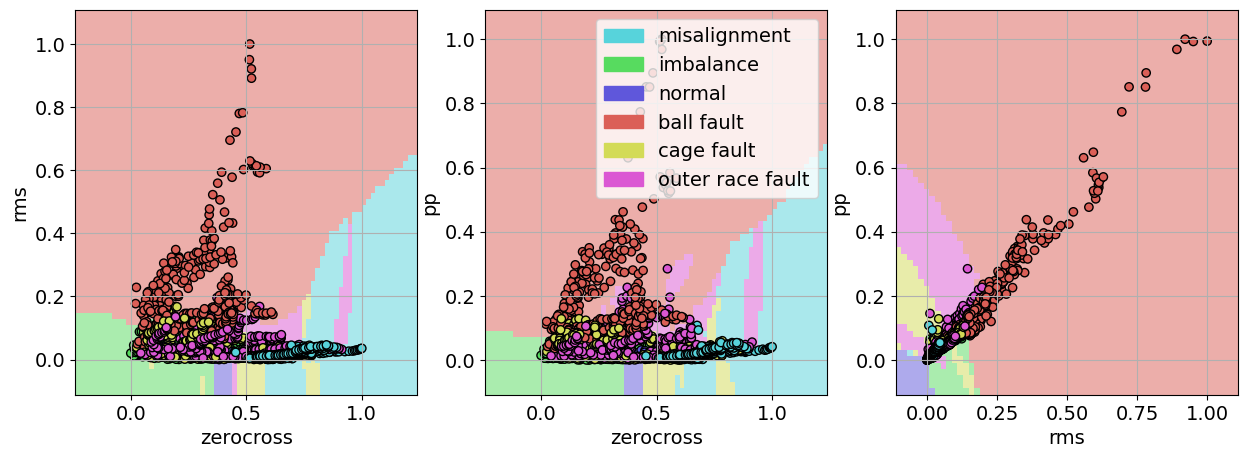

In [81]:
X = mafaulda['X_td']
Y = mafaulda['Y']['target']
features = find_best_subset(X, Y, 'rank')
scatter_features_3d(X, Y, list(features), boundary=True)

/home/miroslav/.virtualenvs/dp/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/miroslav/.virtualenvs/dp/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/miroslav/.virtualenvs/dp/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


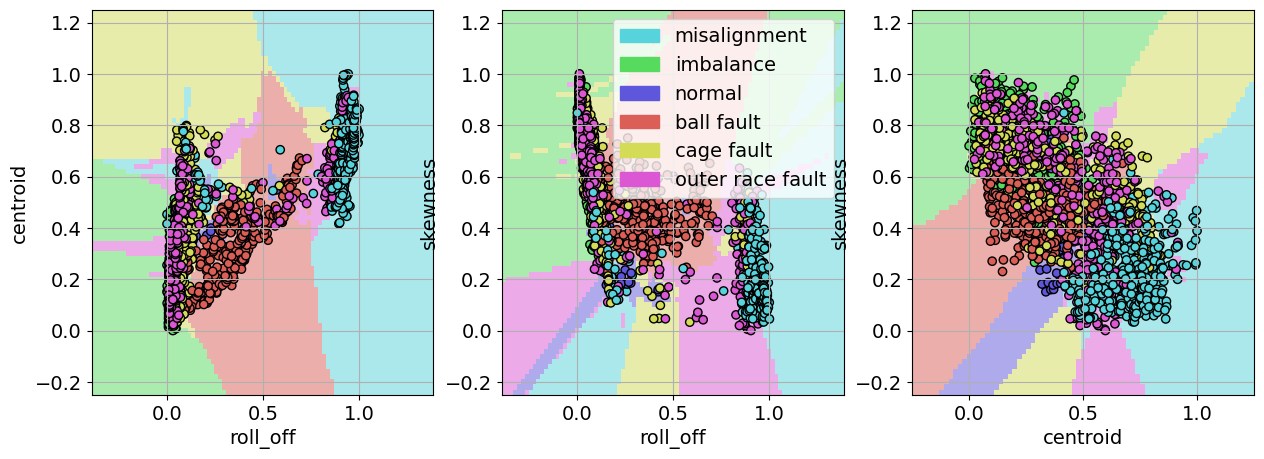

In [82]:
X = mafaulda['X_fd']
Y = mafaulda['Y']['target']
features = find_best_subset(X, Y, 'rank')
scatter_features_3d(X, Y, list(features), boundary=True)

3d plot

In [83]:
def scatter_features_3d_plot(X, Y, features: list, size=(8, 8), boundary=False):
    Y = Y.dropna()
    X = X[X.index.isin(Y.index)].copy()
    Y = Y[Y.index.isin(X.index)].astype('category')

    X = X.reset_index(drop=True)
    Y = Y.reset_index(drop=True)

    scaler = MinMaxScaler()
    X_scaled = X.copy()
    X_scaled[X_scaled.columns] = scaler.fit_transform(X_scaled)

    categories = Y.astype('category').cat.categories
    colors = sb.color_palette('hls', len(categories))
    cmap = ListedColormap(colors.as_hex())

    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(projection='3d')
    columns = [features[0], features[1], features[2]]

    model = model_boundaries(X_scaled[columns], Y, model_name=MODEL_TYPE)
    Y_predict = Y.to_frame('true')
    Y_predict['predict'] = pd.Series(model.predict(X_scaled[columns]))
    
    Y_good = Y_predict.loc[Y_predict['true'] == Y_predict['predict']]
    X_good = X[X.index.isin(Y_good.index)]
    xs, ys, zs = X_good[columns[0]], X_good[columns[1]], X_good[columns[2]]
    ax.scatter(xs, ys, zs, c=Y_good['true'].cat.codes, cmap=cmap, s=5)

    Y_bad = Y_predict.loc[Y_predict['true'] != Y_predict['predict']]
    X_bad = X[X.index.isin(Y_bad.index)]
    xs, ys, zs = X_bad[columns[0]], X_bad[columns[1]], X_bad[columns[2]]
    ax.scatter(xs, ys, zs, c=Y_bad['true'].cat.codes, marker='X', cmap=cmap, linewidths=1, edgecolors='black')

    legend_entries = []
    for c, n in dict(zip(Y.cat.codes, Y)).items():
        legend_entries.append(
            mpatches.Patch(color=colors[c], label=n)
        )
    ax.legend(handles=legend_entries)
    ax.set_xlabel(columns[0], labelpad=10)
    ax.set_ylabel(columns[1], labelpad=10)
    ax.set_zlabel(columns[2], labelpad=10)
    ax.grid(True)
    ax.view_init(elev=20, azim=-45)
    ax.set_box_aspect(None, zoom=0.85)
    fig.tight_layout()
    plt.show()

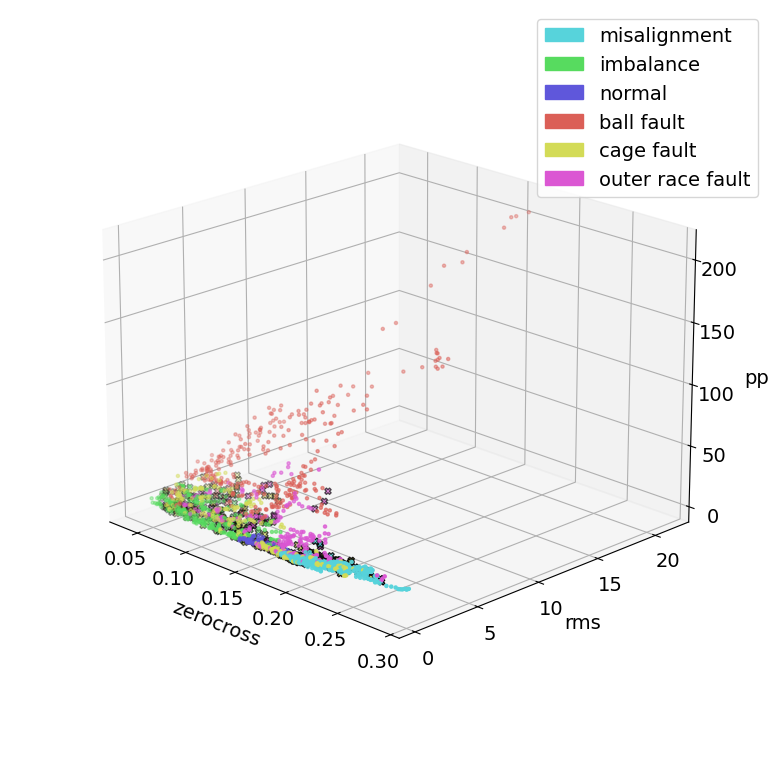

In [84]:
X = mafaulda['X_td']
Y = mafaulda['Y']['target']
features = find_best_subset(X, Y, 'rank')
scatter_features_3d_plot(X, Y, list(features))

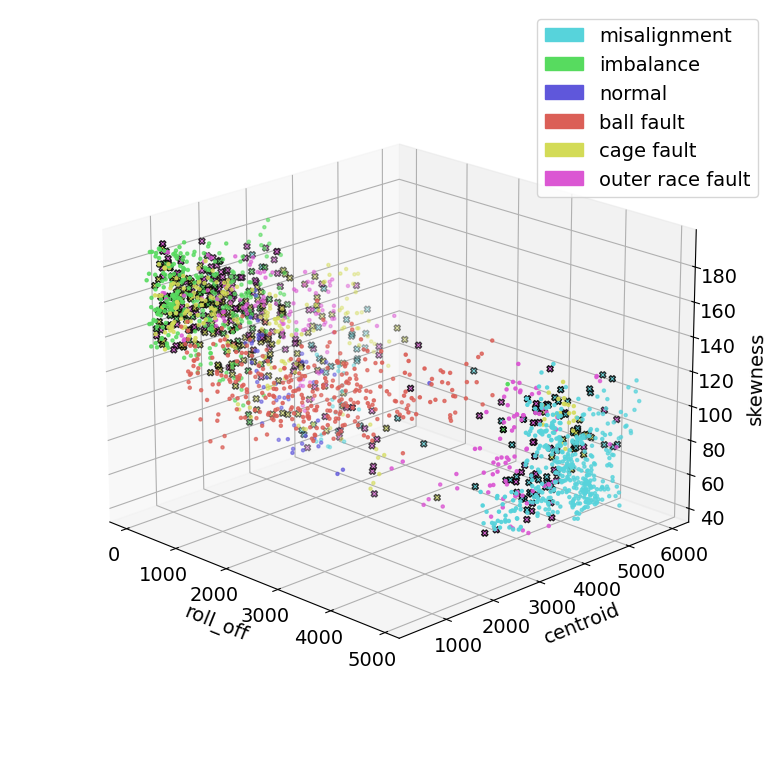

In [85]:
X = mafaulda['X_fd']
Y = mafaulda['Y']['target']
features = find_best_subset(X, Y, 'rank')
scatter_features_3d_plot(X, Y, list(features))

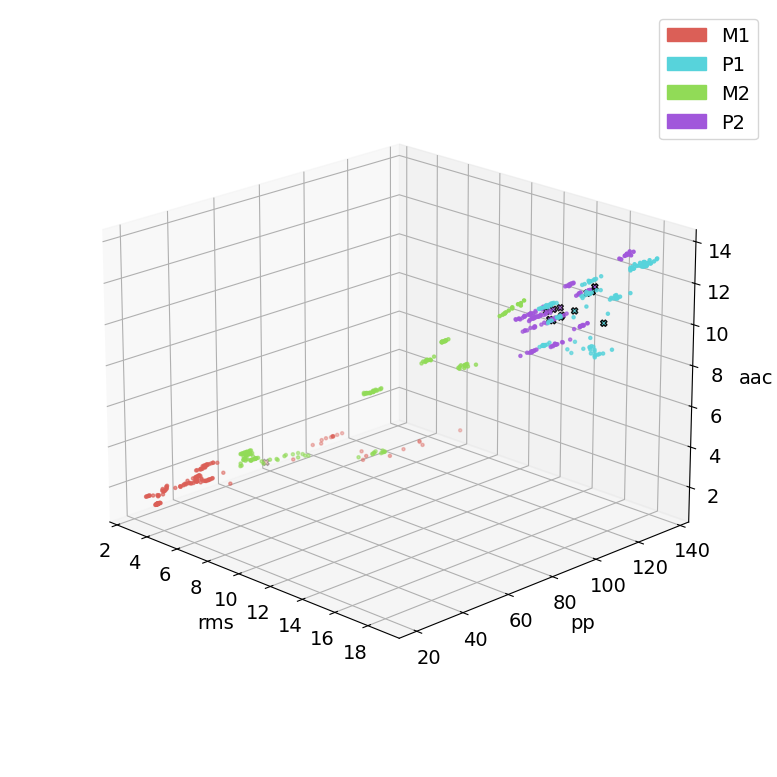

In [86]:
X = pump['X_td']
Y = pump['Y']['label_machine']
features = find_best_subset(X, Y, 'rank')
scatter_features_3d_plot(X, Y, list(features))

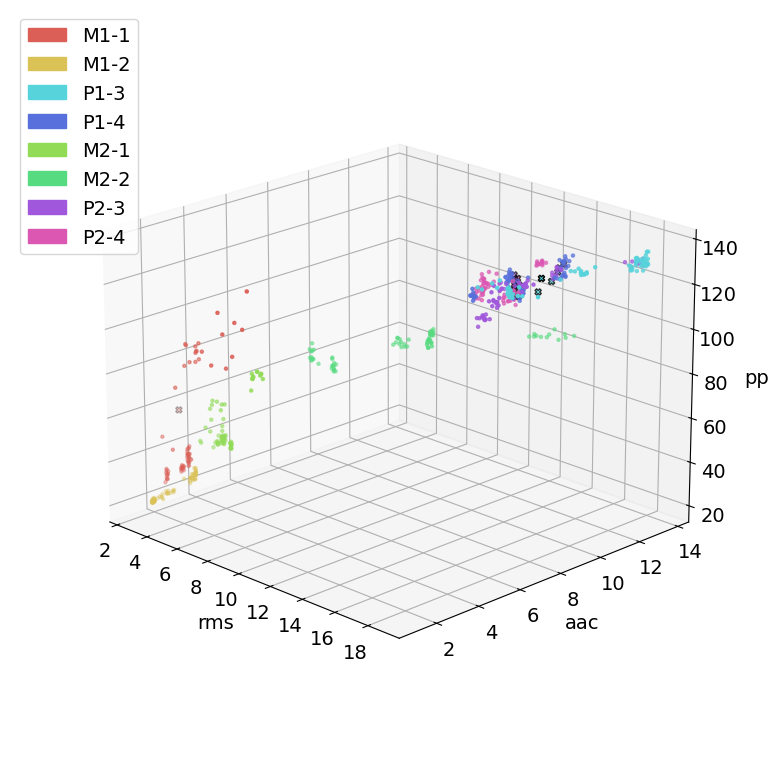

In [87]:
X = pump['X_td']
Y = pump['Y']['label_position']
features = find_best_subset(X, Y, 'rank')
scatter_features_3d_plot(X, Y, list(features))

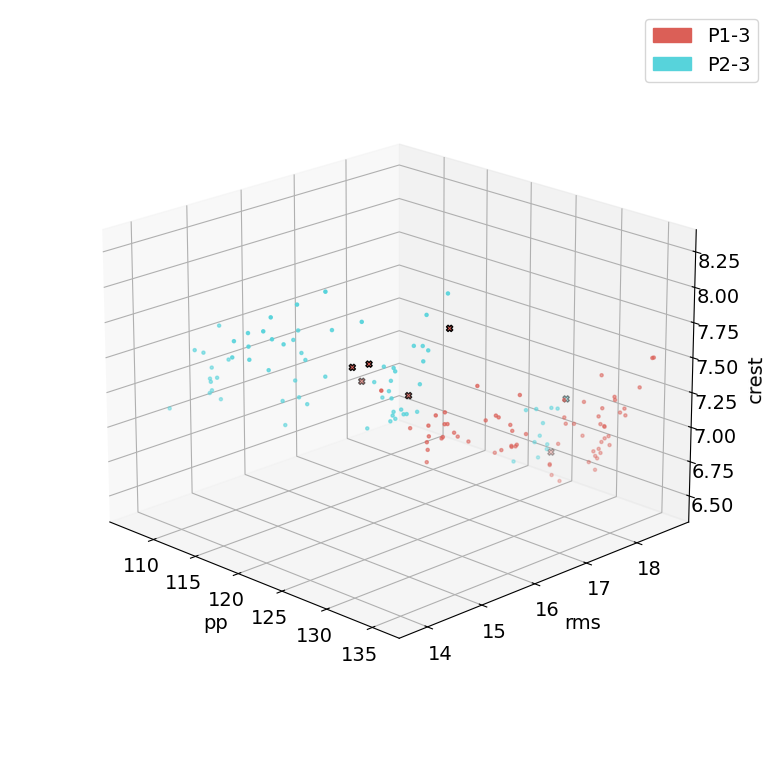

In [88]:
X = pump['X_td']
Y = pump['Y']['label_binary']
features = find_best_subset(X, Y, 'rank')
scatter_features_3d_plot(X, Y, list(features))

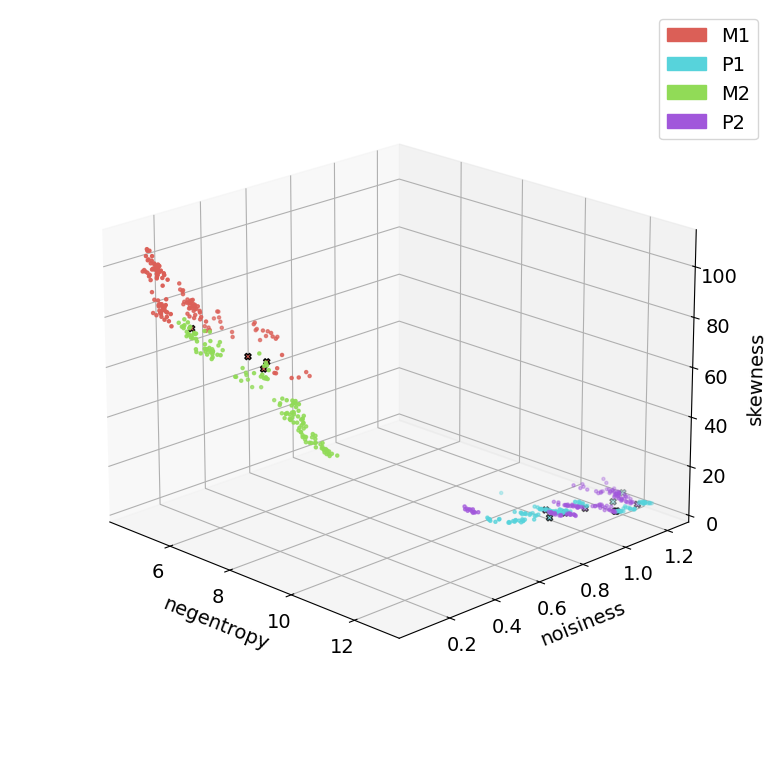

In [89]:
X = pump['X_fd']
Y = pump['Y']['label_machine']
features = find_best_subset(X, Y, 'rank')
scatter_features_3d_plot(X, Y, list(features))

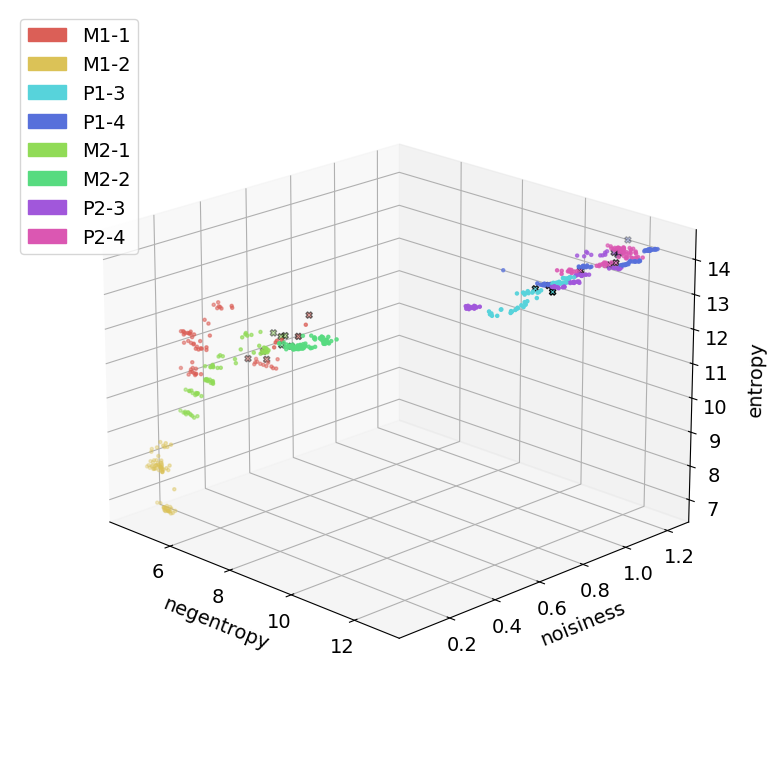

In [90]:
X = pump['X_fd']
Y = pump['Y']['label_position']
features = find_best_subset(X, Y, 'rank')
scatter_features_3d_plot(X, Y, list(features))

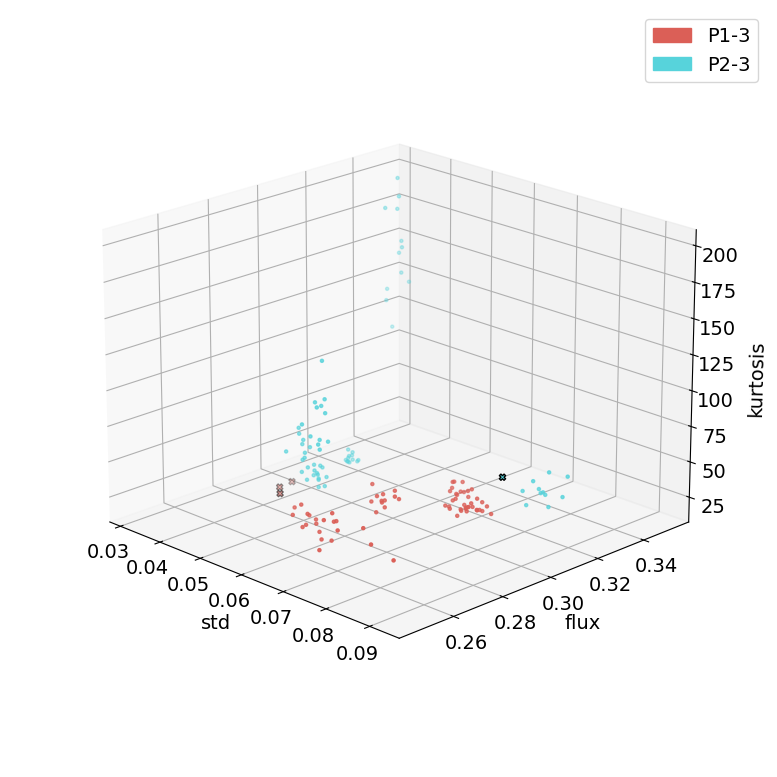

In [91]:
X = pump['X_fd']
Y = pump['Y']['label_binary']
features = find_best_subset(X, Y, 'rank')
scatter_features_3d_plot(X, Y, list(features))